In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
import joblib
import itertools

# --- Configuration ---
# These will be overridden by the grid search, but serve as defaults if not in grid
MODEL_NAME = "GAT_Transformer_Power"
LOOKBACK = 24 * 7  # Using a fixed 1-week lookback for all grid search runs
NUM_EPOCHS = 100
PATIENCE = 15
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- Generic function to load tabular Multivariate Time Series data ---
def load_mts_data(data_df, feature_cols, target_cols, lookback_period):
    print(f"--- Creating sequences with lookback={lookback_period} ---")
    features = data_df[feature_cols].values
    targets = data_df[target_cols].values
    X_list, y_list = [], []
    for i in range(lookback_period, len(data_df)):
        X_list.append(features[i - lookback_period : i])
        y_list.append(targets[i])
    X, y = np.array(X_list), np.array(y_list)
    print(f"Loaded MTS data: X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# --- Chronological Train-Test Split ---
def chronological_train_test_split(X, y, test_ratio=0.2):
    num_samples = X.shape[0]
    num_test_samples = int(num_samples * test_ratio)
    split_index = num_samples - num_test_samples
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# --- TimeSeriesDataset for GAT (Optimized Adjacency) ---
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets, single_adj_matrix, scaler_X=None, scaler_y=None, is_train=True):
        original_shape = features.shape
        if is_train and scaler_X is None:
            self.scaler_X = StandardScaler()
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.fit_transform(flattened)
            self.features = scaled.reshape(original_shape)
        elif not is_train and scaler_X is not None:
            self.scaler_X = scaler_X
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.transform(flattened)
            self.features = scaled.reshape(original_shape)
        else: self.features, self.scaler_X = features, scaler_X

        if is_train and scaler_y is None:
            self.scaler_y = StandardScaler(); self.targets = self.scaler_y.fit_transform(targets)
        elif not is_train and scaler_y is not None:
            self.scaler_y = scaler_y; self.targets = self.scaler_y.transform(targets)
        else: self.targets, self.scaler_y = targets, scaler_y

        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)

        if not isinstance(single_adj_matrix, torch.Tensor):
            self.single_adj_matrix = torch.tensor(single_adj_matrix, dtype=torch.float32)
        else:
            self.single_adj_matrix = single_adj_matrix.to(dtype=torch.float32)

    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.single_adj_matrix, self.targets[idx]
    def get_scalers(self): return self.scaler_X, self.scaler_y

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term); pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0); self.register_buffer('pe', pe)
    def forward(self, x):
        pe_sliced = self.pe[:, :x.size(1), :]
        try:
            result = x + pe_sliced
        except RuntimeError as e:
            print(f"ERROR in PositionalEncoding: x.shape={x.shape}, pe_sliced.shape={pe_sliced.shape}")
            raise e
        return result

# --- Graph Attention Layer & MultiHeadGraphAttention ---
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2, alpha=0.2):
        super(GraphAttentionLayer, self).__init__()
        self.dropout_val, self.alpha = dropout, alpha
        self.W = nn.Parameter(torch.empty(size=(in_features, out_features))); nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1))); nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(self.alpha); self.dropout_layer = nn.Dropout(self.dropout_val)
    def forward(self, h, adj):
        Wh = torch.matmul(h, self.W); a_input = self._prepare_attention_input(Wh)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(-1))
        zero_vec = -9e15*torch.ones_like(e); attention_masked = torch.where(adj.unsqueeze(0) > 0, e, zero_vec)
        attention_softmax = F.softmax(attention_masked, dim=-1); attention_dropout = self.dropout_layer(attention_softmax)
        h_prime = torch.matmul(attention_dropout, Wh); return F.elu(h_prime)
    def _prepare_attention_input(self, Wh):
        B, N, _ = Wh.size(); Wh_i = Wh.unsqueeze(2).expand(B, N, N, -1); Wh_j = Wh.unsqueeze(1).expand(B, N, N, -1)
        return torch.cat([Wh_i, Wh_j], dim=-1)

class MultiHeadGraphAttention(nn.Module):
    def __init__(self, in_features, out_features_per_head, n_heads, dropout=0.2, alpha=0.2, concat=True):
        super(MultiHeadGraphAttention, self).__init__()
        self.concat = concat
        self.attentions = nn.ModuleList([GraphAttentionLayer(in_features, out_features_per_head, dropout=dropout, alpha=alpha) for _ in range(n_heads)])
        self.out_dim = out_features_per_head * n_heads if concat else out_features_per_head
    def forward(self, x, adj):
        head_outputs = [att(x, adj) for att in self.attentions]
        return torch.cat(head_outputs, dim=-1) if self.concat else torch.mean(torch.stack(head_outputs, dim=-1), dim=-1)

# --- GAT+Transformer Model ---
class MTSPredictorGATTransformer(nn.Module):
    def __init__(self, input_size, output_size, d_model_gat=64, gat_heads=4,
                 d_model_transformer=64, transformer_heads=4, num_transformer_layers=2,
                 dim_feedforward_transformer=256, dropout_rate=0.2):
        super(MTSPredictorGATTransformer, self).__init__()
        self.dropout_rate = dropout_rate
        self.gat_input_proj = nn.Linear(input_size, d_model_gat)
        self.gat_attention = MultiHeadGraphAttention(in_features=d_model_gat, out_features_per_head=d_model_gat // gat_heads,
                                                     n_heads=gat_heads, dropout=self.dropout_rate, concat=True)
        gat_output_dim = self.gat_attention.out_dim
        self.pos_encoder = PositionalEncoding(gat_output_dim, max_len=LOOKBACK + 100)
        transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=gat_output_dim, nhead=transformer_heads,
                                                               dim_feedforward=dim_feedforward_transformer,
                                                               dropout=self.dropout_rate, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=num_transformer_layers)
        self.fc = nn.Sequential(nn.Linear(gat_output_dim, 64), nn.ReLU(), nn.Dropout(self.dropout_rate),
                                nn.Linear(64, 32), nn.ReLU(), nn.Dropout(self.dropout_rate),
                                nn.Linear(32, output_size))
    def forward(self, x, adj):
        x_proj = F.elu(self.gat_input_proj(x))
        x_gat_attended = self.gat_attention(x_proj, adj)
        if x_gat_attended.dim() == 4 and x_gat_attended.shape[0] == 1:
             x_gat_attended = x_gat_attended.squeeze(0)
        x_pos_encoded = self.pos_encoder(x_gat_attended)
        x_transformed = self.transformer_encoder(x_pos_encoded)
        x_last_step = x_transformed[:, -1, :]
        return self.fc(x_last_step)

# --- Training Function ---
def train_model_gat_based(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience, device, model_save_name):
    best_val_loss = float('inf'); epochs_no_improve = 0
    train_losses_history, val_losses_history = [], []
    for epoch in range(num_epochs):
        model.train(); epoch_train_loss = 0
        for batch_X, batch_adj_single, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
            outputs = model(batch_X, batch_adj_single[0])
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad(); loss.backward(); optimizer.step(); epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader); train_losses_history.append(epoch_train_loss)

        model.eval(); epoch_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_adj_single, batch_y in val_loader:
                batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
                outputs = model(batch_X, batch_adj_single[0])
                loss = criterion(outputs, batch_y); epoch_val_loss += loss.item()
        epoch_val_loss /= len(val_loader); val_losses_history.append(epoch_val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f}, LR={current_lr:.6f}")
        if scheduler: scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss; epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_name)
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping @ epoch {epoch+1} as validation loss did not improve for {patience} epochs.")
            break
    if os.path.exists(model_save_name):
        model.load_state_dict(torch.load(model_save_name))
    return model, train_losses_history, val_losses_history, best_val_loss

# --- Evaluation Function ---
def evaluate_model_gat_based(model, test_loader, scaler_y, device, model_name="GAT-based Model"):
    model.eval(); all_preds_s, all_targets_s = [], []
    with torch.no_grad():
        for batch_X, batch_adj_single, batch_y_s in test_loader:
            batch_X, batch_adj_single = batch_X.to(device), batch_adj_single.to(device)
            outputs_s = model(batch_X, batch_adj_single[0])
            all_preds_s.append(outputs_s.cpu().numpy()); all_targets_s.append(batch_y_s.cpu().numpy())
    preds_s_np = np.vstack(all_preds_s); tgts_s_np = np.vstack(all_targets_s)

    if scaler_y:
        preds_o = scaler_y.inverse_transform(preds_s_np); tgts_o = scaler_y.inverse_transform(tgts_s_np)
    else: preds_o, tgts_o = preds_s_np, tgts_s_np

    mse = mean_squared_error(tgts_o, preds_o); rmse = np.sqrt(mse); r2 = r2_score(tgts_o, preds_o); mae = mean_absolute_error(tgts_o, preds_o)
    print(f"\nEvaluation metrics ({model_name}):\n MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return preds_o, tgts_o, mse, rmse, r2, mae

# --- Plotting Functions ---
def plot_training_losses(train_losses, val_losses, model_name, save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'training_losses_{model_name}.png')
    plt.figure(figsize=(10, 6)); plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss (MSE)'); plt.title(f'Training & Validation Losses ({model_name})')
    plt.legend(); plt.grid(True); plt.savefig(save_path); plt.show()

def plot_predictions_vs_true(targets_original, predictions_original, model_name, target_name="Target", save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'predictions_vs_true_{model_name}.png')
    plt.figure(figsize=(12, 8)); plt.scatter(targets_original, predictions_original, alpha=0.3, label='Sample Predictions')
    min_val = min(targets_original.ravel().min(), predictions_original.ravel().min())
    max_val = max(targets_original.ravel().max(), predictions_original.ravel().max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x (Perfect Prediction)')
    plt.xlabel(f'True Values ({target_name})'); plt.ylabel(f'Predicted Values ({target_name})')
    plt.title(f'Predictions vs True Values for {target_name} ({model_name})')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig(save_path); plt.show()

# --- New Function to run a single training session for grid search ---
def run_training_session(params, train_dataset, val_dataset, adj_matrix_template, model_input_size, model_output_size, output_dir):
    """
    Encapsulates a full training run for a given set of hyperparameters.
    """
    print(f"\n--- Running with params: {params} ---")

    # Unpack hyperparameters
    lr = params['LEARNING_RATE']
    dropout_rate = params['DROPOUT_RATE']
    weight_decay = params['WEIGHT_DECAY']
    batch_size = params['BATCH_SIZE']

    # Create DataLoaders with current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Initialize model with current dropout rate
    model = MTSPredictorGATTransformer(
        input_size=model_input_size,
        output_size=model_output_size,
        dropout_rate=dropout_rate
    ).to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, verbose=False)

    # Define a unique model save path for this run
    param_str = "_".join([f"{k}_{v}" for k, v in params.items()])
    model_save_name = os.path.join(output_dir, f"best_model_{param_str}.pt")

    # Run training
    _, _, _, best_val_loss = train_model_gat_based(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        NUM_EPOCHS, PATIENCE, DEVICE, model_save_name
    )

    return best_val_loss

# --- Main Function ---
def main_mts_forecaster():
    print(f"--- Running {MODEL_NAME} Grid Search ---")
    print(f"Using device: {DEVICE}")
    output_dir = f"results_{MODEL_NAME.lower()}_grid_search"
    viz_dir = os.path.join(output_dir, "visualizations")
    if not os.path.exists(viz_dir): os.makedirs(viz_dir)

    # --- 1. DEFINE HYPERPARAMETER GRID ---
    param_grid = {
        'LEARNING_RATE': [0.001, 0.0005],
        'DROPOUT_RATE': [0.3, 0.5],
        'WEIGHT_DECAY': [1e-5, 1e-4],
        'BATCH_SIZE': [64] # Keeping batch size fixed to reduce run time, can add more e.g., [32, 64]
    }
    print("--- Hyperparameter Grid ---")
    print(param_grid)

    # --- 2. LOAD AND PREPROCESS DATA ONCE ---
    data_path = '/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt'
    if not os.path.exists(data_path):
        print(f"ERROR: Dataset not found at '{data_path}'"); return

    print("Loading and preprocessing data... This may take a moment.")
    df = pd.read_csv(
        data_path, sep=';', low_memory=False, na_values=['?'],
        parse_dates={'datetime': ['Date', 'Time']},
        infer_datetime_format=True, index_col='datetime'
    )
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.ffill(inplace=True)

    agg_rules = {
        'Global_active_power': 'sum', 'Global_reactive_power': 'sum',
        'Voltage': 'mean', 'Global_intensity': 'mean',
        'Sub_metering_1': 'sum', 'Sub_metering_2': 'sum', 'Sub_metering_3': 'sum'
    }
    df_resampled = df.resample('h').agg(agg_rules)
    if df_resampled.isnull().sum().any():
        df_resampled.ffill(inplace=True); df_resampled.bfill(inplace=True)

    print(f"Data resampled to hourly. New shape: {df_resampled.shape}")
    
    feature_cols = [
        'Global_active_power', 'Global_reactive_power', 'Voltage', 
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
    ]
    target_cols = ['Global_active_power']
    target_name_for_plot = "Global Active Power"
    
    X_all, y_all = load_mts_data(df_resampled, feature_cols, target_cols, LOOKBACK)
    if X_all.shape[0] == 0: print("No valid samples generated. Exiting."); return
    
    X_tv_and_val, X_test, y_tv_and_val, y_test = chronological_train_test_split(X_all, y_all, test_ratio=0.2)
    if X_tv_and_val.shape[0] == 0: print(f"No training/validation samples. Exiting."); return

    # --- 3. CREATE DATASETS ONCE ---
    adj_matrix_template = torch.zeros(LOOKBACK, LOOKBACK, dtype=torch.float32)
    for i in range(LOOKBACK):
        if i > 0: adj_matrix_template[i, i-1] = 1
        if i < LOOKBACK - 1: adj_matrix_template[i, i+1] = 1
        adj_matrix_template[i, i] = 1
    adj_matrix_template = adj_matrix_template.to(DEVICE)

    full_train_val_dataset = TimeSeriesDataset(X_tv_and_val, y_tv_and_val, adj_matrix_template.cpu(), is_train=True)
    scaler_X, scaler_y = full_train_val_dataset.get_scalers()

    train_s = int(0.8 * len(full_train_val_dataset))
    val_s = len(full_train_val_dataset) - train_s
    gen = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = torch.utils.data.random_split(full_train_val_dataset, [train_s, val_s], generator=gen)

    # --- 4. RUN GRID SEARCH LOOP ---
    best_params = {}
    best_val_loss = float('inf')
    
    param_combinations = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    for params in param_combinations:
        val_loss = run_training_session(
            params=params,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            adj_matrix_template=adj_matrix_template,
            model_input_size=X_tv_and_val.shape[-1],
            model_output_size=y_tv_and_val.shape[-1],
            output_dir=output_dir
        )
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"!!! New best validation loss: {best_val_loss:.4f} with params: {best_params}")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")

    print(f"\n--- Grid Search Complete ---")
    print(f"Best validation loss found: {best_val_loss:.4f}")
    print(f"Best hyperparameters: {best_params}")

    # --- 5. FINAL EVALUATION WITH BEST HYPERPARAMETERS ---
    print("\n--- Training final model with best hyperparameters on all training data ---")
    
    final_model = MTSPredictorGATTransformer(
        input_size=X_tv_and_val.shape[-1],
        output_size=y_tv_and_val.shape[-1],
        dropout_rate=best_params['DROPOUT_RATE']
    ).to(DEVICE)
    
    # --- FIX WAS HERE ---
    final_optimizer = optim.Adam(
        final_model.parameters(), 
        lr=best_params['LEARNING_RATE'], 
        weight_decay=best_params['WEIGHT_DECAY']
    )
    # --- END OF FIX ---

    final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        final_optimizer, mode='min', factor=0.1, patience=7, verbose=True
    )
    final_criterion = nn.MSELoss()

    final_train_loader = DataLoader(full_train_val_dataset, batch_size=best_params['BATCH_SIZE'], shuffle=True)
    final_val_loader = DataLoader(val_dataset, batch_size=best_params['BATCH_SIZE'], shuffle=False)
    
    final_model_save_path = os.path.join(output_dir, "final_best_model.pt")
    
    print("Starting final training run...")
    trained_model, train_L, val_L, _ = train_model_gat_based(
        final_model, final_train_loader, final_val_loader, final_criterion, final_optimizer, final_scheduler,
        NUM_EPOCHS, PATIENCE, DEVICE, final_model_save_path
    )
    
    plot_training_losses(train_L, val_L, f"{MODEL_NAME}_final", save_dir=viz_dir)
   
    if X_test.shape[0] > 0:
        print("\n--- Evaluating final model on test set ---")
        test_dataset = TimeSeriesDataset(X_test, y_test, adj_matrix_template.cpu(), scaler_X, scaler_y, is_train=False)
        test_loader = DataLoader(test_dataset, batch_size=best_params['BATCH_SIZE'], shuffle=False)
        
        preds_o, tgts_o, _, _, _, _ = evaluate_model_gat_based(trained_model, test_loader, scaler_y, DEVICE, f"{MODEL_NAME}_final")
        plot_predictions_vs_true(tgts_o, preds_o, f"{MODEL_NAME}_final", target_name=target_name_for_plot, save_dir=viz_dir)
    else:
        print("Test set was empty. Skipping final evaluation.")

    print(f"Grid search and final evaluation complete. Results in {output_dir}")
if __name__ == "__main__":
    main_mts_forecaster()

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
import joblib

# --- Configuration ---
MODEL_NAME = "GAT_Transformer_Power_Improved" # Updated Model Name
LOOKBACK = 24 * 7  # One week lookback (168 hours)
BATCH_SIZE = 64   # Adjusted Batch Size
LEARNING_RATE = 0.001 # Adjusted Learning Rate
NUM_EPOCHS = 200   # Can be increased
PATIENCE = 15      # Increased patience for early stopping, works well with LR scheduler
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
WEIGHT_DECAY =  0.0001 # Adjusted weight decay for regularization
DROPOUT_RATE = 0.3 # Adjusted dropout rate

# --- Generic function to load tabular Multivariate Time Series data ---
def load_mts_data(data_df, feature_cols, target_cols, lookback_period):
    print(f"--- {MODEL_NAME}: Creating sequences from data ---")
    features = data_df[feature_cols].values
    targets = data_df[target_cols].values

    X_list = []
    y_list = []

    for i in range(lookback_period, len(data_df)):
        X_list.append(features[i - lookback_period : i])
        y_list.append(targets[i])

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"Loaded MTS data: X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# --- Chronological Train-Test Split ---
def chronological_train_test_split(X, y, test_ratio=0.2):
    num_samples = X.shape[0]
    num_test_samples = int(num_samples * test_ratio)
    split_index = num_samples - num_test_samples

    X_train = X[:split_index]
    y_train = y[:split_index]
    X_test = X[split_index:]
    y_test = y[split_index:]

    print(f"X_train shape ({MODEL_NAME}): {X_train.shape}")
    print(f"X_test shape ({MODEL_NAME}): {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

# --- TimeSeriesDataset for GAT (Optimized Adjacency) ---
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets, single_adj_matrix, scaler_X=None, scaler_y=None, is_train=True):
        original_shape = features.shape
        if is_train and scaler_X is None:
            self.scaler_X = StandardScaler()
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.fit_transform(flattened)
            self.features = scaled.reshape(original_shape)
        elif not is_train and scaler_X is not None:
            self.scaler_X = scaler_X
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.transform(flattened)
            self.features = scaled.reshape(original_shape)
        else: self.features = features; self.scaler_X = scaler_X
        
        if is_train and scaler_y is None:
            self.scaler_y = StandardScaler(); self.targets = self.scaler_y.fit_transform(targets)
        elif not is_train and scaler_y is not None:
            self.scaler_y = scaler_y; self.targets = self.scaler_y.transform(targets)
        else: self.targets = targets; self.scaler_y = scaler_y
        
        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)
        
        if not isinstance(single_adj_matrix, torch.Tensor):
            self.single_adj_matrix = torch.tensor(single_adj_matrix, dtype=torch.float32)
        else:
            self.single_adj_matrix = single_adj_matrix.to(dtype=torch.float32)

    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.single_adj_matrix, self.targets[idx]
    def get_scalers(self): return self.scaler_X, self.scaler_y

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000): 
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term); pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0); self.register_buffer('pe', pe)
    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        # self.pe shape: (1, max_len, d_model)
        pe_sliced = self.pe[:, :x.size(1), :] # Correct slicing
        try:
            result = x + pe_sliced
        except RuntimeError as e:
            print(f"ERROR during PositionalEncoding addition: x.shape={x.shape}, pe_sliced.shape={pe_sliced.shape}, self.pe.shape={self.pe.shape}")
            raise e
        return result

# --- Graph Attention Layer & MultiHeadGraphAttention ---
# Using dropout_rate from MTSPredictorGATTransformer (passed as 'dropout')
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=DROPOUT_RATE, alpha=0.2): 
        super(GraphAttentionLayer, self).__init__()
        self.in_features=in_features; self.out_features=out_features; self.dropout_val=dropout; self.alpha=alpha
        self.W=nn.Parameter(torch.empty(size=(in_features, out_features))); nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a=nn.Parameter(torch.empty(size=(2*out_features, 1))); nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu=nn.LeakyReLU(self.alpha); self.dropout_layer=nn.Dropout(self.dropout_val)
    def forward(self, h, adj):
        Wh=torch.matmul(h, self.W); a_input=self._prepare_attention_input(Wh)
        e=self.leakyrelu(torch.matmul(a_input, self.a).squeeze(-1))
        zero_vec = -9e15*torch.ones_like(e); attention_masked = torch.where(adj.unsqueeze(0) > 0, e, zero_vec)
        attention_softmax=F.softmax(attention_masked, dim=-1); attention_dropout=self.dropout_layer(attention_softmax)
        h_prime=torch.matmul(attention_dropout, Wh); return F.elu(h_prime)
    def _prepare_attention_input(self, Wh):
        B,N,_=Wh.size(); Wh_i=Wh.unsqueeze(2).expand(B,N,N,-1); Wh_j=Wh.unsqueeze(1).expand(B,N,N,-1)
        return torch.cat([Wh_i, Wh_j], dim=-1)

class MultiHeadGraphAttention(nn.Module):
    def __init__(self, in_features, out_features_per_head, n_heads, dropout=DROPOUT_RATE, alpha=0.2, concat=True):
        super(MultiHeadGraphAttention, self).__init__()
        self.n_heads=n_heads; self.concat=concat
        self.attentions=nn.ModuleList([GraphAttentionLayer(in_features, out_features_per_head, dropout=dropout, alpha=alpha) for _ in range(n_heads)])
        self.out_dim = out_features_per_head * n_heads if concat else out_features_per_head
    def forward(self, x, adj):
        head_outputs=[att(x, adj) for att in self.attentions]
        if self.concat: return torch.cat(head_outputs, dim=-1)
        else: return torch.mean(torch.stack(head_outputs, dim=-1), dim=-1)

# --- GAT+Transformer Model ---
class MTSPredictorGATTransformer(nn.Module):
    def __init__(self, input_size, output_size, d_model_gat=64, gat_heads=4,
                 d_model_transformer=64, transformer_heads=4, num_transformer_layers=2,
                 dim_feedforward_transformer=256, dropout_rate=DROPOUT_RATE): # Use global DROPOUT_RATE
        super(MTSPredictorGATTransformer, self).__init__()
        self.dropout_rate = dropout_rate # Use the passed dropout_rate
        self.gat_input_proj = nn.Linear(input_size, d_model_gat)
        self.gat_attention = MultiHeadGraphAttention(
            in_features=d_model_gat,
            out_features_per_head=d_model_gat // gat_heads,
            n_heads=gat_heads, dropout=self.dropout_rate, concat=True # Pass self.dropout_rate
        )
        gat_output_dim = self.gat_attention.out_dim
        # Ensure max_len is appropriate for LOOKBACK
        self.pos_encoder = PositionalEncoding(gat_output_dim, max_len=LOOKBACK + 100) 
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=gat_output_dim, nhead=transformer_heads, dim_feedforward=dim_feedforward_transformer,
            dropout=self.dropout_rate, batch_first=True # Use self.dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=num_transformer_layers)
        self.fc = nn.Sequential(
            nn.Linear(gat_output_dim, 64),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate), # Use self.dropout_rate
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate), # Use self.dropout_rate
            nn.Linear(32, output_size)
        )
    def forward(self, x, adj):
        x_proj = F.elu(self.gat_input_proj(x))
        # The dropout before GAT was removed in previous versions as GAT layers have internal dropout.
        # If needed, it can be added back:
        # x_gat_drop = F.dropout(x_proj, self.dropout_rate, training=self.training)
        # x_gat_attended = self.gat_attention(x_gat_drop, adj)
        x_gat_attended = self.gat_attention(x_proj, adj)


        if x_gat_attended.dim() == 4 and x_gat_attended.shape[0] == 1:
             x_gat_attended = x_gat_attended.squeeze(0)

        x_pos_encoded = self.pos_encoder(x_gat_attended)
        x_transformed = self.transformer_encoder(x_pos_encoded)
        x_last_step = x_transformed[:, -1, :]
        output = self.fc(x_last_step)
        return output

# --- Training Function (Modified to accept and use scheduler) ---
def train_model_gat_based(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience, device, model_save_name):
    best_val_loss = float('inf'); epochs_no_improve = 0
    train_losses_history, val_losses_history = [], []
    for epoch in range(num_epochs):
        model.train(); epoch_train_loss = 0
        for batch_X, batch_adj_single, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
            outputs = model(batch_X, batch_adj_single[0]);
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad(); loss.backward(); optimizer.step(); epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader); train_losses_history.append(epoch_train_loss)
        
        model.eval(); epoch_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_adj_single, batch_y in val_loader:
                batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
                outputs = model(batch_X, batch_adj_single[0])
                loss = criterion(outputs, batch_y); epoch_val_loss += loss.item()
        epoch_val_loss /= len(val_loader); val_losses_history.append(epoch_val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f}, LR={current_lr:.6f}")

        scheduler.step(epoch_val_loss) # Step the scheduler

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss; epochs_no_improve = 0; torch.save(model.state_dict(), model_save_name)
            print(f"Validation loss improved to {best_val_loss:.4f}. Saving model.")
        else: 
            epochs_no_improve += 1
            print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience: 
            print(f"Early stopping @ epoch {epoch+1} as validation loss did not improve for {patience} epochs.")
            break
    
    if os.path.exists(model_save_name): 
        print(f"Loading best model from {model_save_name}")
        model.load_state_dict(torch.load(model_save_name))
    return model, train_losses_history, val_losses_history

# --- Evaluation Function ---
def evaluate_model_gat_based(model, test_loader, scaler_y, device, model_name="GAT-based Model"):
    model.eval(); all_preds_s, all_targets_s = [], []
    with torch.no_grad():
        for batch_X, batch_adj_single, batch_y_s in test_loader:
            batch_X, batch_adj_single = batch_X.to(device), batch_adj_single.to(device)
            outputs_s = model(batch_X, batch_adj_single[0])
            all_preds_s.append(outputs_s.cpu().numpy()); all_targets_s.append(batch_y_s.cpu().numpy())
    preds_s_np = np.vstack(all_preds_s); tgts_s_np = np.vstack(all_targets_s)
    
    if scaler_y: 
        preds_o = scaler_y.inverse_transform(preds_s_np)
        tgts_o = scaler_y.inverse_transform(tgts_s_np)
    else: 
        preds_o = preds_s_np; tgts_o = tgts_s_np
    
    mse=mean_squared_error(tgts_o,preds_o); rmse=np.sqrt(mse); r2=r2_score(tgts_o,preds_o); mae=mean_absolute_error(tgts_o,preds_o)
    print(f"\nEvaluation metrics ({model_name}):\n MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return preds_o, tgts_o, mse, rmse, r2, mae

# --- Plotting Functions ---
def plot_training_losses(train_losses, val_losses, model_name, save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'training_losses_{model_name}.png')
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss (MSE)'); plt.title(f'Training & Validation Losses ({model_name})')
    plt.legend(); plt.grid(True); plt.savefig(save_path); plt.show()

def plot_predictions_vs_true(targets_original, predictions_original, model_name, target_name="Target", save_dir='visualizations'): # Added target_name
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'predictions_vs_true_{model_name}.png')

    plt.figure(figsize=(12, 8))
    plt.scatter(targets_original, predictions_original, alpha=0.3, label='Sample Predictions')
    min_val = min(targets_original.ravel().min(), predictions_original.ravel().min())
    max_val = max(targets_original.ravel().max(), predictions_original.ravel().max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x (Perfect Prediction)')

    plt.xlabel(f'True Values ({target_name})'); plt.ylabel(f'Predicted Values ({target_name})') # Use target_name
    plt.title(f'Predictions vs True Values for {target_name} ({model_name})') # Use target_name
    plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.savefig(save_path); plt.show()

# --- Main Function ---
def main_mts_forecaster():
    print(f"--- Running {MODEL_NAME} Model ---")
    print(f"Using device: {DEVICE}")
    # Update output_dir to reflect parameter changes
    output_dir = f"results_{MODEL_NAME.lower()}_lb{LOOKBACK}_bs{BATCH_SIZE}_lr{LEARNING_RATE}_dr{DROPOUT_RATE}_wd{WEIGHT_DECAY}"
    viz_dir = os.path.join(output_dir, "visualizations")
    if not os.path.exists(viz_dir): os.makedirs(viz_dir)

    data_path = '/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt'
    if not os.path.exists(data_path):
        print(f"ERROR: Dataset not found at '{data_path}'")
        return

    print("Loading and preprocessing data... This may take a moment.")
    df = pd.read_csv(
        data_path, sep=';', low_memory=False, na_values=['?'],
        parse_dates={'datetime': ['Date', 'Time']},
        infer_datetime_format=True, index_col='datetime'
    )
    
    # Convert all columns to numeric after loading, before ffill
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.ffill(inplace=True)
    # df.bfill(inplace=True) # Optional: fill any remaining at the beginning

    # Check for any NaNs remaining after ffill (should be none if dataset starts with valid values)
    if df.isnull().sum().any():
        print("Warning: NaNs still present after ffill. Filling remaining with 0 (consider implications).")
        df.fillna(0, inplace=True) # Fill any NaNs that might be left (e.g. if all values in a column were NaN initially)

    agg_rules = {
        'Global_active_power': 'sum', 'Global_reactive_power': 'sum',
        'Voltage': 'mean', 'Global_intensity': 'mean',
        'Sub_metering_1': 'sum', 'Sub_metering_2': 'sum', 'Sub_metering_3': 'sum'
    }
    df_resampled = df.resample('h').agg(agg_rules)
    
    # Additional check for NaNs after resampling (e.g., if an entire hour had no data)
    if df_resampled.isnull().sum().any():
        print("Warning: NaNs found after resampling. Applying ffill then bfill.")
        df_resampled.ffill(inplace=True)
        df_resampled.bfill(inplace=True) # Fill NaNs at the beginning if any
        if df_resampled.isnull().sum().any(): # If still NaNs, means entire series part is missing
            print("Critical: NaNs still present after resampling and fill. Filling with 0.")
            df_resampled.fillna(0, inplace=True)


    print(f"Data resampled to hourly. New shape: {df_resampled.shape}")
    print(df_resampled.head())

    feature_cols = [
        'Global_active_power', 'Global_reactive_power', 'Voltage', 
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
    ]
    target_cols = ['Global_active_power']
    target_name_for_plot = "Global Active Power" # For plot labels
    
    data_df = df_resampled
    
    X_all, y_all = load_mts_data(data_df, feature_cols, target_cols, LOOKBACK)
    
    if X_all.shape[0] == 0: print("No valid samples generated. Exiting."); return
    
    X_tv, X_test, y_tv, y_test = chronological_train_test_split(X_all, y_all, test_ratio=0.2)
    
    if X_tv.shape[0] == 0: print(f"No training/validation samples for {MODEL_NAME}. Exiting."); return

    adj_matrix_template = torch.zeros(LOOKBACK, LOOKBACK, dtype=torch.float32)
    for i in range(LOOKBACK):
        if i > 0: adj_matrix_template[i, i-1] = 1
        if i < LOOKBACK - 1: adj_matrix_template[i, i+1] = 1
        adj_matrix_template[i, i] = 1
    adj_matrix_template = adj_matrix_template.to(DEVICE)
    
    tv_dataset = TimeSeriesDataset(X_tv, y_tv, adj_matrix_template.cpu(), is_train=True)
    scaler_X, scaler_y = tv_dataset.get_scalers()
    
    test_loader = None
    if X_test.shape[0] > 0:
        test_dataset = TimeSeriesDataset(X_test, y_test, adj_matrix_template.cpu(), scaler_X, scaler_y, is_train=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    train_s = int(0.8 * len(tv_dataset)); val_s = len(tv_dataset) - train_s
    if val_s == 0 and train_s > 0:
        print("Warning: Validation set size is 0. Using training set for validation.")
        train_sub, val_sub = tv_dataset, tv_dataset
    elif train_s == 0 or val_s == 0: 
        print("Not enough data for train/val split. Exiting."); return
    else: 
        gen=torch.Generator().manual_seed(42)
        train_sub, val_sub = torch.utils.data.random_split(tv_dataset, [train_s, val_s], generator=gen)

    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
   
    model_input_size = X_tv.shape[-1]
    model_output_size = y_tv.shape[-1]
    
    model = MTSPredictorGATTransformer(
        input_size=model_input_size, 
        output_size=model_output_size,
        d_model_gat=64, gat_heads=4,
        d_model_transformer=64, transformer_heads=4, num_transformer_layers=2,
        dim_feedforward_transformer=256, dropout_rate=DROPOUT_RATE # Use global DROPOUT_RATE
    ).to(DEVICE)
    
    print(f"\n{MODEL_NAME} Model Architecture:\n{model}")
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) # Use global LEARNING_RATE and WEIGHT_DECAY
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, verbose=True) # Scheduler patience adjusted
   
    model_save_path = os.path.join(output_dir, f"best_mts_{MODEL_NAME.lower()}_model.pt")
    # Pass scheduler to the training function
    trained_model, train_L, val_L = train_model_gat_based(model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, PATIENCE, DEVICE, model_save_path)
    plot_training_losses(train_L, val_L, MODEL_NAME, save_dir=viz_dir)
   
    if test_loader and X_test.shape[0] > 0:
        preds_o, tgts_o, mse, rmse, r2, mae = evaluate_model_gat_based(trained_model, test_loader, scaler_y, DEVICE, MODEL_NAME)
        plot_predictions_vs_true(tgts_o, preds_o, MODEL_NAME, target_name=target_name_for_plot, save_dir=viz_dir) # Pass target_name
        np.savez_compressed(os.path.join(output_dir, f'{MODEL_NAME.lower()}_test_results.npz'), predictions=preds_o, targets=tgts_o)
    else: print(f"Test set for {MODEL_NAME} was empty. Skipping final evaluation.")

    if scaler_X: joblib.dump(scaler_X, os.path.join(output_dir, f"scaler_X_{MODEL_NAME.lower()}.pkl"))
    if scaler_y: joblib.dump(scaler_y, os.path.join(output_dir, f"scaler_y_{MODEL_NAME.lower()}.pkl"))
    print(f"{MODEL_NAME} model training complete. Results in {output_dir}")

if __name__ == "__main__":
    main_mts_forecaster()

--- Running GAT_Transformer_DC_Weather_TAVG Model ---
Using device: cuda
Loading and preprocessing DC weather data...
Data processed. Shape: (3319, 7)
            temp  tempmax  tempmin  precip  snow  snowdepth  windspeed
datetime                                                              
2015-08-01  28.2     33.1     22.8   0.000   0.0        0.0       15.9
2015-08-02  27.3     32.0     22.8   0.000   0.0        0.0       22.3
2015-08-03  27.9     33.2     21.8   0.000   0.0        0.0       24.8
2015-08-04  29.3     35.3     24.9   1.231   0.0        0.0       22.6
2015-08-05  28.6     33.6     24.0   0.000   0.0        0.0       21.6
--- GAT_Transformer_DC_Weather_TAVG: Creating sequences from data ---
Loaded MTS data: X shape: (2954, 365, 7), y shape: (2954, 1)
X_train shape (GAT_Transformer_DC_Weather_TAVG): (2364, 365, 7)
X_test shape (GAT_Transformer_DC_Weather_TAVG): (590, 365, 7)

GAT_Transformer_DC_Weather_TAVG Model Architecture:
MTSPredictorGATTransformer(
  (gat_input_p

Epoch 1/100 [Train]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Epoch 1: Train Loss=0.5743, Val Loss=0.2621


Epoch 2/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 2: Train Loss=0.2717, Val Loss=0.1617


Epoch 3/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 3: Train Loss=0.2251, Val Loss=0.1353


Epoch 4/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


Epoch 4: Train Loss=0.2025, Val Loss=0.1240


Epoch 5/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 5: Train Loss=0.1758, Val Loss=0.1098


Epoch 6/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 6: Train Loss=0.1674, Val Loss=0.1111


Epoch 7/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 7: Train Loss=0.1544, Val Loss=0.1131


Epoch 8/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Epoch 8: Train Loss=0.1465, Val Loss=0.1063


Epoch 9/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Epoch 9: Train Loss=0.1464, Val Loss=0.1080


Epoch 10/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 10: Train Loss=0.1443, Val Loss=0.1053


Epoch 11/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 11: Train Loss=0.1450, Val Loss=0.1111


Epoch 12/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Epoch 12: Train Loss=0.1530, Val Loss=0.1127


Epoch 13/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Epoch 13: Train Loss=0.1415, Val Loss=0.1092


Epoch 14/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Epoch 14: Train Loss=0.1331, Val Loss=0.1084


Epoch 15/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 15: Train Loss=0.1346, Val Loss=0.1157


Epoch 16/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 16: Train Loss=0.1420, Val Loss=0.1087


Epoch 17/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 17: Train Loss=0.1349, Val Loss=0.1036


Epoch 18/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 18: Train Loss=0.1307, Val Loss=0.1048


Epoch 19/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Epoch 19: Train Loss=0.1377, Val Loss=0.1091


Epoch 20/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Epoch 20: Train Loss=0.1321, Val Loss=0.1036


Epoch 21/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 21: Train Loss=0.1286, Val Loss=0.1072


Epoch 22/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 22: Train Loss=0.1273, Val Loss=0.1051


Epoch 23/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Epoch 23: Train Loss=0.1262, Val Loss=0.1076


Epoch 24/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


Epoch 24: Train Loss=0.1289, Val Loss=0.1067


Epoch 25/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


Epoch 25: Train Loss=0.1283, Val Loss=0.1072


Epoch 26/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Epoch 26: Train Loss=0.1252, Val Loss=0.1057


Epoch 27/100 [Train]: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Epoch 27: Train Loss=0.1320, Val Loss=0.1072
Early stopping @ epoch 27


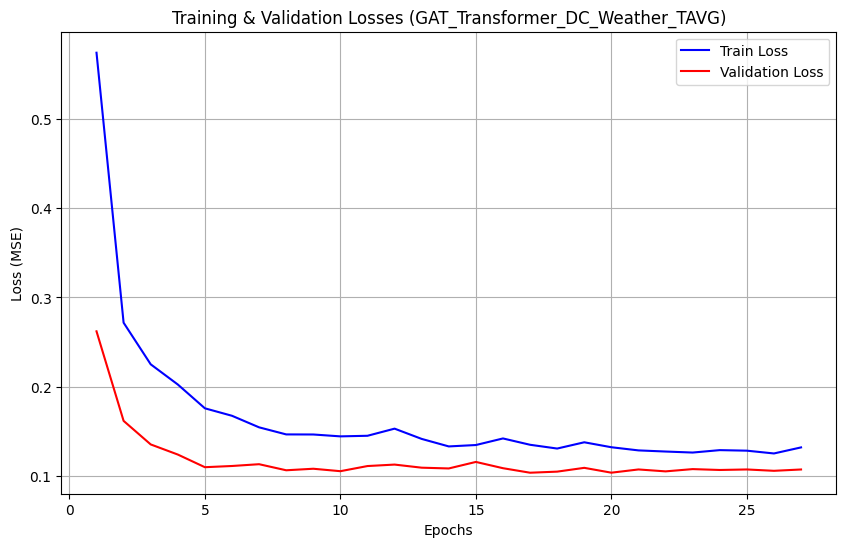


Evaluation metrics (GAT_Transformer_DC_Weather_TAVG):
 MSE: 7.1092, RMSE: 2.6663, MAE: 2.0318, R²: 0.9021


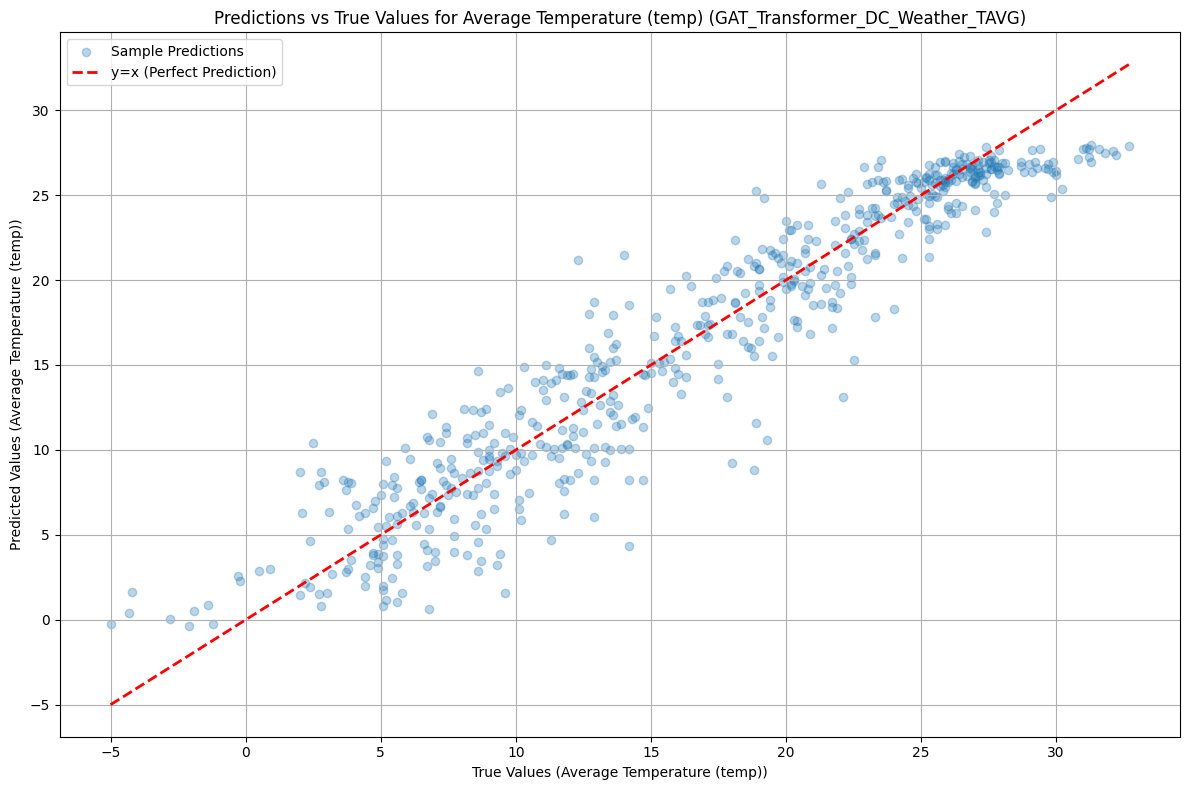

GAT_Transformer_DC_Weather_TAVG model training complete. Results in results_gat_transformer_dc_weather_tavg


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
import joblib

# --- Configuration ---
MODEL_NAME = "GAT_Transformer_DC_Weather_TAVG"
LOOKBACK = 365  # Using 30 days of weather data to predict the next day
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100 # Can be increased for better performance
PATIENCE = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Generic function to load tabular Multivariate Time Series data ---
def load_mts_data(data_df, feature_cols, target_cols, lookback_period):
    print(f"--- {MODEL_NAME}: Creating sequences from data ---")
    features = data_df[feature_cols].values
    targets = data_df[target_cols].values

    X_list = []
    y_list = []

    # Create sequences
    for i in range(lookback_period, len(data_df)):
        X_list.append(features[i - lookback_period : i])
        y_list.append(targets[i])

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"Loaded MTS data: X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# --- Chronological Train-Test Split ---
def chronological_train_test_split(X, y, test_ratio=0.2):
    num_samples = X.shape[0]
    num_test_samples = int(num_samples * test_ratio)
    split_index = num_samples - num_test_samples

    X_train = X[:split_index]
    y_train = y[:split_index]
    X_test = X[split_index:]
    y_test = y[split_index:]

    print(f"X_train shape ({MODEL_NAME}): {X_train.shape}")
    print(f"X_test shape ({MODEL_NAME}): {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

# --- TimeSeriesDataset for GAT (Optimized Adjacency) ---
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets, single_adj_matrix, scaler_X=None, scaler_y=None, is_train=True):
        original_shape = features.shape
        if is_train and scaler_X is None:
            self.scaler_X = StandardScaler()
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.fit_transform(flattened)
            self.features = scaled.reshape(original_shape)
        elif not is_train and scaler_X is not None:
            self.scaler_X = scaler_X
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.transform(flattened)
            self.features = scaled.reshape(original_shape)
        else: self.features = features; self.scaler_X = scaler_X
        
        if is_train and scaler_y is None:
            self.scaler_y = StandardScaler(); self.targets = self.scaler_y.fit_transform(targets)
        elif not is_train and scaler_y is not None:
            self.scaler_y = scaler_y; self.targets = self.scaler_y.transform(targets)
        else: self.targets = targets; self.scaler_y = scaler_y
        
        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)
        
        if not isinstance(single_adj_matrix, torch.Tensor):
            self.single_adj_matrix = torch.tensor(single_adj_matrix, dtype=torch.float32)
        else:
            self.single_adj_matrix = single_adj_matrix.to(dtype=torch.float32)

    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.single_adj_matrix, self.targets[idx]
    def get_scalers(self): return self.scaler_X, self.scaler_y

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term); pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0); self.register_buffer('pe', pe)
    def forward(self, x):
        pe_sliced = self.pe[:, :x.size(1)]
        try:
            result = x + pe_sliced
        except RuntimeError as e:
            print(f"ERROR during PositionalEncoding addition: x.shape={x.shape}, pe_sliced.shape={pe_sliced.shape}")
            raise e
        return result

# --- Graph Attention Layer & MultiHeadGraphAttention ---
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2, alpha=0.2):
        super(GraphAttentionLayer, self).__init__()
        self.in_features=in_features; self.out_features=out_features; self.dropout_val=dropout; self.alpha=alpha
        self.W=nn.Parameter(torch.empty(size=(in_features, out_features))); nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a=nn.Parameter(torch.empty(size=(2*out_features, 1))); nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu=nn.LeakyReLU(self.alpha); self.dropout_layer=nn.Dropout(self.dropout_val)
    def forward(self, h, adj):
        Wh=torch.matmul(h, self.W); a_input=self._prepare_attention_input(Wh)
        e=self.leakyrelu(torch.matmul(a_input, self.a).squeeze(-1))
        zero_vec = -9e15*torch.ones_like(e); attention_masked = torch.where(adj.unsqueeze(0) > 0, e, zero_vec)
        attention_softmax=F.softmax(attention_masked, dim=-1); attention_dropout=self.dropout_layer(attention_softmax)
        h_prime=torch.matmul(attention_dropout, Wh); return F.elu(h_prime)
    def _prepare_attention_input(self, Wh):
        B,N,_=Wh.size(); Wh_i=Wh.unsqueeze(2).expand(B,N,N,-1); Wh_j=Wh.unsqueeze(1).expand(B,N,N,-1)
        return torch.cat([Wh_i, Wh_j], dim=-1)

class MultiHeadGraphAttention(nn.Module):
    def __init__(self, in_features, out_features_per_head, n_heads, dropout=0.2, alpha=0.2, concat=True):
        super(MultiHeadGraphAttention, self).__init__()
        self.n_heads=n_heads; self.concat=concat
        self.attentions=nn.ModuleList([GraphAttentionLayer(in_features, out_features_per_head, dropout, alpha) for _ in range(n_heads)])
        self.out_dim = out_features_per_head * n_heads if concat else out_features_per_head
    def forward(self, x, adj):
        head_outputs=[att(x, adj) for att in self.attentions]
        if self.concat: return torch.cat(head_outputs, dim=-1)
        else: return torch.mean(torch.stack(head_outputs, dim=-1), dim=-1)

# --- GAT+Transformer Model ---
class MTSPredictorGATTransformer(nn.Module):
    def __init__(self, input_size, output_size, d_model_gat=64, gat_heads=4,
                 d_model_transformer=64, transformer_heads=4, num_transformer_layers=2,
                 dim_feedforward_transformer=256, dropout_rate=0.2):
        super(MTSPredictorGATTransformer, self).__init__()
        self.dropout_rate = dropout_rate
        self.gat_input_proj = nn.Linear(input_size, d_model_gat)
        self.gat_attention = MultiHeadGraphAttention(
            in_features=d_model_gat,
            out_features_per_head=d_model_gat // gat_heads,
            n_heads=gat_heads, dropout=dropout_rate, concat=True
        )
        gat_output_dim = self.gat_attention.out_dim
        self.pos_encoder = PositionalEncoding(gat_output_dim, max_len=LOOKBACK + 10) # max_len should be larger than LOOKBACK
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=gat_output_dim, nhead=transformer_heads, dim_feedforward=dim_feedforward_transformer,
            dropout=dropout_rate, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=num_transformer_layers)
        self.fc = nn.Sequential(
            nn.Linear(gat_output_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, output_size)
        )
    def forward(self, x, adj):
        x_proj = F.elu(self.gat_input_proj(x))
        x_gat_drop = F.dropout(x_proj, self.dropout_rate, training=self.training)
        x_gat_attended = self.gat_attention(x_gat_drop, adj)

        if x_gat_attended.dim() == 4 and x_gat_attended.shape[0] == 1: # Handling potential batching issue
             x_gat_attended = x_gat_attended.squeeze(0)

        x_pos_encoded = self.pos_encoder(x_gat_attended)
        x_transformed = self.transformer_encoder(x_pos_encoded)
        x_last_step = x_transformed[:, -1, :]
        output = self.fc(x_last_step)
        return output

# --- Training Function ---
def train_model_gat_based(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device, model_save_name):
    best_val_loss = float('inf'); epochs_no_improve = 0
    train_losses_history, val_losses_history = [], []
    for epoch in range(num_epochs):
        model.train(); epoch_train_loss = 0
        for batch_X, batch_adj_single, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
            outputs = model(batch_X, batch_adj_single[0]);
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad(); loss.backward(); optimizer.step(); epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader); train_losses_history.append(epoch_train_loss)
        
        model.eval(); epoch_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_adj_single, batch_y in val_loader:
                batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
                outputs = model(batch_X, batch_adj_single[0])
                loss = criterion(outputs, batch_y); epoch_val_loss += loss.item()
        epoch_val_loss /= len(val_loader); val_losses_history.append(epoch_val_loss)
        print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss; epochs_no_improve = 0; torch.save(model.state_dict(), model_save_name)
        else: epochs_no_improve += 1
        if epochs_no_improve >= patience: print(f"Early stopping @ epoch {epoch+1}"); break
    
    if os.path.exists(model_save_name): model.load_state_dict(torch.load(model_save_name))
    return model, train_losses_history, val_losses_history

# --- Evaluation Function ---
def evaluate_model_gat_based(model, test_loader, scaler_y, device, model_name="GAT-based Model"):
    model.eval(); all_preds_s, all_targets_s = [], []
    with torch.no_grad():
        for batch_X, batch_adj_single, batch_y_s in test_loader:
            batch_X, batch_adj_single = batch_X.to(device), batch_adj_single.to(device)
            outputs_s = model(batch_X, batch_adj_single[0])
            all_preds_s.append(outputs_s.cpu().numpy()); all_targets_s.append(batch_y_s.numpy())
    preds_s_np = np.vstack(all_preds_s); tgts_s_np = np.vstack(all_targets_s)
    
    if scaler_y: preds_o = scaler_y.inverse_transform(preds_s_np); tgts_o = scaler_y.inverse_transform(tgts_s_np)
    else: preds_o = preds_s_np; tgts_o = tgts_s_np
    
    mse=mean_squared_error(tgts_o,preds_o); rmse=np.sqrt(mse); r2=r2_score(tgts_o,preds_o); mae=mean_absolute_error(tgts_o,preds_o)
    print(f"\nEvaluation metrics ({model_name}):\n MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return preds_o, tgts_o, mse, rmse, r2, mae

# --- Plotting Functions ---
def plot_training_losses(train_losses, val_losses, model_name, save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'training_losses_{model_name}.png')
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss (MSE)'); plt.title(f'Training & Validation Losses ({model_name})')
    plt.legend(); plt.grid(True); plt.savefig(save_path); plt.show()

def plot_predictions_vs_true(targets_original, predictions_original, model_name, target_name="TAVG", save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'predictions_vs_true_{model_name}.png')

    plt.figure(figsize=(12, 8))
    plt.scatter(targets_original, predictions_original, alpha=0.3, label='Sample Predictions')
    min_val = min(targets_original.min(), predictions_original.min())
    max_val = max(targets_original.max(), predictions_original.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x (Perfect Prediction)')

    plt.xlabel(f'True Values ({target_name})'); plt.ylabel(f'Predicted Values ({target_name})')
    plt.title(f'Predictions vs True Values for {target_name} ({model_name})')
    plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.savefig(save_path); plt.show()

# --- Main Function ---
def main_mts_forecaster():
    print(f"--- Running {MODEL_NAME} Model ---")
    print(f"Using device: {DEVICE}")
    output_dir = f"results_{MODEL_NAME.lower()}"
    viz_dir = os.path.join(output_dir, "visualizations")
    if not os.path.exists(viz_dir): os.makedirs(viz_dir)

    # --- Load and Preprocess Washington DC Weather Data ---
    # !!! USER ACTION: Make sure this path matches your downloaded file name !!!
    data_path = '/kaggle/input/washington-dc-historical-weather-20158202407/dc_weather.csv' # Or the actual name of your CSV
    if not os.path.exists(data_path):
        print(f"ERROR: Dataset not found at '{data_path}'")
        print("Please download it from Kaggle and place it in the same directory, then update the 'data_path' variable.")
        return

    print("Loading and preprocessing DC weather data...")
    df = pd.read_csv(data_path)
    # print("Columns in DataFrame:", df.columns) # You can keep this for debugging if needed

    # --- CORRECTED SECTION ---
    actual_date_column_name = 'datetime' # Corrected column name

    # Convert actual_date_column_name to datetime and set as index
    df[actual_date_column_name] = pd.to_datetime(df[actual_date_column_name])
    df.set_index(actual_date_column_name, inplace=True)
    
    # Select relevant columns for features and target, using new names
    # TAVG (average temp) is our target, likely 'temp' in your file
    # Other features: 'tempmax', 'tempmin', 'precip' (Precipitation), 'snow' (Snowfall), 
    # 'snowdepth' (Snow Depth), 'windspeed' (Average Wind Speed)
    
    # Updated relevant columns based on your DataFrame's column names
    relevant_cols = ['temp', 'tempmax', 'tempmin', 'precip', 'snow', 'snowdepth', 'windspeed']
    
    # Ensure all selected columns are numeric, coercing errors will turn non-convertible to NaN
    for col in relevant_cols:
        if col in df.columns: # Check if column exists before trying to convert
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            print(f"Warning: Column '{col}' not found in DataFrame. It will be ignored.")

    # Keep only the relevant columns that were found and are numeric
    # Filter relevant_cols to only include those present in df.columns to avoid KeyErrors
    existing_relevant_cols = [col for col in relevant_cols if col in df.columns]
    df_processed = df[existing_relevant_cols].copy()
    
    # Handle missing values - forward fill is a common strategy for time series
    df_processed.ffill(inplace=True)
    # In case any leading NaNs remain after ffill, bfill them
    df_processed.bfill(inplace=True) 
    
    # Check if any NaNs are left after filling
    if df_processed.isnull().sum().any():
        print("Warning: NaNs still present after ffill and bfill. Consider other imputation strategies.")
        print(df_processed.isnull().sum())
        df_processed.fillna(0, inplace=True) # Fallback to fill with 0, review if this is appropriate

    print(f"Data processed. Shape: {df_processed.shape}")
    print(df_processed.head())

    # Define feature and target columns using the corrected names
    feature_cols = existing_relevant_cols 
    target_cols = ['temp']       # We are forecasting 'temp' (average temperature)
    target_name_for_plot = "Average Temperature (temp)"

    # Check if the target column exists
    if target_cols[0] not in df_processed.columns:
        print(f"ERROR: Target column '{target_cols[0]}' not found in processed data. Available columns: {df_processed.columns}")
        return
    # --- END OF CORRECTED SECTION ---
    
    data_df = df_processed
    
    X_all, y_all = load_mts_data(data_df, feature_cols, target_cols, LOOKBACK)
    
    if X_all.shape[0] == 0: print("No valid samples generated. Exiting."); return
    
    X_tv, X_test, y_tv, y_test = chronological_train_test_split(X_all, y_all, test_ratio=0.2)
    
    if X_tv.shape[0] == 0: print(f"No training/validation samples for {MODEL_NAME}. Exiting."); return

    # Create the single temporal adjacency matrix for the LOOKBACK window
    adj_matrix_template = torch.zeros(LOOKBACK, LOOKBACK, dtype=torch.float32)
    for i in range(LOOKBACK):
        if i > 0: adj_matrix_template[i, i-1] = 1
        if i < LOOKBACK - 1: adj_matrix_template[i, i+1] = 1
        adj_matrix_template[i, i] = 1 # Self-loops
    adj_matrix_template = adj_matrix_template.to(DEVICE)
    
    tv_dataset = TimeSeriesDataset(X_tv, y_tv, adj_matrix_template.cpu(), is_train=True)
    scaler_X, scaler_y = tv_dataset.get_scalers()
    
    test_loader = None
    if X_test.shape[0] > 0:
        test_dataset = TimeSeriesDataset(X_test, y_test, adj_matrix_template.cpu(), scaler_X, scaler_y, is_train=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) 

    train_s = int(0.8 * len(tv_dataset)); val_s = len(tv_dataset) - train_s
    if val_s == 0 and train_s > 0:
        print("Warning: Validation set size is 0. Using training set for validation.")
        train_sub, val_sub = tv_dataset, tv_dataset 
    elif train_s == 0 or val_s == 0 : 
        print("Not enough data for train/val split. Exiting."); return
    else: 
        gen=torch.Generator().manual_seed(42); 
        train_sub, val_sub = torch.utils.data.random_split(tv_dataset, [train_s, val_s], generator=gen)

    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
   
    model_input_size = X_tv.shape[-1]
    model_output_size = y_tv.shape[-1]
    
    model = MTSPredictorGATTransformer(
        input_size=model_input_size, 
        output_size=model_output_size,
        d_model_gat=64, gat_heads=4,
        d_model_transformer=64, transformer_heads=4, num_transformer_layers=2,
        dim_feedforward_transformer=256, dropout_rate=0.2
    ).to(DEVICE)
    
    print(f"\n{MODEL_NAME} Model Architecture:\n{model}")
    criterion = nn.MSELoss(); optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-05)
   
    model_save_path = os.path.join(output_dir, f"best_mts_{MODEL_NAME.lower()}_model.pt")
    trained_model, train_L, val_L = train_model_gat_based(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, PATIENCE, DEVICE, model_save_path)
    plot_training_losses(train_L, val_L, MODEL_NAME, save_dir=viz_dir)
   
    if test_loader and X_test.shape[0] > 0 :
        preds_o, tgts_o, mse, rmse, r2, mae = evaluate_model_gat_based(trained_model, test_loader, scaler_y, DEVICE, MODEL_NAME)
        plot_predictions_vs_true(tgts_o, preds_o, MODEL_NAME, target_name=target_name_for_plot, save_dir=viz_dir) # Using target_name_for_plot
        np.savez_compressed(os.path.join(output_dir, f'{MODEL_NAME.lower()}_test_results.npz'), predictions=preds_o, targets=tgts_o)
    else: print(f"Test set for {MODEL_NAME} was empty or test_loader not created. Skipping final evaluation plot.")

    if scaler_X and scaler_y:
        joblib.dump(scaler_X, os.path.join(output_dir, f"scaler_X_{MODEL_NAME.lower()}.pkl"))
        joblib.dump(scaler_y, os.path.join(output_dir, f"scaler_y_{MODEL_NAME.lower()}.pkl"))
    print(f"{MODEL_NAME} model training complete. Results in {output_dir}")

if __name__ == "__main__":
    main_mts_forecaster()

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
import joblib
import itertools

# --- Configuration ---
MODEL_NAME = "GAT_Transformer_DC_Weather_TAVG"
LOOKBACK = 30  # Fixed lookback for all grid search runs
NUM_EPOCHS = 100 # Max epochs for each run
PATIENCE = 15    # Increased patience for early stopping
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Generic function to load tabular Multivariate Time Series data ---
def load_mts_data(data_df, feature_cols, target_cols, lookback_period):
    print(f"--- Creating sequences with lookback={lookback_period} ---")
    features = data_df[feature_cols].values
    targets = data_df[target_cols].values
    X_list, y_list = [], []
    for i in range(lookback_period, len(data_df)):
        X_list.append(features[i - lookback_period : i])
        y_list.append(targets[i])
    X, y = np.array(X_list), np.array(y_list)
    print(f"Loaded MTS data: X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# --- Chronological Train-Test Split ---
def chronological_train_test_split(X, y, test_ratio=0.2):
    num_samples = X.shape[0]
    num_test_samples = int(num_samples * test_ratio)
    split_index = num_samples - num_test_samples
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# --- TimeSeriesDataset for GAT (Optimized Adjacency) ---
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets, single_adj_matrix, scaler_X=None, scaler_y=None, is_train=True):
        original_shape = features.shape
        if is_train and scaler_X is None:
            self.scaler_X = StandardScaler()
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.fit_transform(flattened)
            self.features = scaled.reshape(original_shape)
        elif not is_train and scaler_X is not None:
            self.scaler_X = scaler_X
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.transform(flattened)
            self.features = scaled.reshape(original_shape)
        else: self.features, self.scaler_X = features, scaler_X
        if is_train and scaler_y is None:
            self.scaler_y = StandardScaler(); self.targets = self.scaler_y.fit_transform(targets)
        elif not is_train and scaler_y is not None:
            self.scaler_y = scaler_y; self.targets = self.scaler_y.transform(targets)
        else: self.targets, self.scaler_y = targets, scaler_y
        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)
        if not isinstance(single_adj_matrix, torch.Tensor):
            self.single_adj_matrix = torch.tensor(single_adj_matrix, dtype=torch.float32)
        else:
            self.single_adj_matrix = single_adj_matrix.to(dtype=torch.float32)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.single_adj_matrix, self.targets[idx]
    def get_scalers(self): return self.scaler_X, self.scaler_y

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term); pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0); self.register_buffer('pe', pe)
    def forward(self, x):
        pe_sliced = self.pe[:, :x.size(1), :]
        try:
            result = x + pe_sliced
        except RuntimeError as e:
            print(f"ERROR in PositionalEncoding: x.shape={x.shape}, pe_sliced.shape={pe_sliced.shape}")
            raise e
        return result

# --- Graph Attention Layer & MultiHeadGraphAttention ---
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2, alpha=0.2):
        super(GraphAttentionLayer, self).__init__()
        self.in_features=in_features; self.out_features=out_features; self.dropout_val=dropout; self.alpha=alpha
        self.W=nn.Parameter(torch.empty(size=(in_features, out_features))); nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a=nn.Parameter(torch.empty(size=(2*out_features, 1))); nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu=nn.LeakyReLU(self.alpha); self.dropout_layer=nn.Dropout(self.dropout_val)
    def forward(self, h, adj):
        Wh=torch.matmul(h, self.W); a_input=self._prepare_attention_input(Wh)
        e=self.leakyrelu(torch.matmul(a_input, self.a).squeeze(-1))
        zero_vec = -9e15*torch.ones_like(e); attention_masked = torch.where(adj.unsqueeze(0) > 0, e, zero_vec)
        attention_softmax=F.softmax(attention_masked, dim=-1); attention_dropout=self.dropout_layer(attention_softmax)
        h_prime=torch.matmul(attention_dropout, Wh); return F.elu(h_prime)
    def _prepare_attention_input(self, Wh):
        B,N,_=Wh.size(); Wh_i=Wh.unsqueeze(2).expand(B,N,N,-1); Wh_j=Wh.unsqueeze(1).expand(B,N,N,-1)
        return torch.cat([Wh_i, Wh_j], dim=-1)

class MultiHeadGraphAttention(nn.Module):
    def __init__(self, in_features, out_features_per_head, n_heads, dropout=0.2, alpha=0.2, concat=True):
        super(MultiHeadGraphAttention, self).__init__()
        self.n_heads=n_heads; self.concat=concat
        self.attentions=nn.ModuleList([GraphAttentionLayer(in_features, out_features_per_head, dropout, alpha) for _ in range(n_heads)])
        self.out_dim = out_features_per_head * n_heads if concat else out_features_per_head
    def forward(self, x, adj):
        head_outputs=[att(x, adj) for att in self.attentions]
        if self.concat: return torch.cat(head_outputs, dim=-1)
        else: return torch.mean(torch.stack(head_outputs, dim=-1), dim=-1)

# --- GAT+Transformer Model ---
class MTSPredictorGATTransformer(nn.Module):
    def __init__(self, input_size, output_size, d_model_gat=64, gat_heads=4,
                 d_model_transformer=64, transformer_heads=4, num_transformer_layers=2,
                 dim_feedforward_transformer=256, dropout_rate=0.2):
        super(MTSPredictorGATTransformer, self).__init__()
        self.dropout_rate = dropout_rate
        self.gat_input_proj = nn.Linear(input_size, d_model_gat)
        self.gat_attention = MultiHeadGraphAttention(
            in_features=d_model_gat, out_features_per_head=d_model_gat // gat_heads,
            n_heads=gat_heads, dropout=dropout_rate, concat=True)
        gat_output_dim = self.gat_attention.out_dim
        self.pos_encoder = PositionalEncoding(gat_output_dim, max_len=LOOKBACK + 100)
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=gat_output_dim, nhead=transformer_heads, dim_feedforward=dim_feedforward_transformer,
            dropout=dropout_rate, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=num_transformer_layers)
        self.fc = nn.Sequential(
            nn.Linear(gat_output_dim, 64), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(32, output_size))
    def forward(self, x, adj):
        x_proj = F.elu(self.gat_input_proj(x)); x_gat_drop = F.dropout(x_proj, self.dropout_rate, training=self.training)
        x_gat_attended = self.gat_attention(x_gat_drop, adj)
        if x_gat_attended.dim() == 4 and x_gat_attended.shape[0] == 1:
             x_gat_attended = x_gat_attended.squeeze(0)
        x_pos_encoded = self.pos_encoder(x_gat_attended); x_transformed = self.transformer_encoder(x_pos_encoded)
        x_last_step = x_transformed[:, -1, :]; output = self.fc(x_last_step)
        return output

# --- Training Function ---
def train_model_gat_based(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience, device, model_save_name):
    best_val_loss = float('inf'); epochs_no_improve = 0
    train_losses_history, val_losses_history = [], []
    for epoch in range(num_epochs):
        model.train(); epoch_train_loss = 0
        for batch_X, batch_adj_single, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
            outputs = model(batch_X, batch_adj_single[0]); loss = criterion(outputs, batch_y)
            optimizer.zero_grad(); loss.backward(); optimizer.step(); epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader); train_losses_history.append(epoch_train_loss)
        
        model.eval(); epoch_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_adj_single, batch_y in val_loader:
                batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
                outputs = model(batch_X, batch_adj_single[0]); loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()
        epoch_val_loss /= len(val_loader); val_losses_history.append(epoch_val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f}, LR={current_lr:.6f}")
        if scheduler: scheduler.step(epoch_val_loss)
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss; epochs_no_improve = 0
            if model_save_name: torch.save(model.state_dict(), model_save_name)
        else: epochs_no_improve += 1
        if epochs_no_improve >= patience: print(f"Early stopping @ epoch {epoch+1}"); break
    
    if model_save_name and os.path.exists(model_save_name): model.load_state_dict(torch.load(model_save_name))
    return model, train_losses_history, val_losses_history, best_val_loss

# --- Evaluation Function ---
def evaluate_model_gat_based(model, test_loader, scaler_y, device, model_name="GAT-based Model"):
    model.eval(); all_preds_s, all_targets_s = [], []
    with torch.no_grad():
        for batch_X, batch_adj_single, batch_y_s in test_loader:
            batch_X, batch_adj_single = batch_X.to(device), batch_adj_single.to(device)
            outputs_s = model(batch_X, batch_adj_single[0])
            all_preds_s.append(outputs_s.cpu().numpy()); all_targets_s.append(batch_y_s.cpu().numpy())
    preds_s_np = np.vstack(all_preds_s); tgts_s_np = np.vstack(all_targets_s)
    if scaler_y: preds_o = scaler_y.inverse_transform(preds_s_np); tgts_o = scaler_y.inverse_transform(tgts_s_np)
    else: preds_o, tgts_o = preds_s_np, tgts_s_np
    mse=mean_squared_error(tgts_o,preds_o); rmse=np.sqrt(mse); r2=r2_score(tgts_o,preds_o); mae=mean_absolute_error(tgts_o,preds_o)
    print(f"\nEvaluation metrics ({model_name}):\n MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return preds_o, tgts_o, mse, rmse, r2, mae

# --- Plotting Functions ---
def plot_training_losses(train_losses, val_losses, model_name, save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'training_losses_{model_name}.png')
    plt.figure(figsize=(10, 6)); plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss (MSE)'); plt.title(f'Training & Validation Losses ({model_name})')
    plt.legend(); plt.grid(True); plt.savefig(save_path); plt.close()

def plot_predictions_vs_true(targets_original, predictions_original, model_name, target_name="Target", save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'predictions_vs_true_{model_name}.png')
    plt.figure(figsize=(12, 8)); plt.scatter(targets_original, predictions_original, alpha=0.3, label='Sample Predictions')
    min_val = min(targets_original.ravel().min(), predictions_original.ravel().min())
    max_val = max(targets_original.ravel().max(), predictions_original.ravel().max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x (Perfect Prediction)')
    plt.xlabel(f'True Values ({target_name})'); plt.ylabel(f'Predicted Values ({target_name})')
    plt.title(f'Predictions vs True Values for {target_name} ({model_name})')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig(save_path); plt.close()

# --- New Function to run a single training session for grid search ---
def run_training_session(params, train_dataset, val_dataset, adj_matrix_template, model_input_size, model_output_size, output_dir):
    print(f"\n--- Running with params: {params} ---")
    lr, dropout_rate, weight_decay, batch_size = params['LEARNING_RATE'], params['DROPOUT_RATE'], params['WEIGHT_DECAY'], params['BATCH_SIZE']
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    model = MTSPredictorGATTransformer(
        input_size=model_input_size, output_size=model_output_size, dropout_rate=dropout_rate).to(DEVICE)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, verbose=False)
    
    param_str = "_".join([f"{k}_{v}" for k, v in params.items()])
    model_save_name = os.path.join(output_dir, f"best_model_{param_str}.pt")
    
    _, _, _, best_val_loss = train_model_gat_based(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        NUM_EPOCHS, PATIENCE, DEVICE, model_save_name
    )
    return best_val_loss

# --- Main Function ---
# --- Main Function ---
def main_mts_forecaster():
    print(f"--- Running {MODEL_NAME} Grid Search ---")
    print(f"Using device: {DEVICE}")
    output_dir = f"results_{MODEL_NAME.lower()}_grid_search"
    viz_dir = os.path.join(output_dir, "visualizations")
    if not os.path.exists(viz_dir): os.makedirs(viz_dir)

    # --- 1. DEFINE HYPERPARAMETER GRID ---
    param_grid = {
        'LEARNING_RATE': [0.001, 0.0005],
        'DROPOUT_RATE': [0.2, 0.4],
        'WEIGHT_DECAY': [1e-5, 1e-4],
        'BATCH_SIZE': [64, 128]
    }
    print("--- Hyperparameter Grid ---"); print(param_grid)

    # --- 2. LOAD AND PREPROCESS DATA ONCE ---
    data_path = '/kaggle/input/washington-dc-historical-weather-20158202407/dc_weather.csv'
    if not os.path.exists(data_path): print(f"ERROR: Dataset not found at '{data_path}'"); return
    
    print("Loading and preprocessing DC weather data...")
    df = pd.read_csv(data_path)
    if 'datetime' not in df.columns: print("ERROR: 'datetime' column not found."); return
    df['datetime'] = pd.to_datetime(df['datetime']); df.set_index('datetime', inplace=True)
    
    feature_cols = ['temp', 'tempmax', 'tempmin', 'precip', 'snow', 'snowdepth', 'windspeed']
    target_cols = ['temp'] # Predicting average temperature
    target_name_for_plot = "Average Temperature (temp)"
    
    existing_cols = [col for col in feature_cols if col in df.columns]
    df_processed = df[existing_cols].copy()
    for col in df_processed.columns: df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.ffill(inplace=True); df_processed.bfill(inplace=True)
    if df_processed.isnull().sum().any(): df_processed.fillna(0, inplace=True)

    X_all, y_all = load_mts_data(df_processed, existing_cols, target_cols, LOOKBACK)
    if X_all.shape[0] == 0: print("No valid samples generated. Exiting."); return
    
    X_tv_and_val, X_test, y_tv_and_val, y_test = chronological_train_test_split(X_all, y_all, test_ratio=0.2)
    if X_tv_and_val.shape[0] == 0: print("No training/validation samples. Exiting."); return

    # --- 3. CREATE DATASETS ONCE ---
    adj_matrix_template = torch.zeros(LOOKBACK, LOOKBACK, dtype=torch.float32)
    for i in range(LOOKBACK):
        if i > 0: adj_matrix_template[i, i-1] = 1
        if i < LOOKBACK - 1: adj_matrix_template[i, i+1] = 1
        adj_matrix_template[i, i] = 1
    adj_matrix_template = adj_matrix_template.to(DEVICE)

    full_train_val_dataset = TimeSeriesDataset(X_tv_and_val, y_tv_and_val, adj_matrix_template.cpu(), is_train=True)
    scaler_X, scaler_y = full_train_val_dataset.get_scalers()

    train_s = int(0.8 * len(full_train_val_dataset)); val_s = len(full_train_val_dataset) - train_s
    gen = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = torch.utils.data.random_split(full_train_val_dataset, [train_s, val_s], generator=gen)

    # --- 4. RUN GRID SEARCH LOOP ---
    best_params = {}; best_val_loss = float('inf')
    param_combinations = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    for params in param_combinations:
        val_loss = run_training_session(
            params=params, train_dataset=train_dataset, val_dataset=val_dataset,
            adj_matrix_template=adj_matrix_template, model_input_size=X_all.shape[-1],
            model_output_size=y_all.shape[-1], output_dir=output_dir
        )
        if val_loss < best_val_loss:
            best_val_loss = val_loss; best_params = params
            print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"!!! New best validation loss: {best_val_loss:.4f} with params: {best_params}")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")

    print(f"\n--- Grid Search Complete ---")
    print(f"Best validation loss found: {best_val_loss:.4f}")
    print(f"Best hyperparameters: {best_params}")

    # --- 5. FINAL EVALUATION WITH BEST HYPERPARAMETERS ---
    print("\n--- Training final model with best hyperparameters on all training data ---")
    
    final_model = MTSPredictorGATTransformer(
        input_size=X_all.shape[-1], output_size=y_all.shape[-1],
        dropout_rate=best_params.get('DROPOUT_RATE', 0.2)
    ).to(DEVICE)
    
    final_optimizer = optim.Adam(
        final_model.parameters(), 
        lr=best_params.get('LEARNING_RATE', 0.001), 
        weight_decay=best_params.get('WEIGHT_DECAY', 1e-5)
    )
    # --- FIX WAS HERE ---
    final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, 'min', patience=7, verbose=True)
    # --- END OF FIX ---
    
    final_criterion = nn.MSELoss()
    
    final_train_loader = DataLoader(full_train_val_dataset, batch_size=best_params.get('BATCH_SIZE', 128), shuffle=True)
    final_val_loader = DataLoader(val_dataset, batch_size=best_params.get('BATCH_SIZE', 128), shuffle=False)
    
    final_model_save_path = os.path.join(output_dir, "final_best_model.pt")
    
    print("Starting final training run...")
    trained_model, train_L, val_L, _ = train_model_gat_based(
        final_model, final_train_loader, final_val_loader, final_criterion, final_optimizer, final_scheduler,
        NUM_EPOCHS, PATIENCE, DEVICE, final_model_save_path
    )
    plot_training_losses(train_L, val_L, f"{MODEL_NAME}_final", save_dir=viz_dir)
   
    if X_test.shape[0] > 0:
        print("\n--- Evaluating final model on test set ---")
        test_dataset = TimeSeriesDataset(X_test, y_test, adj_matrix_template.cpu(), scaler_X, scaler_y, is_train=False)
        test_loader = DataLoader(test_dataset, batch_size=best_params.get('BATCH_SIZE', 128), shuffle=False)
        preds_o, tgts_o, _, _, _, _ = evaluate_model_gat_based(trained_model, test_loader, scaler_y, DEVICE, f"{MODEL_NAME}_final")
        plot_predictions_vs_true(tgts_o, preds_o, f"{MODEL_NAME}_final", target_name=target_name_for_plot, save_dir=viz_dir)
    else: print("Test set was empty. Skipping final evaluation.")

    print(f"Grid search and final evaluation complete. Results in {output_dir}")
if __name__ == "__main__":
    main_mts_forecaster()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--- Running GAT_Transformer_DC_Weather_TAVG Grid Search ---
Using device: cpu
--- Hyperparameter Grid ---
{'LEARNING_RATE': [0.001, 0.0005], 'DROPOUT_RATE': [0.2, 0.4], 'WEIGHT_DECAY': [1e-05, 0.0001], 'BATCH_SIZE': [64, 128]}
Loading and preprocessing DC weather data...
--- Creating sequences with lookback=30 ---
Loaded MTS data: X shape: (3289, 30, 7), y shape: (3289, 1)
X_train shape: (2632, 30, 7), X_test shape: (657, 30, 7)

--- Running with params: {'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 64} ---


Epoch 1/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.36it/s]


Epoch 1: Train Loss=0.3716, Val Loss=0.1580, LR=0.001000


Epoch 2/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.53it/s]


Epoch 2: Train Loss=0.2077, Val Loss=0.1227, LR=0.001000


Epoch 3/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.93it/s]


Epoch 3: Train Loss=0.1778, Val Loss=0.1145, LR=0.001000


Epoch 4/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.95it/s]


Epoch 4: Train Loss=0.1676, Val Loss=0.1064, LR=0.001000


Epoch 5/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.52it/s]


Epoch 5: Train Loss=0.1671, Val Loss=0.1014, LR=0.001000


Epoch 6/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.53it/s]


Epoch 6: Train Loss=0.1630, Val Loss=0.1075, LR=0.001000


Epoch 7/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.71it/s]


Epoch 7: Train Loss=0.1600, Val Loss=0.1057, LR=0.001000


Epoch 8/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.78it/s]


Epoch 8: Train Loss=0.1566, Val Loss=0.1070, LR=0.001000


Epoch 9/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.84it/s]


Epoch 9: Train Loss=0.1538, Val Loss=0.1197, LR=0.001000


Epoch 10/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.51it/s]


Epoch 10: Train Loss=0.1498, Val Loss=0.1039, LR=0.001000


Epoch 11/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.86it/s]


Epoch 11: Train Loss=0.1425, Val Loss=0.0989, LR=0.001000


Epoch 12/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.62it/s]


Epoch 12: Train Loss=0.1430, Val Loss=0.1002, LR=0.001000


Epoch 13/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.66it/s]


Epoch 13: Train Loss=0.1389, Val Loss=0.1028, LR=0.001000


Epoch 14/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.91it/s]


Epoch 14: Train Loss=0.1419, Val Loss=0.0940, LR=0.001000


Epoch 15/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.49it/s]


Epoch 15: Train Loss=0.1439, Val Loss=0.1008, LR=0.001000


Epoch 16/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.65it/s]


Epoch 16: Train Loss=0.1437, Val Loss=0.1008, LR=0.001000


Epoch 17/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.38it/s]


Epoch 17: Train Loss=0.1367, Val Loss=0.0942, LR=0.001000


Epoch 18/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.83it/s]


Epoch 18: Train Loss=0.1350, Val Loss=0.0932, LR=0.001000


Epoch 19/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.56it/s]


Epoch 19: Train Loss=0.1408, Val Loss=0.1057, LR=0.001000


Epoch 20/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.83it/s]


Epoch 20: Train Loss=0.1342, Val Loss=0.0949, LR=0.001000


Epoch 21/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.22it/s]


Epoch 21: Train Loss=0.1315, Val Loss=0.0919, LR=0.001000


Epoch 22/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 12.83it/s]


Epoch 22: Train Loss=0.1244, Val Loss=0.0942, LR=0.001000


Epoch 23/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.30it/s]


Epoch 23: Train Loss=0.1294, Val Loss=0.0913, LR=0.001000


Epoch 24/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.80it/s]


Epoch 24: Train Loss=0.1294, Val Loss=0.1029, LR=0.001000


Epoch 25/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.60it/s]


Epoch 25: Train Loss=0.1355, Val Loss=0.0863, LR=0.001000


Epoch 26/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.29it/s]


Epoch 26: Train Loss=0.1240, Val Loss=0.1102, LR=0.001000


Epoch 27/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.69it/s]


Epoch 27: Train Loss=0.1391, Val Loss=0.0953, LR=0.001000


Epoch 28/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.14it/s]


Epoch 28: Train Loss=0.1249, Val Loss=0.0897, LR=0.001000


Epoch 29/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.07it/s]


Epoch 29: Train Loss=0.1241, Val Loss=0.0963, LR=0.001000


Epoch 30/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.09it/s]


Epoch 30: Train Loss=0.1293, Val Loss=0.1019, LR=0.001000


Epoch 31/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.63it/s]


Epoch 31: Train Loss=0.1187, Val Loss=0.0962, LR=0.001000


Epoch 32/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.92it/s]


Epoch 32: Train Loss=0.1176, Val Loss=0.1067, LR=0.001000


Epoch 33/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.75it/s]


Epoch 33: Train Loss=0.1259, Val Loss=0.1051, LR=0.001000


Epoch 34/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.98it/s]


Epoch 34: Train Loss=0.1108, Val Loss=0.0926, LR=0.000100


Epoch 35/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.44it/s]


Epoch 35: Train Loss=0.1151, Val Loss=0.0928, LR=0.000100


Epoch 36/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.76it/s]


Epoch 36: Train Loss=0.1156, Val Loss=0.0934, LR=0.000100


Epoch 37/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.60it/s]


Epoch 37: Train Loss=0.1153, Val Loss=0.0925, LR=0.000100


Epoch 38/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.41it/s]


Epoch 38: Train Loss=0.1128, Val Loss=0.0934, LR=0.000100


Epoch 39/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.06it/s]


Epoch 39: Train Loss=0.1096, Val Loss=0.0928, LR=0.000100


Epoch 40/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.87it/s]


Epoch 40: Train Loss=0.1102, Val Loss=0.0931, LR=0.000100
Early stopping @ epoch 40

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! New best validation loss: 0.0863 with params: {'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 64}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


--- Running with params: {'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 128} ---


Epoch 1/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.92it/s]


Epoch 1: Train Loss=0.3725, Val Loss=0.1773, LR=0.001000


Epoch 2/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.92it/s]


Epoch 2: Train Loss=0.2353, Val Loss=0.1286, LR=0.001000


Epoch 3/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.01it/s]


Epoch 3: Train Loss=0.2026, Val Loss=0.1233, LR=0.001000


Epoch 4/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.16it/s]


Epoch 4: Train Loss=0.1880, Val Loss=0.1140, LR=0.001000


Epoch 5/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.36it/s]


Epoch 5: Train Loss=0.1689, Val Loss=0.1117, LR=0.001000


Epoch 6/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.66it/s]


Epoch 6: Train Loss=0.1642, Val Loss=0.1058, LR=0.001000


Epoch 7/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s]


Epoch 7: Train Loss=0.1645, Val Loss=0.1048, LR=0.001000


Epoch 8/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.37it/s]


Epoch 8: Train Loss=0.1619, Val Loss=0.0996, LR=0.001000


Epoch 9/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.01it/s]


Epoch 9: Train Loss=0.1549, Val Loss=0.0979, LR=0.001000


Epoch 10/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.68it/s]


Epoch 10: Train Loss=0.1610, Val Loss=0.0984, LR=0.001000


Epoch 11/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.97it/s]


Epoch 11: Train Loss=0.1564, Val Loss=0.1010, LR=0.001000


Epoch 12/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.92it/s]


Epoch 12: Train Loss=0.1460, Val Loss=0.0965, LR=0.001000


Epoch 13/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  6.59it/s]


Epoch 13: Train Loss=0.1492, Val Loss=0.0972, LR=0.001000


Epoch 14/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.15it/s]


Epoch 14: Train Loss=0.1470, Val Loss=0.0974, LR=0.001000


Epoch 15/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.98it/s]


Epoch 15: Train Loss=0.1416, Val Loss=0.1067, LR=0.001000


Epoch 16/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.35it/s]


Epoch 16: Train Loss=0.1419, Val Loss=0.0949, LR=0.001000


Epoch 17/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.49it/s]


Epoch 17: Train Loss=0.1407, Val Loss=0.0939, LR=0.001000


Epoch 18/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.88it/s]


Epoch 18: Train Loss=0.1423, Val Loss=0.1080, LR=0.001000


Epoch 19/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.94it/s]


Epoch 19: Train Loss=0.1425, Val Loss=0.0891, LR=0.001000


Epoch 20/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.01it/s]


Epoch 20: Train Loss=0.1344, Val Loss=0.1160, LR=0.001000


Epoch 21/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.08it/s]


Epoch 21: Train Loss=0.1435, Val Loss=0.0893, LR=0.001000


Epoch 22/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.19it/s]


Epoch 22: Train Loss=0.1369, Val Loss=0.1099, LR=0.001000


Epoch 23/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.93it/s]


Epoch 23: Train Loss=0.1367, Val Loss=0.0956, LR=0.001000


Epoch 24/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.04it/s]


Epoch 24: Train Loss=0.1387, Val Loss=0.0907, LR=0.001000


Epoch 25/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s]


Epoch 25: Train Loss=0.1347, Val Loss=0.0891, LR=0.001000


Epoch 26/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s]


Epoch 26: Train Loss=0.1383, Val Loss=0.1048, LR=0.001000


Epoch 27/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


Epoch 27: Train Loss=0.1314, Val Loss=0.0886, LR=0.001000


Epoch 28/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.00it/s]


Epoch 28: Train Loss=0.1364, Val Loss=0.0953, LR=0.001000


Epoch 29/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.37it/s]


Epoch 29: Train Loss=0.1318, Val Loss=0.0900, LR=0.001000


Epoch 30/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.79it/s]


Epoch 30: Train Loss=0.1316, Val Loss=0.1016, LR=0.001000


Epoch 31/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.92it/s]


Epoch 31: Train Loss=0.1280, Val Loss=0.0872, LR=0.001000


Epoch 32/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.56it/s]


Epoch 32: Train Loss=0.1287, Val Loss=0.0983, LR=0.001000


Epoch 33/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.90it/s]


Epoch 33: Train Loss=0.1235, Val Loss=0.0888, LR=0.001000


Epoch 34/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.84it/s]


Epoch 34: Train Loss=0.1280, Val Loss=0.1000, LR=0.001000


Epoch 35/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.87it/s]


Epoch 35: Train Loss=0.1236, Val Loss=0.0912, LR=0.001000


Epoch 36/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.59it/s]


Epoch 36: Train Loss=0.1273, Val Loss=0.1060, LR=0.001000


Epoch 37/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.30it/s]


Epoch 37: Train Loss=0.1210, Val Loss=0.0862, LR=0.001000


Epoch 38/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.86it/s]


Epoch 38: Train Loss=0.1231, Val Loss=0.0977, LR=0.001000


Epoch 39/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.53it/s]


Epoch 39: Train Loss=0.1208, Val Loss=0.0860, LR=0.001000


Epoch 40/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.19it/s]


Epoch 40: Train Loss=0.1177, Val Loss=0.0844, LR=0.001000


Epoch 41/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.25it/s]


Epoch 41: Train Loss=0.1214, Val Loss=0.0946, LR=0.001000


Epoch 42/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.95it/s]


Epoch 42: Train Loss=0.1212, Val Loss=0.0890, LR=0.001000


Epoch 43/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.88it/s]


Epoch 43: Train Loss=0.1174, Val Loss=0.0882, LR=0.001000


Epoch 44/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.93it/s]


Epoch 44: Train Loss=0.1184, Val Loss=0.0865, LR=0.001000


Epoch 45/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.78it/s]


Epoch 45: Train Loss=0.1207, Val Loss=0.0946, LR=0.001000


Epoch 46/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.14it/s]


Epoch 46: Train Loss=0.1171, Val Loss=0.0906, LR=0.001000


Epoch 47/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.17it/s]


Epoch 47: Train Loss=0.1185, Val Loss=0.0903, LR=0.001000


Epoch 48/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.65it/s]


Epoch 48: Train Loss=0.1173, Val Loss=0.1055, LR=0.001000


Epoch 49/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.89it/s]


Epoch 49: Train Loss=0.1137, Val Loss=0.0878, LR=0.000100


Epoch 50/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s]


Epoch 50: Train Loss=0.1133, Val Loss=0.0880, LR=0.000100


Epoch 51/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.01it/s]


Epoch 51: Train Loss=0.1117, Val Loss=0.0861, LR=0.000100


Epoch 52/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.99it/s]


Epoch 52: Train Loss=0.1129, Val Loss=0.0870, LR=0.000100


Epoch 53/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.84it/s]


Epoch 53: Train Loss=0.1121, Val Loss=0.0881, LR=0.000100


Epoch 54/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.46it/s]


Epoch 54: Train Loss=0.1078, Val Loss=0.0860, LR=0.000100


Epoch 55/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.08it/s]


Epoch 55: Train Loss=0.1080, Val Loss=0.0864, LR=0.000100
Early stopping @ epoch 55

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! New best validation loss: 0.0844 with params: {'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 128}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


--- Running with params: {'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'BATCH_SIZE': 64} ---


Epoch 1/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.14it/s]


Epoch 1: Train Loss=0.4331, Val Loss=0.1954, LR=0.001000


Epoch 2/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.86it/s]


Epoch 2: Train Loss=0.2276, Val Loss=0.1217, LR=0.001000


Epoch 3/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.06it/s]


Epoch 3: Train Loss=0.1941, Val Loss=0.1180, LR=0.001000


Epoch 4/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.96it/s]


Epoch 4: Train Loss=0.1881, Val Loss=0.1301, LR=0.001000


Epoch 5/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.42it/s]


Epoch 5: Train Loss=0.1634, Val Loss=0.1036, LR=0.001000


Epoch 6/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 13.73it/s]


Epoch 6: Train Loss=0.1593, Val Loss=0.1038, LR=0.001000


Epoch 7/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.81it/s]


Epoch 7: Train Loss=0.1533, Val Loss=0.1056, LR=0.001000


Epoch 8/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.60it/s]


Epoch 8: Train Loss=0.1626, Val Loss=0.1156, LR=0.001000


Epoch 9/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.96it/s]


Epoch 9: Train Loss=0.1576, Val Loss=0.0966, LR=0.001000


Epoch 10/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.77it/s]


Epoch 10: Train Loss=0.1540, Val Loss=0.1358, LR=0.001000


Epoch 11/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.64it/s]


Epoch 11: Train Loss=0.1521, Val Loss=0.0962, LR=0.001000


Epoch 12/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.60it/s]


Epoch 12: Train Loss=0.1466, Val Loss=0.0981, LR=0.001000


Epoch 13/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.26it/s]


Epoch 13: Train Loss=0.1397, Val Loss=0.1104, LR=0.001000


Epoch 14/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.70it/s]


Epoch 14: Train Loss=0.1417, Val Loss=0.0982, LR=0.001000


Epoch 15/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.56it/s]


Epoch 15: Train Loss=0.1327, Val Loss=0.0957, LR=0.001000


Epoch 16/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.49it/s]


Epoch 16: Train Loss=0.1417, Val Loss=0.0970, LR=0.001000


Epoch 17/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.31it/s]


Epoch 17: Train Loss=0.1319, Val Loss=0.0945, LR=0.001000


Epoch 18/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.70it/s]


Epoch 18: Train Loss=0.1338, Val Loss=0.0935, LR=0.001000


Epoch 19/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.08it/s]


Epoch 19: Train Loss=0.1398, Val Loss=0.1134, LR=0.001000


Epoch 20/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.30it/s]


Epoch 20: Train Loss=0.1364, Val Loss=0.1052, LR=0.001000


Epoch 21/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 12.96it/s]


Epoch 21: Train Loss=0.1421, Val Loss=0.0957, LR=0.001000


Epoch 22/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.37it/s]


Epoch 22: Train Loss=0.1338, Val Loss=0.1188, LR=0.001000


Epoch 23/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.73it/s]


Epoch 23: Train Loss=0.1271, Val Loss=0.0937, LR=0.001000


Epoch 24/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.88it/s]


Epoch 24: Train Loss=0.1385, Val Loss=0.1034, LR=0.001000


Epoch 25/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.71it/s]


Epoch 25: Train Loss=0.1297, Val Loss=0.1013, LR=0.001000


Epoch 26/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.85it/s]


Epoch 26: Train Loss=0.1273, Val Loss=0.0944, LR=0.001000


Epoch 27/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.84it/s]


Epoch 27: Train Loss=0.1246, Val Loss=0.0890, LR=0.000100


Epoch 28/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.83it/s]


Epoch 28: Train Loss=0.1235, Val Loss=0.0900, LR=0.000100


Epoch 29/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.83it/s]


Epoch 29: Train Loss=0.1189, Val Loss=0.0910, LR=0.000100


Epoch 30/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.79it/s]


Epoch 30: Train Loss=0.1220, Val Loss=0.0896, LR=0.000100


Epoch 31/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.39it/s]


Epoch 31: Train Loss=0.1168, Val Loss=0.0906, LR=0.000100


Epoch 32/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.03it/s]


Epoch 32: Train Loss=0.1246, Val Loss=0.0887, LR=0.000100


Epoch 33/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.64it/s]


Epoch 33: Train Loss=0.1286, Val Loss=0.0915, LR=0.000100


Epoch 34/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.92it/s]


Epoch 34: Train Loss=0.1205, Val Loss=0.0905, LR=0.000100


Epoch 35/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.05it/s]


Epoch 35: Train Loss=0.1193, Val Loss=0.0897, LR=0.000100


Epoch 36/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 13.95it/s]


Epoch 36: Train Loss=0.1146, Val Loss=0.0888, LR=0.000100


Epoch 37/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.69it/s]


Epoch 37: Train Loss=0.1178, Val Loss=0.0915, LR=0.000100


Epoch 38/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.16it/s]


Epoch 38: Train Loss=0.1184, Val Loss=0.0889, LR=0.000100


Epoch 39/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.55it/s]


Epoch 39: Train Loss=0.1172, Val Loss=0.0887, LR=0.000100


Epoch 40/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.43it/s]


Epoch 40: Train Loss=0.1172, Val Loss=0.0882, LR=0.000100


Epoch 41/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.46it/s]


Epoch 41: Train Loss=0.1177, Val Loss=0.0894, LR=0.000100


Epoch 42/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.91it/s]


Epoch 42: Train Loss=0.1137, Val Loss=0.0895, LR=0.000100


Epoch 43/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.60it/s]


Epoch 43: Train Loss=0.1186, Val Loss=0.0894, LR=0.000100


Epoch 44/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.33it/s]


Epoch 44: Train Loss=0.1158, Val Loss=0.0916, LR=0.000100


Epoch 45/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.11it/s]


Epoch 45: Train Loss=0.1201, Val Loss=0.0898, LR=0.000100


Epoch 46/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.95it/s]


Epoch 46: Train Loss=0.1178, Val Loss=0.0916, LR=0.000100


Epoch 47/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.72it/s]


Epoch 47: Train Loss=0.1176, Val Loss=0.0905, LR=0.000100


Epoch 48/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.93it/s]


Epoch 48: Train Loss=0.1161, Val Loss=0.0900, LR=0.000100


Epoch 49/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.68it/s]


Epoch 49: Train Loss=0.1134, Val Loss=0.0897, LR=0.000010


Epoch 50/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.74it/s]


Epoch 50: Train Loss=0.1233, Val Loss=0.0898, LR=0.000010


Epoch 51/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.72it/s]


Epoch 51: Train Loss=0.1198, Val Loss=0.0897, LR=0.000010


Epoch 52/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.70it/s]


Epoch 52: Train Loss=0.1167, Val Loss=0.0894, LR=0.000010


Epoch 53/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.96it/s]


Epoch 53: Train Loss=0.1172, Val Loss=0.0890, LR=0.000010


Epoch 54/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.55it/s]


Epoch 54: Train Loss=0.1166, Val Loss=0.0891, LR=0.000010


Epoch 55/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.14it/s]


Epoch 55: Train Loss=0.1158, Val Loss=0.0890, LR=0.000010
Early stopping @ epoch 55

--- Running with params: {'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'BATCH_SIZE': 128} ---


Epoch 1/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.35it/s]


Epoch 1: Train Loss=0.4097, Val Loss=0.1669, LR=0.001000


Epoch 2/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.13it/s]


Epoch 2: Train Loss=0.2295, Val Loss=0.1245, LR=0.001000


Epoch 3/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.00it/s]


Epoch 3: Train Loss=0.1919, Val Loss=0.1357, LR=0.001000


Epoch 4/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.88it/s]


Epoch 4: Train Loss=0.1891, Val Loss=0.1089, LR=0.001000


Epoch 5/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.96it/s]


Epoch 5: Train Loss=0.1712, Val Loss=0.1125, LR=0.001000


Epoch 6/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.41it/s]


Epoch 6: Train Loss=0.1660, Val Loss=0.1017, LR=0.001000


Epoch 7/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.29it/s]


Epoch 7: Train Loss=0.1670, Val Loss=0.1105, LR=0.001000


Epoch 8/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.97it/s]


Epoch 8: Train Loss=0.1589, Val Loss=0.1054, LR=0.001000


Epoch 9/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Epoch 9: Train Loss=0.1617, Val Loss=0.1010, LR=0.001000


Epoch 10/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.44it/s]


Epoch 10: Train Loss=0.1557, Val Loss=0.1038, LR=0.001000


Epoch 11/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.18it/s]


Epoch 11: Train Loss=0.1535, Val Loss=0.1048, LR=0.001000


Epoch 12/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.45it/s]


Epoch 12: Train Loss=0.1518, Val Loss=0.1016, LR=0.001000


Epoch 13/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.78it/s]


Epoch 13: Train Loss=0.1472, Val Loss=0.0889, LR=0.001000


Epoch 14/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


Epoch 14: Train Loss=0.1413, Val Loss=0.0895, LR=0.001000


Epoch 15/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.22it/s]


Epoch 15: Train Loss=0.1442, Val Loss=0.0925, LR=0.001000


Epoch 16/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.90it/s]


Epoch 16: Train Loss=0.1413, Val Loss=0.0954, LR=0.001000


Epoch 17/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.97it/s]


Epoch 17: Train Loss=0.1458, Val Loss=0.0894, LR=0.001000


Epoch 18/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.16it/s]


Epoch 18: Train Loss=0.1415, Val Loss=0.0909, LR=0.001000


Epoch 19/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.98it/s]


Epoch 19: Train Loss=0.1439, Val Loss=0.0894, LR=0.001000


Epoch 20/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.28it/s]


Epoch 20: Train Loss=0.1421, Val Loss=0.0893, LR=0.001000


Epoch 21/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.27it/s]


Epoch 21: Train Loss=0.1347, Val Loss=0.1009, LR=0.001000


Epoch 22/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.78it/s]


Epoch 22: Train Loss=0.1391, Val Loss=0.0900, LR=0.000100


Epoch 23/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.01it/s]


Epoch 23: Train Loss=0.1280, Val Loss=0.0884, LR=0.000100


Epoch 24/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.15it/s]


Epoch 24: Train Loss=0.1332, Val Loss=0.0907, LR=0.000100


Epoch 25/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.41it/s]


Epoch 25: Train Loss=0.1275, Val Loss=0.0892, LR=0.000100


Epoch 26/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.87it/s]


Epoch 26: Train Loss=0.1282, Val Loss=0.0884, LR=0.000100


Epoch 27/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.15it/s]


Epoch 27: Train Loss=0.1280, Val Loss=0.0889, LR=0.000100


Epoch 28/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.00it/s]


Epoch 28: Train Loss=0.1255, Val Loss=0.0873, LR=0.000100


Epoch 29/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.81it/s]


Epoch 29: Train Loss=0.1301, Val Loss=0.0889, LR=0.000100


Epoch 30/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.65it/s]


Epoch 30: Train Loss=0.1264, Val Loss=0.0901, LR=0.000100


Epoch 31/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.30it/s]


Epoch 31: Train Loss=0.1296, Val Loss=0.0880, LR=0.000100


Epoch 32/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.92it/s]


Epoch 32: Train Loss=0.1331, Val Loss=0.0872, LR=0.000100


Epoch 33/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.74it/s]


Epoch 33: Train Loss=0.1289, Val Loss=0.0872, LR=0.000100


Epoch 34/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.53it/s]


Epoch 34: Train Loss=0.1285, Val Loss=0.0873, LR=0.000100


Epoch 35/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.32it/s]


Epoch 35: Train Loss=0.1279, Val Loss=0.0890, LR=0.000100


Epoch 36/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.01it/s]


Epoch 36: Train Loss=0.1266, Val Loss=0.0883, LR=0.000100


Epoch 37/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.29it/s]


Epoch 37: Train Loss=0.1290, Val Loss=0.0878, LR=0.000100


Epoch 38/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.91it/s]


Epoch 38: Train Loss=0.1248, Val Loss=0.0872, LR=0.000100


Epoch 39/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.92it/s]


Epoch 39: Train Loss=0.1259, Val Loss=0.0868, LR=0.000100


Epoch 40/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.81it/s]


Epoch 40: Train Loss=0.1204, Val Loss=0.0871, LR=0.000100


Epoch 41/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.56it/s]


Epoch 41: Train Loss=0.1226, Val Loss=0.0880, LR=0.000100


Epoch 42/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.07it/s]


Epoch 42: Train Loss=0.1233, Val Loss=0.0872, LR=0.000100


Epoch 43/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.64it/s]


Epoch 43: Train Loss=0.1251, Val Loss=0.0879, LR=0.000100


Epoch 44/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.22it/s]


Epoch 44: Train Loss=0.1289, Val Loss=0.0870, LR=0.000100


Epoch 45/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.63it/s]


Epoch 45: Train Loss=0.1277, Val Loss=0.0878, LR=0.000100


Epoch 46/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.98it/s]


Epoch 46: Train Loss=0.1264, Val Loss=0.0880, LR=0.000100


Epoch 47/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.43it/s]


Epoch 47: Train Loss=0.1238, Val Loss=0.0862, LR=0.000100


Epoch 48/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.80it/s]


Epoch 48: Train Loss=0.1206, Val Loss=0.0887, LR=0.000100


Epoch 49/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.46it/s]


Epoch 49: Train Loss=0.1295, Val Loss=0.0866, LR=0.000100


Epoch 50/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.47it/s]


Epoch 50: Train Loss=0.1249, Val Loss=0.0883, LR=0.000100


Epoch 51/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.26it/s]


Epoch 51: Train Loss=0.1294, Val Loss=0.0862, LR=0.000100


Epoch 52/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.01it/s]


Epoch 52: Train Loss=0.1285, Val Loss=0.0864, LR=0.000100


Epoch 53/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.37it/s]


Epoch 53: Train Loss=0.1219, Val Loss=0.0853, LR=0.000100


Epoch 54/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.28it/s]


Epoch 54: Train Loss=0.1271, Val Loss=0.0859, LR=0.000100


Epoch 55/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.75it/s]


Epoch 55: Train Loss=0.1242, Val Loss=0.0881, LR=0.000100


Epoch 56/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.25it/s]


Epoch 56: Train Loss=0.1290, Val Loss=0.0866, LR=0.000100


Epoch 57/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.23it/s]


Epoch 57: Train Loss=0.1205, Val Loss=0.0854, LR=0.000100


Epoch 58/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.05it/s]


Epoch 58: Train Loss=0.1252, Val Loss=0.0870, LR=0.000100


Epoch 59/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.70it/s]


Epoch 59: Train Loss=0.1210, Val Loss=0.0883, LR=0.000100


Epoch 60/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.33it/s]


Epoch 60: Train Loss=0.1244, Val Loss=0.0869, LR=0.000100


Epoch 61/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.94it/s]


Epoch 61: Train Loss=0.1177, Val Loss=0.0884, LR=0.000100


Epoch 62/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.06it/s]


Epoch 62: Train Loss=0.1255, Val Loss=0.0876, LR=0.000010


Epoch 63/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.33it/s]


Epoch 63: Train Loss=0.1195, Val Loss=0.0868, LR=0.000010


Epoch 64/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.94it/s]


Epoch 64: Train Loss=0.1203, Val Loss=0.0863, LR=0.000010


Epoch 65/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.34it/s]


Epoch 65: Train Loss=0.1206, Val Loss=0.0861, LR=0.000010


Epoch 66/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.33it/s]


Epoch 66: Train Loss=0.1206, Val Loss=0.0860, LR=0.000010


Epoch 67/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.07it/s]


Epoch 67: Train Loss=0.1188, Val Loss=0.0862, LR=0.000010


Epoch 68/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.30it/s]


Epoch 68: Train Loss=0.1195, Val Loss=0.0863, LR=0.000010
Early stopping @ epoch 68

--- Running with params: {'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 64} ---


Epoch 1/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.85it/s]


Epoch 1: Train Loss=0.4763, Val Loss=0.2013, LR=0.001000


Epoch 2/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.12it/s]


Epoch 2: Train Loss=0.3066, Val Loss=0.1450, LR=0.001000


Epoch 3/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.84it/s]


Epoch 3: Train Loss=0.2713, Val Loss=0.1372, LR=0.001000


Epoch 4/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.51it/s]


Epoch 4: Train Loss=0.2527, Val Loss=0.1445, LR=0.001000


Epoch 5/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.88it/s]


Epoch 5: Train Loss=0.2251, Val Loss=0.1304, LR=0.001000


Epoch 6/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.83it/s]


Epoch 6: Train Loss=0.2256, Val Loss=0.1159, LR=0.001000


Epoch 7/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 12.81it/s]


Epoch 7: Train Loss=0.2210, Val Loss=0.1176, LR=0.001000


Epoch 8/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.21it/s]


Epoch 8: Train Loss=0.2141, Val Loss=0.1220, LR=0.001000


Epoch 9/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.86it/s]


Epoch 9: Train Loss=0.2160, Val Loss=0.1098, LR=0.001000


Epoch 10/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.22it/s]


Epoch 10: Train Loss=0.2178, Val Loss=0.1099, LR=0.001000


Epoch 11/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.02it/s]


Epoch 11: Train Loss=0.2029, Val Loss=0.1241, LR=0.001000


Epoch 12/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.36it/s]


Epoch 12: Train Loss=0.2069, Val Loss=0.1192, LR=0.001000


Epoch 13/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.38it/s]


Epoch 13: Train Loss=0.2059, Val Loss=0.1147, LR=0.001000


Epoch 14/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.17it/s]


Epoch 14: Train Loss=0.1871, Val Loss=0.1076, LR=0.001000


Epoch 15/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.35it/s]


Epoch 15: Train Loss=0.2066, Val Loss=0.1240, LR=0.001000


Epoch 16/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.32it/s]


Epoch 16: Train Loss=0.1871, Val Loss=0.1059, LR=0.001000


Epoch 17/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.31it/s]


Epoch 17: Train Loss=0.1940, Val Loss=0.1048, LR=0.001000


Epoch 18/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.15it/s]


Epoch 18: Train Loss=0.2023, Val Loss=0.1021, LR=0.001000


Epoch 19/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.70it/s]


Epoch 19: Train Loss=0.1874, Val Loss=0.1031, LR=0.001000


Epoch 20/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.13it/s]


Epoch 20: Train Loss=0.1817, Val Loss=0.0997, LR=0.001000


Epoch 21/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.38it/s]


Epoch 21: Train Loss=0.1838, Val Loss=0.1015, LR=0.001000


Epoch 22/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.41it/s]


Epoch 22: Train Loss=0.1772, Val Loss=0.1012, LR=0.001000


Epoch 23/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.60it/s]


Epoch 23: Train Loss=0.1896, Val Loss=0.1033, LR=0.001000


Epoch 24/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.79it/s]


Epoch 24: Train Loss=0.1889, Val Loss=0.1042, LR=0.001000


Epoch 25/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.08it/s]


Epoch 25: Train Loss=0.1859, Val Loss=0.1031, LR=0.001000


Epoch 26/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.66it/s]


Epoch 26: Train Loss=0.1841, Val Loss=0.0989, LR=0.001000


Epoch 27/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.74it/s]


Epoch 27: Train Loss=0.1849, Val Loss=0.1043, LR=0.001000


Epoch 28/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.14it/s]


Epoch 28: Train Loss=0.1817, Val Loss=0.0989, LR=0.001000


Epoch 29/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.78it/s]


Epoch 29: Train Loss=0.1784, Val Loss=0.0989, LR=0.001000


Epoch 30/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.39it/s]


Epoch 30: Train Loss=0.1767, Val Loss=0.1014, LR=0.001000


Epoch 31/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.75it/s]


Epoch 31: Train Loss=0.1764, Val Loss=0.0979, LR=0.001000


Epoch 32/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.83it/s]


Epoch 32: Train Loss=0.1735, Val Loss=0.0983, LR=0.001000


Epoch 33/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.27it/s]


Epoch 33: Train Loss=0.1844, Val Loss=0.1031, LR=0.001000


Epoch 34/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.56it/s]


Epoch 34: Train Loss=0.1801, Val Loss=0.0983, LR=0.001000


Epoch 35/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.51it/s]


Epoch 35: Train Loss=0.1834, Val Loss=0.1027, LR=0.001000


Epoch 36/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.19it/s]


Epoch 36: Train Loss=0.1758, Val Loss=0.1016, LR=0.001000


Epoch 37/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.13it/s]


Epoch 37: Train Loss=0.1798, Val Loss=0.0964, LR=0.001000


Epoch 38/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.15it/s]


Epoch 38: Train Loss=0.1784, Val Loss=0.1293, LR=0.001000


Epoch 39/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.65it/s]


Epoch 39: Train Loss=0.1790, Val Loss=0.1010, LR=0.001000


Epoch 40/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.29it/s]


Epoch 40: Train Loss=0.1813, Val Loss=0.1113, LR=0.001000


Epoch 41/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.94it/s]


Epoch 41: Train Loss=0.1685, Val Loss=0.0950, LR=0.001000


Epoch 42/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.42it/s]


Epoch 42: Train Loss=0.1728, Val Loss=0.1003, LR=0.001000


Epoch 43/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.46it/s]


Epoch 43: Train Loss=0.1800, Val Loss=0.0961, LR=0.001000


Epoch 44/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.94it/s]


Epoch 44: Train Loss=0.1855, Val Loss=0.1009, LR=0.001000


Epoch 45/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.17it/s]


Epoch 45: Train Loss=0.1753, Val Loss=0.0958, LR=0.001000


Epoch 46/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.21it/s]


Epoch 46: Train Loss=0.1693, Val Loss=0.0963, LR=0.001000


Epoch 47/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.14it/s]


Epoch 47: Train Loss=0.1763, Val Loss=0.1116, LR=0.001000


Epoch 48/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.84it/s]


Epoch 48: Train Loss=0.1672, Val Loss=0.0928, LR=0.001000


Epoch 49/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.29it/s]


Epoch 49: Train Loss=0.1765, Val Loss=0.1032, LR=0.001000


Epoch 50/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.92it/s]


Epoch 50: Train Loss=0.1713, Val Loss=0.1001, LR=0.001000


Epoch 51/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.23it/s]


Epoch 51: Train Loss=0.1705, Val Loss=0.1070, LR=0.001000


Epoch 52/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.24it/s]


Epoch 52: Train Loss=0.1659, Val Loss=0.0940, LR=0.001000


Epoch 53/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.86it/s]


Epoch 53: Train Loss=0.1711, Val Loss=0.0954, LR=0.001000


Epoch 54/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.12it/s]


Epoch 54: Train Loss=0.1698, Val Loss=0.0975, LR=0.001000


Epoch 55/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.45it/s]


Epoch 55: Train Loss=0.1738, Val Loss=0.0981, LR=0.001000


Epoch 56/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.61it/s]


Epoch 56: Train Loss=0.1694, Val Loss=0.0972, LR=0.001000


Epoch 57/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.17it/s]


Epoch 57: Train Loss=0.1598, Val Loss=0.0949, LR=0.000100


Epoch 58/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.51it/s]


Epoch 58: Train Loss=0.1679, Val Loss=0.0924, LR=0.000100


Epoch 59/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.32it/s]


Epoch 59: Train Loss=0.1679, Val Loss=0.0937, LR=0.000100


Epoch 60/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.14it/s]


Epoch 60: Train Loss=0.1534, Val Loss=0.0919, LR=0.000100


Epoch 61/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.86it/s]


Epoch 61: Train Loss=0.1571, Val Loss=0.0918, LR=0.000100


Epoch 62/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.74it/s]


Epoch 62: Train Loss=0.1620, Val Loss=0.0936, LR=0.000100


Epoch 63/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.57it/s]


Epoch 63: Train Loss=0.1653, Val Loss=0.0926, LR=0.000100


Epoch 64/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.74it/s]


Epoch 64: Train Loss=0.1606, Val Loss=0.0922, LR=0.000100


Epoch 65/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.95it/s]


Epoch 65: Train Loss=0.1536, Val Loss=0.0925, LR=0.000100


Epoch 66/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.16it/s]


Epoch 66: Train Loss=0.1579, Val Loss=0.0928, LR=0.000100


Epoch 67/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.13it/s]


Epoch 67: Train Loss=0.1662, Val Loss=0.0915, LR=0.000100


Epoch 68/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.29it/s]


Epoch 68: Train Loss=0.1631, Val Loss=0.0926, LR=0.000100


Epoch 69/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.02it/s]


Epoch 69: Train Loss=0.1632, Val Loss=0.0934, LR=0.000100


Epoch 70/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.02it/s]


Epoch 70: Train Loss=0.1579, Val Loss=0.0940, LR=0.000100


Epoch 71/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.80it/s]


Epoch 71: Train Loss=0.1490, Val Loss=0.0915, LR=0.000100


Epoch 72/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.28it/s]


Epoch 72: Train Loss=0.1608, Val Loss=0.0931, LR=0.000100


Epoch 73/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.03it/s]


Epoch 73: Train Loss=0.1562, Val Loss=0.0928, LR=0.000100


Epoch 74/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.12it/s]


Epoch 74: Train Loss=0.1608, Val Loss=0.0922, LR=0.000100


Epoch 75/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.90it/s]


Epoch 75: Train Loss=0.1603, Val Loss=0.0920, LR=0.000100


Epoch 76/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.21it/s]


Epoch 76: Train Loss=0.1517, Val Loss=0.0944, LR=0.000100


Epoch 77/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.88it/s]


Epoch 77: Train Loss=0.1625, Val Loss=0.0915, LR=0.000100


Epoch 78/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.33it/s]


Epoch 78: Train Loss=0.1587, Val Loss=0.0926, LR=0.000100


Epoch 79/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.11it/s]


Epoch 79: Train Loss=0.1576, Val Loss=0.0930, LR=0.000100


Epoch 80/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.42it/s]


Epoch 80: Train Loss=0.1567, Val Loss=0.0922, LR=0.000010


Epoch 81/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.90it/s]


Epoch 81: Train Loss=0.1605, Val Loss=0.0920, LR=0.000010


Epoch 82/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.26it/s]


Epoch 82: Train Loss=0.1513, Val Loss=0.0918, LR=0.000010


Epoch 83/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.81it/s]


Epoch 83: Train Loss=0.1616, Val Loss=0.0919, LR=0.000010


Epoch 84/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.56it/s]


Epoch 84: Train Loss=0.1559, Val Loss=0.0916, LR=0.000010


Epoch 85/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.71it/s]


Epoch 85: Train Loss=0.1538, Val Loss=0.0916, LR=0.000010


Epoch 86/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.87it/s]


Epoch 86: Train Loss=0.1578, Val Loss=0.0917, LR=0.000010
Early stopping @ epoch 86

--- Running with params: {'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 128} ---


Epoch 1/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.07it/s]


Epoch 1: Train Loss=0.6462, Val Loss=0.2854, LR=0.001000


Epoch 2/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.99it/s]


Epoch 2: Train Loss=0.3496, Val Loss=0.1735, LR=0.001000


Epoch 3/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.51it/s]


Epoch 3: Train Loss=0.2939, Val Loss=0.1382, LR=0.001000


Epoch 4/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.74it/s]


Epoch 4: Train Loss=0.2535, Val Loss=0.1276, LR=0.001000


Epoch 5/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.36it/s]


Epoch 5: Train Loss=0.2449, Val Loss=0.1232, LR=0.001000


Epoch 6/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.83it/s]


Epoch 6: Train Loss=0.2415, Val Loss=0.1123, LR=0.001000


Epoch 7/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.41it/s]


Epoch 7: Train Loss=0.2347, Val Loss=0.1199, LR=0.001000


Epoch 8/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.70it/s]


Epoch 8: Train Loss=0.2254, Val Loss=0.1141, LR=0.001000


Epoch 9/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.73it/s]


Epoch 9: Train Loss=0.2062, Val Loss=0.1138, LR=0.001000


Epoch 10/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.45it/s]


Epoch 10: Train Loss=0.2159, Val Loss=0.1153, LR=0.001000


Epoch 11/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.12it/s]


Epoch 11: Train Loss=0.2127, Val Loss=0.1177, LR=0.001000


Epoch 12/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.63it/s]


Epoch 12: Train Loss=0.2058, Val Loss=0.1107, LR=0.001000


Epoch 13/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.16it/s]


Epoch 13: Train Loss=0.2123, Val Loss=0.1038, LR=0.001000


Epoch 14/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.93it/s]


Epoch 14: Train Loss=0.1911, Val Loss=0.1051, LR=0.001000


Epoch 15/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.36it/s]


Epoch 15: Train Loss=0.2054, Val Loss=0.1030, LR=0.001000


Epoch 16/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.32it/s]


Epoch 16: Train Loss=0.2008, Val Loss=0.1111, LR=0.001000


Epoch 17/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.14it/s]


Epoch 17: Train Loss=0.1888, Val Loss=0.0998, LR=0.001000


Epoch 18/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s]


Epoch 18: Train Loss=0.1922, Val Loss=0.1074, LR=0.001000


Epoch 19/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.40it/s]


Epoch 19: Train Loss=0.1944, Val Loss=0.1055, LR=0.001000


Epoch 20/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.76it/s]


Epoch 20: Train Loss=0.1937, Val Loss=0.1039, LR=0.001000


Epoch 21/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.28it/s]


Epoch 21: Train Loss=0.1881, Val Loss=0.1170, LR=0.001000


Epoch 22/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.02it/s]


Epoch 22: Train Loss=0.1955, Val Loss=0.1000, LR=0.001000


Epoch 23/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s]


Epoch 23: Train Loss=0.1879, Val Loss=0.0970, LR=0.001000


Epoch 24/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.29it/s]


Epoch 24: Train Loss=0.1873, Val Loss=0.1101, LR=0.001000


Epoch 25/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.23it/s]


Epoch 25: Train Loss=0.1855, Val Loss=0.1037, LR=0.001000


Epoch 26/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.54it/s]


Epoch 26: Train Loss=0.1859, Val Loss=0.1006, LR=0.001000


Epoch 27/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.97it/s]


Epoch 27: Train Loss=0.1838, Val Loss=0.1009, LR=0.001000


Epoch 28/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  6.68it/s]


Epoch 28: Train Loss=0.1948, Val Loss=0.1072, LR=0.001000


Epoch 29/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.21it/s]


Epoch 29: Train Loss=0.1846, Val Loss=0.0911, LR=0.001000


Epoch 30/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.48it/s]


Epoch 30: Train Loss=0.1997, Val Loss=0.1032, LR=0.001000


Epoch 31/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.34it/s]


Epoch 31: Train Loss=0.1736, Val Loss=0.0949, LR=0.001000


Epoch 32/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.39it/s]


Epoch 32: Train Loss=0.1857, Val Loss=0.0976, LR=0.001000


Epoch 33/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.69it/s]


Epoch 33: Train Loss=0.1862, Val Loss=0.1034, LR=0.001000


Epoch 34/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.31it/s]


Epoch 34: Train Loss=0.1885, Val Loss=0.0920, LR=0.001000


Epoch 35/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.70it/s]


Epoch 35: Train Loss=0.1785, Val Loss=0.1057, LR=0.001000


Epoch 36/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.91it/s]


Epoch 36: Train Loss=0.1688, Val Loss=0.0942, LR=0.001000


Epoch 37/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.88it/s]


Epoch 37: Train Loss=0.1848, Val Loss=0.1021, LR=0.001000


Epoch 38/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.12it/s]


Epoch 38: Train Loss=0.1837, Val Loss=0.0999, LR=0.000100


Epoch 39/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.80it/s]


Epoch 39: Train Loss=0.1731, Val Loss=0.0922, LR=0.000100


Epoch 40/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.00it/s]


Epoch 40: Train Loss=0.1835, Val Loss=0.0968, LR=0.000100


Epoch 41/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.20it/s]


Epoch 41: Train Loss=0.1807, Val Loss=0.0943, LR=0.000100


Epoch 42/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.31it/s]


Epoch 42: Train Loss=0.1786, Val Loss=0.0930, LR=0.000100


Epoch 43/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Epoch 43: Train Loss=0.1728, Val Loss=0.0942, LR=0.000100


Epoch 44/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.93it/s]


Epoch 44: Train Loss=0.1745, Val Loss=0.0927, LR=0.000100
Early stopping @ epoch 44

--- Running with params: {'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 0.0001, 'BATCH_SIZE': 64} ---


Epoch 1/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.68it/s]


Epoch 1: Train Loss=0.4968, Val Loss=0.1976, LR=0.001000


Epoch 2/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.28it/s]


Epoch 2: Train Loss=0.2841, Val Loss=0.1771, LR=0.001000


Epoch 3/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.86it/s]


Epoch 3: Train Loss=0.2681, Val Loss=0.1268, LR=0.001000


Epoch 4/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.03it/s]


Epoch 4: Train Loss=0.2399, Val Loss=0.1165, LR=0.001000


Epoch 5/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.13it/s]


Epoch 5: Train Loss=0.2294, Val Loss=0.1182, LR=0.001000


Epoch 6/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.90it/s]


Epoch 6: Train Loss=0.2175, Val Loss=0.1268, LR=0.001000


Epoch 7/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.87it/s]


Epoch 7: Train Loss=0.2252, Val Loss=0.1180, LR=0.001000


Epoch 8/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.03it/s]


Epoch 8: Train Loss=0.2105, Val Loss=0.1118, LR=0.001000


Epoch 9/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.06it/s]


Epoch 9: Train Loss=0.2039, Val Loss=0.1172, LR=0.001000


Epoch 10/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.69it/s]


Epoch 10: Train Loss=0.2075, Val Loss=0.1178, LR=0.001000


Epoch 11/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.81it/s]


Epoch 11: Train Loss=0.2067, Val Loss=0.1167, LR=0.001000


Epoch 12/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.65it/s]


Epoch 12: Train Loss=0.2091, Val Loss=0.1101, LR=0.001000


Epoch 13/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.30it/s]


Epoch 13: Train Loss=0.1904, Val Loss=0.1088, LR=0.001000


Epoch 14/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.19it/s]


Epoch 14: Train Loss=0.1948, Val Loss=0.1066, LR=0.001000


Epoch 15/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.76it/s]


Epoch 15: Train Loss=0.2016, Val Loss=0.1129, LR=0.001000


Epoch 16/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.05it/s]


Epoch 16: Train Loss=0.2046, Val Loss=0.1071, LR=0.001000


Epoch 17/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.93it/s]


Epoch 17: Train Loss=0.1975, Val Loss=0.1071, LR=0.001000


Epoch 18/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.88it/s]


Epoch 18: Train Loss=0.2041, Val Loss=0.1043, LR=0.001000


Epoch 19/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.67it/s]


Epoch 19: Train Loss=0.1996, Val Loss=0.1018, LR=0.001000


Epoch 20/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.89it/s]


Epoch 20: Train Loss=0.1923, Val Loss=0.1039, LR=0.001000


Epoch 21/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.41it/s]


Epoch 21: Train Loss=0.1942, Val Loss=0.1092, LR=0.001000


Epoch 22/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.71it/s]


Epoch 22: Train Loss=0.1895, Val Loss=0.1210, LR=0.001000


Epoch 23/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.91it/s]


Epoch 23: Train Loss=0.1878, Val Loss=0.1023, LR=0.001000


Epoch 24/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.51it/s]


Epoch 24: Train Loss=0.1861, Val Loss=0.1021, LR=0.001000


Epoch 25/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.00it/s]


Epoch 25: Train Loss=0.1836, Val Loss=0.1025, LR=0.001000


Epoch 26/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.80it/s]


Epoch 26: Train Loss=0.1781, Val Loss=0.1007, LR=0.001000


Epoch 27/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.88it/s]


Epoch 27: Train Loss=0.1828, Val Loss=0.1007, LR=0.001000


Epoch 28/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.88it/s]


Epoch 28: Train Loss=0.1862, Val Loss=0.1040, LR=0.001000


Epoch 29/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.98it/s]


Epoch 29: Train Loss=0.1872, Val Loss=0.1049, LR=0.001000


Epoch 30/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.70it/s]


Epoch 30: Train Loss=0.1765, Val Loss=0.1016, LR=0.001000


Epoch 31/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.05it/s]


Epoch 31: Train Loss=0.1839, Val Loss=0.1021, LR=0.001000


Epoch 32/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.67it/s]


Epoch 32: Train Loss=0.1837, Val Loss=0.1042, LR=0.001000


Epoch 33/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.94it/s]


Epoch 33: Train Loss=0.1929, Val Loss=0.1039, LR=0.001000


Epoch 34/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.10it/s]


Epoch 34: Train Loss=0.1721, Val Loss=0.0987, LR=0.001000


Epoch 35/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.41it/s]


Epoch 35: Train Loss=0.1797, Val Loss=0.1085, LR=0.001000


Epoch 36/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.60it/s]


Epoch 36: Train Loss=0.1820, Val Loss=0.1105, LR=0.001000


Epoch 37/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.80it/s]


Epoch 37: Train Loss=0.1862, Val Loss=0.1020, LR=0.001000


Epoch 38/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.80it/s]


Epoch 38: Train Loss=0.1775, Val Loss=0.1164, LR=0.001000


Epoch 39/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.12it/s]


Epoch 39: Train Loss=0.1651, Val Loss=0.1058, LR=0.001000


Epoch 40/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.93it/s]


Epoch 40: Train Loss=0.1738, Val Loss=0.0983, LR=0.001000


Epoch 41/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.38it/s]


Epoch 41: Train Loss=0.1696, Val Loss=0.1097, LR=0.001000


Epoch 42/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.36it/s]


Epoch 42: Train Loss=0.1773, Val Loss=0.1030, LR=0.001000


Epoch 43/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.15it/s]


Epoch 43: Train Loss=0.1825, Val Loss=0.0981, LR=0.001000


Epoch 44/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.20it/s]


Epoch 44: Train Loss=0.1734, Val Loss=0.0961, LR=0.001000


Epoch 45/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.04it/s]


Epoch 45: Train Loss=0.1698, Val Loss=0.0962, LR=0.001000


Epoch 46/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.18it/s]


Epoch 46: Train Loss=0.1735, Val Loss=0.0988, LR=0.001000


Epoch 47/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.92it/s]


Epoch 47: Train Loss=0.1709, Val Loss=0.1157, LR=0.001000


Epoch 48/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.96it/s]


Epoch 48: Train Loss=0.1653, Val Loss=0.1002, LR=0.001000


Epoch 49/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.80it/s]


Epoch 49: Train Loss=0.1691, Val Loss=0.1091, LR=0.001000


Epoch 50/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.85it/s]


Epoch 50: Train Loss=0.1727, Val Loss=0.0966, LR=0.001000


Epoch 51/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.33it/s]


Epoch 51: Train Loss=0.1666, Val Loss=0.0975, LR=0.001000


Epoch 52/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.40it/s]


Epoch 52: Train Loss=0.1667, Val Loss=0.0954, LR=0.001000


Epoch 53/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.03it/s]


Epoch 53: Train Loss=0.1766, Val Loss=0.1039, LR=0.001000


Epoch 54/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.99it/s]


Epoch 54: Train Loss=0.1671, Val Loss=0.0958, LR=0.001000


Epoch 55/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.24it/s]


Epoch 55: Train Loss=0.1732, Val Loss=0.1100, LR=0.001000


Epoch 56/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.29it/s]


Epoch 56: Train Loss=0.1685, Val Loss=0.0978, LR=0.001000


Epoch 57/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.76it/s]


Epoch 57: Train Loss=0.1732, Val Loss=0.0956, LR=0.001000


Epoch 58/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.89it/s]


Epoch 58: Train Loss=0.1598, Val Loss=0.1020, LR=0.001000


Epoch 59/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.94it/s]


Epoch 59: Train Loss=0.1600, Val Loss=0.0986, LR=0.001000


Epoch 60/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.93it/s]


Epoch 60: Train Loss=0.1676, Val Loss=0.1037, LR=0.001000


Epoch 61/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.48it/s]


Epoch 61: Train Loss=0.1667, Val Loss=0.0959, LR=0.000100


Epoch 62/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.78it/s]


Epoch 62: Train Loss=0.1696, Val Loss=0.0946, LR=0.000100


Epoch 63/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.39it/s]


Epoch 63: Train Loss=0.1622, Val Loss=0.0951, LR=0.000100


Epoch 64/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.66it/s]


Epoch 64: Train Loss=0.1542, Val Loss=0.0953, LR=0.000100


Epoch 65/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.02it/s]


Epoch 65: Train Loss=0.1575, Val Loss=0.0941, LR=0.000100


Epoch 66/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.28it/s]


Epoch 66: Train Loss=0.1621, Val Loss=0.0938, LR=0.000100


Epoch 67/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.65it/s]


Epoch 67: Train Loss=0.1600, Val Loss=0.0951, LR=0.000100


Epoch 68/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.95it/s]


Epoch 68: Train Loss=0.1565, Val Loss=0.0940, LR=0.000100


Epoch 69/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.06it/s]


Epoch 69: Train Loss=0.1576, Val Loss=0.0959, LR=0.000100


Epoch 70/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.71it/s]


Epoch 70: Train Loss=0.1622, Val Loss=0.0929, LR=0.000100


Epoch 71/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.31it/s]


Epoch 71: Train Loss=0.1643, Val Loss=0.0952, LR=0.000100


Epoch 72/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.46it/s]


Epoch 72: Train Loss=0.1554, Val Loss=0.0941, LR=0.000100


Epoch 73/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.36it/s]


Epoch 73: Train Loss=0.1524, Val Loss=0.0945, LR=0.000100


Epoch 74/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.71it/s]


Epoch 74: Train Loss=0.1622, Val Loss=0.0933, LR=0.000100


Epoch 75/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.36it/s]


Epoch 75: Train Loss=0.1609, Val Loss=0.0933, LR=0.000100


Epoch 76/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.38it/s]


Epoch 76: Train Loss=0.1492, Val Loss=0.0931, LR=0.000100


Epoch 77/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.44it/s]


Epoch 77: Train Loss=0.1533, Val Loss=0.0942, LR=0.000100


Epoch 78/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.01it/s]


Epoch 78: Train Loss=0.1640, Val Loss=0.0940, LR=0.000100


Epoch 79/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.09it/s]


Epoch 79: Train Loss=0.1547, Val Loss=0.0946, LR=0.000010


Epoch 80/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.32it/s]


Epoch 80: Train Loss=0.1558, Val Loss=0.0942, LR=0.000010


Epoch 81/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.01it/s]


Epoch 81: Train Loss=0.1525, Val Loss=0.0935, LR=0.000010


Epoch 82/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.77it/s]


Epoch 82: Train Loss=0.1614, Val Loss=0.0932, LR=0.000010


Epoch 83/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.89it/s]


Epoch 83: Train Loss=0.1582, Val Loss=0.0937, LR=0.000010


Epoch 84/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.71it/s]


Epoch 84: Train Loss=0.1590, Val Loss=0.0936, LR=0.000010


Epoch 85/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.62it/s]


Epoch 85: Train Loss=0.1555, Val Loss=0.0931, LR=0.000010
Early stopping @ epoch 85

--- Running with params: {'LEARNING_RATE': 0.001, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 0.0001, 'BATCH_SIZE': 128} ---


Epoch 1/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.15it/s]


Epoch 1: Train Loss=0.5766, Val Loss=0.2605, LR=0.001000


Epoch 2/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.28it/s]


Epoch 2: Train Loss=0.3398, Val Loss=0.1685, LR=0.001000


Epoch 3/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.01it/s]


Epoch 3: Train Loss=0.2827, Val Loss=0.1432, LR=0.001000


Epoch 4/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.60it/s]


Epoch 4: Train Loss=0.2607, Val Loss=0.1242, LR=0.001000


Epoch 5/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.28it/s]


Epoch 5: Train Loss=0.2461, Val Loss=0.1220, LR=0.001000


Epoch 6/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.39it/s]


Epoch 6: Train Loss=0.2471, Val Loss=0.1236, LR=0.001000


Epoch 7/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.94it/s]


Epoch 7: Train Loss=0.2419, Val Loss=0.1163, LR=0.001000


Epoch 8/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.33it/s]


Epoch 8: Train Loss=0.2144, Val Loss=0.1209, LR=0.001000


Epoch 9/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


Epoch 9: Train Loss=0.2222, Val Loss=0.1136, LR=0.001000


Epoch 10/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.16it/s]


Epoch 10: Train Loss=0.2102, Val Loss=0.1165, LR=0.001000


Epoch 11/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.93it/s]


Epoch 11: Train Loss=0.2115, Val Loss=0.1147, LR=0.001000


Epoch 12/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.99it/s]


Epoch 12: Train Loss=0.2123, Val Loss=0.1152, LR=0.001000


Epoch 13/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.57it/s]


Epoch 13: Train Loss=0.2047, Val Loss=0.1058, LR=0.001000


Epoch 14/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.13it/s]


Epoch 14: Train Loss=0.2037, Val Loss=0.1049, LR=0.001000


Epoch 15/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.69it/s]


Epoch 15: Train Loss=0.1918, Val Loss=0.1030, LR=0.001000


Epoch 16/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.28it/s]


Epoch 16: Train Loss=0.1981, Val Loss=0.1084, LR=0.001000


Epoch 17/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.32it/s]


Epoch 17: Train Loss=0.1995, Val Loss=0.1042, LR=0.001000


Epoch 18/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.07it/s]


Epoch 18: Train Loss=0.2052, Val Loss=0.1033, LR=0.001000


Epoch 19/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.03it/s]


Epoch 19: Train Loss=0.1971, Val Loss=0.1002, LR=0.001000


Epoch 20/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.85it/s]


Epoch 20: Train Loss=0.1990, Val Loss=0.1064, LR=0.001000


Epoch 21/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s]


Epoch 21: Train Loss=0.1949, Val Loss=0.1016, LR=0.001000


Epoch 22/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.64it/s]


Epoch 22: Train Loss=0.1952, Val Loss=0.1030, LR=0.001000


Epoch 23/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.62it/s]


Epoch 23: Train Loss=0.1952, Val Loss=0.0984, LR=0.001000


Epoch 24/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.24it/s]


Epoch 24: Train Loss=0.1929, Val Loss=0.1038, LR=0.001000


Epoch 25/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.72it/s]


Epoch 25: Train Loss=0.1919, Val Loss=0.0967, LR=0.001000


Epoch 26/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.66it/s]


Epoch 26: Train Loss=0.1929, Val Loss=0.0969, LR=0.001000


Epoch 27/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.65it/s]


Epoch 27: Train Loss=0.1868, Val Loss=0.0998, LR=0.001000


Epoch 28/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.96it/s]


Epoch 28: Train Loss=0.1794, Val Loss=0.1035, LR=0.001000


Epoch 29/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.21it/s]


Epoch 29: Train Loss=0.1901, Val Loss=0.0945, LR=0.001000


Epoch 30/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.99it/s]


Epoch 30: Train Loss=0.1845, Val Loss=0.1032, LR=0.001000


Epoch 31/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.19it/s]


Epoch 31: Train Loss=0.1889, Val Loss=0.0959, LR=0.001000


Epoch 32/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.25it/s]


Epoch 32: Train Loss=0.1843, Val Loss=0.0946, LR=0.001000


Epoch 33/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.24it/s]


Epoch 33: Train Loss=0.1752, Val Loss=0.0976, LR=0.001000


Epoch 34/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.01it/s]


Epoch 34: Train Loss=0.1805, Val Loss=0.1007, LR=0.001000


Epoch 35/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.04it/s]


Epoch 35: Train Loss=0.1885, Val Loss=0.1100, LR=0.001000


Epoch 36/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.30it/s]


Epoch 36: Train Loss=0.1913, Val Loss=0.0959, LR=0.001000


Epoch 37/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.33it/s]


Epoch 37: Train Loss=0.1850, Val Loss=0.0996, LR=0.001000


Epoch 38/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.58it/s]


Epoch 38: Train Loss=0.1946, Val Loss=0.0951, LR=0.000100


Epoch 39/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.64it/s]


Epoch 39: Train Loss=0.1836, Val Loss=0.0944, LR=0.000100


Epoch 40/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.17it/s]


Epoch 40: Train Loss=0.1681, Val Loss=0.0932, LR=0.000100


Epoch 41/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.16it/s]


Epoch 41: Train Loss=0.1742, Val Loss=0.0951, LR=0.000100


Epoch 42/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.10it/s]


Epoch 42: Train Loss=0.1751, Val Loss=0.0956, LR=0.000100


Epoch 43/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.17it/s]


Epoch 43: Train Loss=0.1815, Val Loss=0.0940, LR=0.000100


Epoch 44/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.12it/s]


Epoch 44: Train Loss=0.1723, Val Loss=0.0932, LR=0.000100


Epoch 45/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.16it/s]


Epoch 45: Train Loss=0.1727, Val Loss=0.0925, LR=0.000100


Epoch 46/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.93it/s]


Epoch 46: Train Loss=0.1683, Val Loss=0.0928, LR=0.000100


Epoch 47/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.74it/s]


Epoch 47: Train Loss=0.1734, Val Loss=0.0959, LR=0.000100


Epoch 48/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s]


Epoch 48: Train Loss=0.1746, Val Loss=0.0928, LR=0.000100


Epoch 49/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.03it/s]


Epoch 49: Train Loss=0.1755, Val Loss=0.0933, LR=0.000100


Epoch 50/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.94it/s]


Epoch 50: Train Loss=0.1716, Val Loss=0.0949, LR=0.000100


Epoch 51/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.91it/s]


Epoch 51: Train Loss=0.1735, Val Loss=0.0935, LR=0.000100


Epoch 52/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.33it/s]


Epoch 52: Train Loss=0.1745, Val Loss=0.0937, LR=0.000100


Epoch 53/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.79it/s]


Epoch 53: Train Loss=0.1744, Val Loss=0.0944, LR=0.000100


Epoch 54/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.12it/s]


Epoch 54: Train Loss=0.1698, Val Loss=0.0937, LR=0.000010


Epoch 55/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.54it/s]


Epoch 55: Train Loss=0.1727, Val Loss=0.0933, LR=0.000010


Epoch 56/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.67it/s]


Epoch 56: Train Loss=0.1715, Val Loss=0.0931, LR=0.000010


Epoch 57/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.43it/s]


Epoch 57: Train Loss=0.1790, Val Loss=0.0934, LR=0.000010


Epoch 58/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.47it/s]


Epoch 58: Train Loss=0.1711, Val Loss=0.0933, LR=0.000010


Epoch 59/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.96it/s]


Epoch 59: Train Loss=0.1759, Val Loss=0.0931, LR=0.000010


Epoch 60/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.88it/s]


Epoch 60: Train Loss=0.1779, Val Loss=0.0933, LR=0.000010
Early stopping @ epoch 60

--- Running with params: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 64} ---


Epoch 1/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.98it/s]


Epoch 1: Train Loss=0.5129, Val Loss=0.1949, LR=0.000500


Epoch 2/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.75it/s]


Epoch 2: Train Loss=0.2426, Val Loss=0.1401, LR=0.000500


Epoch 3/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.69it/s]


Epoch 3: Train Loss=0.2028, Val Loss=0.1251, LR=0.000500


Epoch 4/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.58it/s]


Epoch 4: Train Loss=0.1905, Val Loss=0.1294, LR=0.000500


Epoch 5/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.71it/s]


Epoch 5: Train Loss=0.1742, Val Loss=0.1132, LR=0.000500


Epoch 6/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.01it/s]


Epoch 6: Train Loss=0.1778, Val Loss=0.1085, LR=0.000500


Epoch 7/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.05it/s]


Epoch 7: Train Loss=0.1644, Val Loss=0.1111, LR=0.000500


Epoch 8/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.01it/s]


Epoch 8: Train Loss=0.1589, Val Loss=0.1096, LR=0.000500


Epoch 9/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.81it/s]


Epoch 9: Train Loss=0.1574, Val Loss=0.1080, LR=0.000500


Epoch 10/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.54it/s]


Epoch 10: Train Loss=0.1551, Val Loss=0.1008, LR=0.000500


Epoch 11/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.01it/s]


Epoch 11: Train Loss=0.1566, Val Loss=0.0973, LR=0.000500


Epoch 12/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.70it/s]


Epoch 12: Train Loss=0.1490, Val Loss=0.1127, LR=0.000500


Epoch 13/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.76it/s]


Epoch 13: Train Loss=0.1494, Val Loss=0.1105, LR=0.000500


Epoch 14/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.68it/s]


Epoch 14: Train Loss=0.1448, Val Loss=0.1024, LR=0.000500


Epoch 15/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.20it/s]


Epoch 15: Train Loss=0.1426, Val Loss=0.0970, LR=0.000500


Epoch 16/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.99it/s]


Epoch 16: Train Loss=0.1438, Val Loss=0.0988, LR=0.000500


Epoch 17/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.76it/s]


Epoch 17: Train Loss=0.1450, Val Loss=0.0956, LR=0.000500


Epoch 18/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.13it/s]


Epoch 18: Train Loss=0.1423, Val Loss=0.1034, LR=0.000500


Epoch 19/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.08it/s]


Epoch 19: Train Loss=0.1403, Val Loss=0.0992, LR=0.000500


Epoch 20/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.41it/s]


Epoch 20: Train Loss=0.1288, Val Loss=0.0995, LR=0.000500


Epoch 21/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.30it/s]


Epoch 21: Train Loss=0.1448, Val Loss=0.0932, LR=0.000500


Epoch 22/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.68it/s]


Epoch 22: Train Loss=0.1369, Val Loss=0.1056, LR=0.000500


Epoch 23/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.94it/s]


Epoch 23: Train Loss=0.1411, Val Loss=0.0926, LR=0.000500


Epoch 24/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.48it/s]


Epoch 24: Train Loss=0.1319, Val Loss=0.0958, LR=0.000500


Epoch 25/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.99it/s]


Epoch 25: Train Loss=0.1382, Val Loss=0.0968, LR=0.000500


Epoch 26/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.38it/s]


Epoch 26: Train Loss=0.1448, Val Loss=0.1029, LR=0.000500


Epoch 27/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.72it/s]


Epoch 27: Train Loss=0.1323, Val Loss=0.0977, LR=0.000500


Epoch 28/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.76it/s]


Epoch 28: Train Loss=0.1326, Val Loss=0.0912, LR=0.000500


Epoch 29/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.82it/s]


Epoch 29: Train Loss=0.1303, Val Loss=0.0966, LR=0.000500


Epoch 30/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.23it/s]


Epoch 30: Train Loss=0.1300, Val Loss=0.0931, LR=0.000500


Epoch 31/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.98it/s]


Epoch 31: Train Loss=0.1285, Val Loss=0.0944, LR=0.000500


Epoch 32/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.78it/s]


Epoch 32: Train Loss=0.1222, Val Loss=0.0951, LR=0.000500


Epoch 33/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.66it/s]


Epoch 33: Train Loss=0.1323, Val Loss=0.0909, LR=0.000500


Epoch 34/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.09it/s]


Epoch 34: Train Loss=0.1321, Val Loss=0.0979, LR=0.000500


Epoch 35/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.30it/s]


Epoch 35: Train Loss=0.1289, Val Loss=0.0936, LR=0.000500


Epoch 36/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.25it/s]


Epoch 36: Train Loss=0.1307, Val Loss=0.0900, LR=0.000500


Epoch 37/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.96it/s]


Epoch 37: Train Loss=0.1266, Val Loss=0.0931, LR=0.000500


Epoch 38/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.53it/s]


Epoch 38: Train Loss=0.1215, Val Loss=0.0907, LR=0.000500


Epoch 39/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.99it/s]


Epoch 39: Train Loss=0.1204, Val Loss=0.0890, LR=0.000500


Epoch 40/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.05it/s]


Epoch 40: Train Loss=0.1199, Val Loss=0.1039, LR=0.000500


Epoch 41/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.92it/s]


Epoch 41: Train Loss=0.1270, Val Loss=0.0930, LR=0.000500


Epoch 42/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 13.94it/s]


Epoch 42: Train Loss=0.1208, Val Loss=0.0943, LR=0.000500


Epoch 43/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.13it/s]


Epoch 43: Train Loss=0.1222, Val Loss=0.0903, LR=0.000500


Epoch 44/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.03it/s]


Epoch 44: Train Loss=0.1248, Val Loss=0.0916, LR=0.000500


Epoch 45/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.62it/s]


Epoch 45: Train Loss=0.1273, Val Loss=0.0900, LR=0.000500


Epoch 46/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.22it/s]


Epoch 46: Train Loss=0.1281, Val Loss=0.0924, LR=0.000500


Epoch 47/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.54it/s]


Epoch 47: Train Loss=0.1231, Val Loss=0.0945, LR=0.000500


Epoch 48/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.05it/s]


Epoch 48: Train Loss=0.1174, Val Loss=0.0893, LR=0.000050


Epoch 49/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.82it/s]


Epoch 49: Train Loss=0.1124, Val Loss=0.0893, LR=0.000050


Epoch 50/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.79it/s]


Epoch 50: Train Loss=0.1132, Val Loss=0.0896, LR=0.000050


Epoch 51/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.63it/s]


Epoch 51: Train Loss=0.1153, Val Loss=0.0901, LR=0.000050


Epoch 52/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.77it/s]


Epoch 52: Train Loss=0.1114, Val Loss=0.0884, LR=0.000050


Epoch 53/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.51it/s]


Epoch 53: Train Loss=0.1161, Val Loss=0.0907, LR=0.000050


Epoch 54/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.96it/s]


Epoch 54: Train Loss=0.1155, Val Loss=0.0895, LR=0.000050


Epoch 55/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.16it/s]


Epoch 55: Train Loss=0.1092, Val Loss=0.0903, LR=0.000050


Epoch 56/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 12.43it/s]


Epoch 56: Train Loss=0.1140, Val Loss=0.0909, LR=0.000050


Epoch 57/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.25it/s]


Epoch 57: Train Loss=0.1143, Val Loss=0.0898, LR=0.000050


Epoch 58/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.09it/s]


Epoch 58: Train Loss=0.1151, Val Loss=0.0900, LR=0.000050


Epoch 59/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.07it/s]


Epoch 59: Train Loss=0.1131, Val Loss=0.0898, LR=0.000050


Epoch 60/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.00it/s]


Epoch 60: Train Loss=0.1113, Val Loss=0.0895, LR=0.000050


Epoch 61/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.76it/s]


Epoch 61: Train Loss=0.1106, Val Loss=0.0895, LR=0.000005


Epoch 62/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.70it/s]


Epoch 62: Train Loss=0.1115, Val Loss=0.0897, LR=0.000005


Epoch 63/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.42it/s]


Epoch 63: Train Loss=0.1086, Val Loss=0.0897, LR=0.000005


Epoch 64/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.23it/s]


Epoch 64: Train Loss=0.1089, Val Loss=0.0894, LR=0.000005


Epoch 65/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.74it/s]


Epoch 65: Train Loss=0.1175, Val Loss=0.0892, LR=0.000005


Epoch 66/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.55it/s]


Epoch 66: Train Loss=0.1132, Val Loss=0.0893, LR=0.000005


Epoch 67/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.23it/s]


Epoch 67: Train Loss=0.1136, Val Loss=0.0895, LR=0.000005
Early stopping @ epoch 67

--- Running with params: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 128} ---


Epoch 1/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.27it/s]


Epoch 1: Train Loss=0.5424, Val Loss=0.3079, LR=0.000500


Epoch 2/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.51it/s]


Epoch 2: Train Loss=0.2846, Val Loss=0.1813, LR=0.000500


Epoch 3/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.77it/s]


Epoch 3: Train Loss=0.2306, Val Loss=0.1445, LR=0.000500


Epoch 4/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  6.89it/s]


Epoch 4: Train Loss=0.1969, Val Loss=0.1295, LR=0.000500


Epoch 5/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.45it/s]


Epoch 5: Train Loss=0.1843, Val Loss=0.1254, LR=0.000500


Epoch 6/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.96it/s]


Epoch 6: Train Loss=0.1737, Val Loss=0.1159, LR=0.000500


Epoch 7/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.53it/s]


Epoch 7: Train Loss=0.1685, Val Loss=0.1094, LR=0.000500


Epoch 8/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


Epoch 8: Train Loss=0.1725, Val Loss=0.1121, LR=0.000500


Epoch 9/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.93it/s]


Epoch 9: Train Loss=0.1592, Val Loss=0.1112, LR=0.000500


Epoch 10/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.60it/s]


Epoch 10: Train Loss=0.1620, Val Loss=0.1111, LR=0.000500


Epoch 11/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.25it/s]


Epoch 11: Train Loss=0.1514, Val Loss=0.1110, LR=0.000500


Epoch 12/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.50it/s]


Epoch 12: Train Loss=0.1523, Val Loss=0.1031, LR=0.000500


Epoch 13/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.37it/s]


Epoch 13: Train Loss=0.1543, Val Loss=0.1016, LR=0.000500


Epoch 14/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.70it/s]


Epoch 14: Train Loss=0.1559, Val Loss=0.1025, LR=0.000500


Epoch 15/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s]


Epoch 15: Train Loss=0.1510, Val Loss=0.1036, LR=0.000500


Epoch 16/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.33it/s]


Epoch 16: Train Loss=0.1475, Val Loss=0.0966, LR=0.000500


Epoch 17/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.51it/s]


Epoch 17: Train Loss=0.1474, Val Loss=0.0960, LR=0.000500


Epoch 18/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.76it/s]


Epoch 18: Train Loss=0.1486, Val Loss=0.1011, LR=0.000500


Epoch 19/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.01it/s]


Epoch 19: Train Loss=0.1515, Val Loss=0.1076, LR=0.000500


Epoch 20/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.61it/s]


Epoch 20: Train Loss=0.1472, Val Loss=0.0990, LR=0.000500


Epoch 21/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.84it/s]


Epoch 21: Train Loss=0.1456, Val Loss=0.0943, LR=0.000500


Epoch 22/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.84it/s]


Epoch 22: Train Loss=0.1427, Val Loss=0.0920, LR=0.000500


Epoch 23/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.72it/s]


Epoch 23: Train Loss=0.1437, Val Loss=0.0947, LR=0.000500


Epoch 24/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.96it/s]


Epoch 24: Train Loss=0.1407, Val Loss=0.0984, LR=0.000500


Epoch 25/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.23it/s]


Epoch 25: Train Loss=0.1395, Val Loss=0.0907, LR=0.000500


Epoch 26/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s]


Epoch 26: Train Loss=0.1425, Val Loss=0.0904, LR=0.000500


Epoch 27/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.31it/s]


Epoch 27: Train Loss=0.1343, Val Loss=0.0944, LR=0.000500


Epoch 28/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.11it/s]


Epoch 28: Train Loss=0.1355, Val Loss=0.0931, LR=0.000500


Epoch 29/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.42it/s]


Epoch 29: Train Loss=0.1343, Val Loss=0.0907, LR=0.000500


Epoch 30/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.97it/s]


Epoch 30: Train Loss=0.1367, Val Loss=0.0933, LR=0.000500


Epoch 31/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.22it/s]


Epoch 31: Train Loss=0.1316, Val Loss=0.0978, LR=0.000500


Epoch 32/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.63it/s]


Epoch 32: Train Loss=0.1416, Val Loss=0.0924, LR=0.000500


Epoch 33/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


Epoch 33: Train Loss=0.1334, Val Loss=0.0935, LR=0.000500


Epoch 34/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.44it/s]


Epoch 34: Train Loss=0.1300, Val Loss=0.0983, LR=0.000500


Epoch 35/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.31it/s]


Epoch 35: Train Loss=0.1276, Val Loss=0.0899, LR=0.000050


Epoch 36/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.33it/s]


Epoch 36: Train Loss=0.1325, Val Loss=0.0896, LR=0.000050


Epoch 37/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.44it/s]


Epoch 37: Train Loss=0.1261, Val Loss=0.0906, LR=0.000050


Epoch 38/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.43it/s]


Epoch 38: Train Loss=0.1312, Val Loss=0.0894, LR=0.000050


Epoch 39/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.02it/s]


Epoch 39: Train Loss=0.1239, Val Loss=0.0907, LR=0.000050


Epoch 40/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.49it/s]


Epoch 40: Train Loss=0.1302, Val Loss=0.0890, LR=0.000050


Epoch 41/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.13it/s]


Epoch 41: Train Loss=0.1342, Val Loss=0.0904, LR=0.000050


Epoch 42/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.52it/s]


Epoch 42: Train Loss=0.1301, Val Loss=0.0905, LR=0.000050


Epoch 43/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.40it/s]


Epoch 43: Train Loss=0.1326, Val Loss=0.0897, LR=0.000050


Epoch 44/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.48it/s]


Epoch 44: Train Loss=0.1269, Val Loss=0.0908, LR=0.000050


Epoch 45/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s]


Epoch 45: Train Loss=0.1264, Val Loss=0.0890, LR=0.000050


Epoch 46/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.97it/s]


Epoch 46: Train Loss=0.1257, Val Loss=0.0904, LR=0.000050


Epoch 47/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.71it/s]


Epoch 47: Train Loss=0.1321, Val Loss=0.0894, LR=0.000050


Epoch 48/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.19it/s]


Epoch 48: Train Loss=0.1319, Val Loss=0.0900, LR=0.000050


Epoch 49/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.85it/s]


Epoch 49: Train Loss=0.1354, Val Loss=0.0900, LR=0.000005


Epoch 50/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.39it/s]


Epoch 50: Train Loss=0.1295, Val Loss=0.0900, LR=0.000005


Epoch 51/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.27it/s]


Epoch 51: Train Loss=0.1280, Val Loss=0.0898, LR=0.000005


Epoch 52/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.20it/s]


Epoch 52: Train Loss=0.1263, Val Loss=0.0896, LR=0.000005


Epoch 53/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.95it/s]


Epoch 53: Train Loss=0.1309, Val Loss=0.0896, LR=0.000005


Epoch 54/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.72it/s]


Epoch 54: Train Loss=0.1318, Val Loss=0.0897, LR=0.000005


Epoch 55/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.21it/s]


Epoch 55: Train Loss=0.1323, Val Loss=0.0895, LR=0.000005
Early stopping @ epoch 55

--- Running with params: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'BATCH_SIZE': 64} ---


Epoch 1/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.71it/s]


Epoch 1: Train Loss=0.4456, Val Loss=0.1845, LR=0.000500


Epoch 2/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.65it/s]


Epoch 2: Train Loss=0.2319, Val Loss=0.1293, LR=0.000500


Epoch 3/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.97it/s]


Epoch 3: Train Loss=0.2048, Val Loss=0.1195, LR=0.000500


Epoch 4/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.01it/s]


Epoch 4: Train Loss=0.1882, Val Loss=0.1098, LR=0.000500


Epoch 5/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.87it/s]


Epoch 5: Train Loss=0.1767, Val Loss=0.1066, LR=0.000500


Epoch 6/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.56it/s]


Epoch 6: Train Loss=0.1674, Val Loss=0.1099, LR=0.000500


Epoch 7/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.94it/s]


Epoch 7: Train Loss=0.1666, Val Loss=0.1019, LR=0.000500


Epoch 8/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.70it/s]


Epoch 8: Train Loss=0.1589, Val Loss=0.1003, LR=0.000500


Epoch 9/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.08it/s]


Epoch 9: Train Loss=0.1585, Val Loss=0.1055, LR=0.000500


Epoch 10/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.78it/s]


Epoch 10: Train Loss=0.1511, Val Loss=0.0982, LR=0.000500


Epoch 11/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.39it/s]


Epoch 11: Train Loss=0.1513, Val Loss=0.1100, LR=0.000500


Epoch 12/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 13.97it/s]


Epoch 12: Train Loss=0.1543, Val Loss=0.0960, LR=0.000500


Epoch 13/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.34it/s]


Epoch 13: Train Loss=0.1481, Val Loss=0.1027, LR=0.000500


Epoch 14/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.99it/s]


Epoch 14: Train Loss=0.1483, Val Loss=0.0975, LR=0.000500


Epoch 15/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.35it/s]


Epoch 15: Train Loss=0.1430, Val Loss=0.1024, LR=0.000500


Epoch 16/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.77it/s]


Epoch 16: Train Loss=0.1448, Val Loss=0.0977, LR=0.000500


Epoch 17/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.38it/s]


Epoch 17: Train Loss=0.1410, Val Loss=0.0966, LR=0.000500


Epoch 18/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.71it/s]


Epoch 18: Train Loss=0.1395, Val Loss=0.0980, LR=0.000500


Epoch 19/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.49it/s]


Epoch 19: Train Loss=0.1398, Val Loss=0.1023, LR=0.000500


Epoch 20/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.96it/s]


Epoch 20: Train Loss=0.1411, Val Loss=0.0936, LR=0.000500


Epoch 21/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.26it/s]


Epoch 21: Train Loss=0.1357, Val Loss=0.1006, LR=0.000500


Epoch 22/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.93it/s]


Epoch 22: Train Loss=0.1335, Val Loss=0.0965, LR=0.000500


Epoch 23/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.96it/s]


Epoch 23: Train Loss=0.1319, Val Loss=0.0964, LR=0.000500


Epoch 24/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.72it/s]


Epoch 24: Train Loss=0.1389, Val Loss=0.0963, LR=0.000500


Epoch 25/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.57it/s]


Epoch 25: Train Loss=0.1325, Val Loss=0.0923, LR=0.000500


Epoch 26/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.73it/s]


Epoch 26: Train Loss=0.1410, Val Loss=0.0938, LR=0.000500


Epoch 27/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.74it/s]


Epoch 27: Train Loss=0.1279, Val Loss=0.1046, LR=0.000500


Epoch 28/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.60it/s]


Epoch 28: Train Loss=0.1371, Val Loss=0.1019, LR=0.000500


Epoch 29/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.66it/s]


Epoch 29: Train Loss=0.1346, Val Loss=0.0935, LR=0.000500


Epoch 30/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.83it/s]


Epoch 30: Train Loss=0.1268, Val Loss=0.1037, LR=0.000500


Epoch 31/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.59it/s]


Epoch 31: Train Loss=0.1329, Val Loss=0.0948, LR=0.000500


Epoch 32/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.98it/s]


Epoch 32: Train Loss=0.1306, Val Loss=0.0925, LR=0.000500


Epoch 33/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.89it/s]


Epoch 33: Train Loss=0.1263, Val Loss=0.0919, LR=0.000500


Epoch 34/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.96it/s]


Epoch 34: Train Loss=0.1290, Val Loss=0.0952, LR=0.000500


Epoch 35/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.83it/s]


Epoch 35: Train Loss=0.1265, Val Loss=0.1015, LR=0.000500


Epoch 36/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.09it/s]


Epoch 36: Train Loss=0.1240, Val Loss=0.1012, LR=0.000500


Epoch 37/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.40it/s]


Epoch 37: Train Loss=0.1256, Val Loss=0.0943, LR=0.000500


Epoch 38/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.51it/s]


Epoch 38: Train Loss=0.1201, Val Loss=0.0909, LR=0.000500


Epoch 39/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.26it/s]


Epoch 39: Train Loss=0.1232, Val Loss=0.0921, LR=0.000500


Epoch 40/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.70it/s]


Epoch 40: Train Loss=0.1190, Val Loss=0.0965, LR=0.000500


Epoch 41/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.07it/s]


Epoch 41: Train Loss=0.1259, Val Loss=0.0916, LR=0.000500


Epoch 42/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.95it/s]


Epoch 42: Train Loss=0.1175, Val Loss=0.0894, LR=0.000500


Epoch 43/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.83it/s]


Epoch 43: Train Loss=0.1136, Val Loss=0.0972, LR=0.000500


Epoch 44/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.66it/s]


Epoch 44: Train Loss=0.1168, Val Loss=0.0938, LR=0.000500


Epoch 45/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.13it/s]


Epoch 45: Train Loss=0.1200, Val Loss=0.0913, LR=0.000500


Epoch 46/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.92it/s]


Epoch 46: Train Loss=0.1211, Val Loss=0.0943, LR=0.000500


Epoch 47/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.65it/s]


Epoch 47: Train Loss=0.1171, Val Loss=0.0906, LR=0.000500


Epoch 48/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.95it/s]


Epoch 48: Train Loss=0.1204, Val Loss=0.0989, LR=0.000500


Epoch 49/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.65it/s]


Epoch 49: Train Loss=0.1207, Val Loss=0.1031, LR=0.000500


Epoch 50/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.49it/s]


Epoch 50: Train Loss=0.1186, Val Loss=0.0915, LR=0.000500


Epoch 51/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.58it/s]


Epoch 51: Train Loss=0.1180, Val Loss=0.0938, LR=0.000050


Epoch 52/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.07it/s]


Epoch 52: Train Loss=0.1125, Val Loss=0.0902, LR=0.000050


Epoch 53/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.14it/s]


Epoch 53: Train Loss=0.1102, Val Loss=0.0910, LR=0.000050


Epoch 54/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.96it/s]


Epoch 54: Train Loss=0.1157, Val Loss=0.0913, LR=0.000050


Epoch 55/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.36it/s]


Epoch 55: Train Loss=0.1101, Val Loss=0.0912, LR=0.000050


Epoch 56/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.12it/s]


Epoch 56: Train Loss=0.1139, Val Loss=0.0910, LR=0.000050


Epoch 57/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.03it/s]


Epoch 57: Train Loss=0.1111, Val Loss=0.0911, LR=0.000050
Early stopping @ epoch 57

--- Running with params: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'BATCH_SIZE': 128} ---


Epoch 1/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.28it/s]


Epoch 1: Train Loss=0.6003, Val Loss=0.2575, LR=0.000500


Epoch 2/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.98it/s]


Epoch 2: Train Loss=0.2645, Val Loss=0.1637, LR=0.000500


Epoch 3/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.15it/s]


Epoch 3: Train Loss=0.2324, Val Loss=0.1371, LR=0.000500


Epoch 4/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.27it/s]


Epoch 4: Train Loss=0.2045, Val Loss=0.1240, LR=0.000500


Epoch 5/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.03it/s]


Epoch 5: Train Loss=0.1769, Val Loss=0.1135, LR=0.000500


Epoch 6/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.40it/s]


Epoch 6: Train Loss=0.1749, Val Loss=0.1094, LR=0.000500


Epoch 7/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.05it/s]


Epoch 7: Train Loss=0.1684, Val Loss=0.1054, LR=0.000500


Epoch 8/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


Epoch 8: Train Loss=0.1663, Val Loss=0.1058, LR=0.000500


Epoch 9/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.26it/s]


Epoch 9: Train Loss=0.1595, Val Loss=0.1044, LR=0.000500


Epoch 10/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.69it/s]


Epoch 10: Train Loss=0.1534, Val Loss=0.1061, LR=0.000500


Epoch 11/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s]


Epoch 11: Train Loss=0.1644, Val Loss=0.1067, LR=0.000500


Epoch 12/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.43it/s]


Epoch 12: Train Loss=0.1608, Val Loss=0.1002, LR=0.000500


Epoch 13/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.73it/s]


Epoch 13: Train Loss=0.1526, Val Loss=0.1022, LR=0.000500


Epoch 14/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.37it/s]


Epoch 14: Train Loss=0.1498, Val Loss=0.0966, LR=0.000500


Epoch 15/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.92it/s]


Epoch 15: Train Loss=0.1466, Val Loss=0.1036, LR=0.000500


Epoch 16/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


Epoch 16: Train Loss=0.1492, Val Loss=0.0959, LR=0.000500


Epoch 17/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.09it/s]


Epoch 17: Train Loss=0.1442, Val Loss=0.0986, LR=0.000500


Epoch 18/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.90it/s]


Epoch 18: Train Loss=0.1484, Val Loss=0.0940, LR=0.000500


Epoch 19/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.81it/s]


Epoch 19: Train Loss=0.1447, Val Loss=0.1089, LR=0.000500


Epoch 20/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.33it/s]


Epoch 20: Train Loss=0.1434, Val Loss=0.0930, LR=0.000500


Epoch 21/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.19it/s]


Epoch 21: Train Loss=0.1457, Val Loss=0.0913, LR=0.000500


Epoch 22/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.20it/s]


Epoch 22: Train Loss=0.1415, Val Loss=0.0925, LR=0.000500


Epoch 23/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.44it/s]


Epoch 23: Train Loss=0.1415, Val Loss=0.0936, LR=0.000500


Epoch 24/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.30it/s]


Epoch 24: Train Loss=0.1372, Val Loss=0.0895, LR=0.000500


Epoch 25/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.47it/s]


Epoch 25: Train Loss=0.1420, Val Loss=0.0903, LR=0.000500


Epoch 26/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.03it/s]


Epoch 26: Train Loss=0.1369, Val Loss=0.0923, LR=0.000500


Epoch 27/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s]


Epoch 27: Train Loss=0.1398, Val Loss=0.0936, LR=0.000500


Epoch 28/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.92it/s]


Epoch 28: Train Loss=0.1369, Val Loss=0.0892, LR=0.000500


Epoch 29/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.17it/s]


Epoch 29: Train Loss=0.1335, Val Loss=0.0906, LR=0.000500


Epoch 30/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.78it/s]


Epoch 30: Train Loss=0.1384, Val Loss=0.0912, LR=0.000500


Epoch 31/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.15it/s]


Epoch 31: Train Loss=0.1404, Val Loss=0.0891, LR=0.000500


Epoch 32/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.91it/s]


Epoch 32: Train Loss=0.1286, Val Loss=0.0915, LR=0.000500


Epoch 33/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.98it/s]


Epoch 33: Train Loss=0.1339, Val Loss=0.0853, LR=0.000500


Epoch 34/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.99it/s]


Epoch 34: Train Loss=0.1331, Val Loss=0.0928, LR=0.000500


Epoch 35/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.25it/s]


Epoch 35: Train Loss=0.1269, Val Loss=0.0844, LR=0.000500


Epoch 36/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.15it/s]


Epoch 36: Train Loss=0.1333, Val Loss=0.0882, LR=0.000500


Epoch 37/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.71it/s]


Epoch 37: Train Loss=0.1244, Val Loss=0.0851, LR=0.000500


Epoch 38/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.68it/s]


Epoch 38: Train Loss=0.1315, Val Loss=0.1001, LR=0.000500


Epoch 39/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.00it/s]


Epoch 39: Train Loss=0.1236, Val Loss=0.0837, LR=0.000500


Epoch 40/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.42it/s]


Epoch 40: Train Loss=0.1307, Val Loss=0.0868, LR=0.000500


Epoch 41/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.72it/s]


Epoch 41: Train Loss=0.1278, Val Loss=0.0902, LR=0.000500


Epoch 42/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.15it/s]


Epoch 42: Train Loss=0.1318, Val Loss=0.0865, LR=0.000500


Epoch 43/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.80it/s]


Epoch 43: Train Loss=0.1291, Val Loss=0.1002, LR=0.000500


Epoch 44/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.93it/s]


Epoch 44: Train Loss=0.1240, Val Loss=0.0977, LR=0.000500


Epoch 45/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.15it/s]


Epoch 45: Train Loss=0.1233, Val Loss=0.0846, LR=0.000500


Epoch 46/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.57it/s]


Epoch 46: Train Loss=0.1249, Val Loss=0.0862, LR=0.000500


Epoch 47/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.87it/s]


Epoch 47: Train Loss=0.1213, Val Loss=0.0916, LR=0.000500


Epoch 48/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.29it/s]


Epoch 48: Train Loss=0.1222, Val Loss=0.0841, LR=0.000050


Epoch 49/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.05it/s]


Epoch 49: Train Loss=0.1172, Val Loss=0.0839, LR=0.000050


Epoch 50/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.24it/s]


Epoch 50: Train Loss=0.1194, Val Loss=0.0845, LR=0.000050


Epoch 51/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.17it/s]


Epoch 51: Train Loss=0.1199, Val Loss=0.0837, LR=0.000050


Epoch 52/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.39it/s]


Epoch 52: Train Loss=0.1203, Val Loss=0.0835, LR=0.000050


Epoch 53/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.83it/s]


Epoch 53: Train Loss=0.1202, Val Loss=0.0836, LR=0.000050


Epoch 54/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.40it/s]


Epoch 54: Train Loss=0.1158, Val Loss=0.0832, LR=0.000050


Epoch 55/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.84it/s]


Epoch 55: Train Loss=0.1185, Val Loss=0.0829, LR=0.000050


Epoch 56/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.89it/s]


Epoch 56: Train Loss=0.1200, Val Loss=0.0825, LR=0.000050


Epoch 57/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.03it/s]


Epoch 57: Train Loss=0.1230, Val Loss=0.0829, LR=0.000050


Epoch 58/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


Epoch 58: Train Loss=0.1173, Val Loss=0.0836, LR=0.000050


Epoch 59/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.36it/s]


Epoch 59: Train Loss=0.1202, Val Loss=0.0824, LR=0.000050


Epoch 60/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.74it/s]


Epoch 60: Train Loss=0.1215, Val Loss=0.0839, LR=0.000050


Epoch 61/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.44it/s]


Epoch 61: Train Loss=0.1234, Val Loss=0.0831, LR=0.000050


Epoch 62/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.39it/s]


Epoch 62: Train Loss=0.1123, Val Loss=0.0831, LR=0.000050


Epoch 63/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.90it/s]


Epoch 63: Train Loss=0.1250, Val Loss=0.0831, LR=0.000050


Epoch 64/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.89it/s]


Epoch 64: Train Loss=0.1205, Val Loss=0.0828, LR=0.000050


Epoch 65/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.30it/s]


Epoch 65: Train Loss=0.1192, Val Loss=0.0833, LR=0.000050


Epoch 66/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.41it/s]


Epoch 66: Train Loss=0.1196, Val Loss=0.0826, LR=0.000050


Epoch 67/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.89it/s]


Epoch 67: Train Loss=0.1215, Val Loss=0.0825, LR=0.000050


Epoch 68/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.40it/s]


Epoch 68: Train Loss=0.1168, Val Loss=0.0826, LR=0.000005


Epoch 69/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.86it/s]


Epoch 69: Train Loss=0.1207, Val Loss=0.0826, LR=0.000005


Epoch 70/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.13it/s]


Epoch 70: Train Loss=0.1161, Val Loss=0.0826, LR=0.000005


Epoch 71/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.99it/s]


Epoch 71: Train Loss=0.1198, Val Loss=0.0825, LR=0.000005


Epoch 72/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.95it/s]


Epoch 72: Train Loss=0.1179, Val Loss=0.0826, LR=0.000005


Epoch 73/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.38it/s]


Epoch 73: Train Loss=0.1145, Val Loss=0.0826, LR=0.000005


Epoch 74/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.74it/s]


Epoch 74: Train Loss=0.1220, Val Loss=0.0826, LR=0.000005
Early stopping @ epoch 74

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! New best validation loss: 0.0824 with params: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'BATCH_SIZE': 128}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


--- Running with params: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 64} ---


Epoch 1/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.40it/s]


Epoch 1: Train Loss=0.7050, Val Loss=0.2995, LR=0.000500


Epoch 2/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.55it/s]


Epoch 2: Train Loss=0.3832, Val Loss=0.1753, LR=0.000500


Epoch 3/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.07it/s]


Epoch 3: Train Loss=0.3073, Val Loss=0.1365, LR=0.000500


Epoch 4/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.67it/s]


Epoch 4: Train Loss=0.2589, Val Loss=0.1334, LR=0.000500


Epoch 5/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.20it/s]


Epoch 5: Train Loss=0.2673, Val Loss=0.1190, LR=0.000500


Epoch 6/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.06it/s]


Epoch 6: Train Loss=0.2581, Val Loss=0.1140, LR=0.000500


Epoch 7/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.70it/s]


Epoch 7: Train Loss=0.2404, Val Loss=0.1167, LR=0.000500


Epoch 8/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 13.81it/s]


Epoch 8: Train Loss=0.2300, Val Loss=0.1254, LR=0.000500


Epoch 9/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.23it/s]


Epoch 9: Train Loss=0.2344, Val Loss=0.1123, LR=0.000500


Epoch 10/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.77it/s]


Epoch 10: Train Loss=0.2320, Val Loss=0.1108, LR=0.000500


Epoch 11/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.74it/s]


Epoch 11: Train Loss=0.2174, Val Loss=0.1077, LR=0.000500


Epoch 12/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.65it/s]


Epoch 12: Train Loss=0.2271, Val Loss=0.1083, LR=0.000500


Epoch 13/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.34it/s]


Epoch 13: Train Loss=0.2213, Val Loss=0.1120, LR=0.000500


Epoch 14/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.05it/s]


Epoch 14: Train Loss=0.2214, Val Loss=0.1178, LR=0.000500


Epoch 15/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.22it/s]


Epoch 15: Train Loss=0.2041, Val Loss=0.1134, LR=0.000500


Epoch 16/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.01it/s]


Epoch 16: Train Loss=0.2075, Val Loss=0.1120, LR=0.000500


Epoch 17/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.08it/s]


Epoch 17: Train Loss=0.2172, Val Loss=0.1181, LR=0.000500


Epoch 18/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.04it/s]


Epoch 18: Train Loss=0.2147, Val Loss=0.1134, LR=0.000500


Epoch 19/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.04it/s]


Epoch 19: Train Loss=0.2116, Val Loss=0.1066, LR=0.000500


Epoch 20/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.10it/s]


Epoch 20: Train Loss=0.2062, Val Loss=0.1055, LR=0.000500


Epoch 21/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.54it/s]


Epoch 21: Train Loss=0.2109, Val Loss=0.1298, LR=0.000500


Epoch 22/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 13.09it/s]


Epoch 22: Train Loss=0.1983, Val Loss=0.1038, LR=0.000500


Epoch 23/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.81it/s]


Epoch 23: Train Loss=0.2085, Val Loss=0.1150, LR=0.000500


Epoch 24/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.86it/s]


Epoch 24: Train Loss=0.2077, Val Loss=0.1193, LR=0.000500


Epoch 25/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.90it/s]


Epoch 25: Train Loss=0.1901, Val Loss=0.1018, LR=0.000500


Epoch 26/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.05it/s]


Epoch 26: Train Loss=0.2070, Val Loss=0.1048, LR=0.000500


Epoch 27/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.38it/s]


Epoch 27: Train Loss=0.2035, Val Loss=0.1012, LR=0.000500


Epoch 28/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.62it/s]


Epoch 28: Train Loss=0.1971, Val Loss=0.1066, LR=0.000500


Epoch 29/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.03it/s]


Epoch 29: Train Loss=0.2090, Val Loss=0.1033, LR=0.000500


Epoch 30/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.50it/s]


Epoch 30: Train Loss=0.1969, Val Loss=0.1148, LR=0.000500


Epoch 31/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.27it/s]


Epoch 31: Train Loss=0.2033, Val Loss=0.1121, LR=0.000500


Epoch 32/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.45it/s]


Epoch 32: Train Loss=0.1942, Val Loss=0.1192, LR=0.000500


Epoch 33/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.02it/s]


Epoch 33: Train Loss=0.1858, Val Loss=0.1008, LR=0.000500


Epoch 34/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.09it/s]


Epoch 34: Train Loss=0.1899, Val Loss=0.1038, LR=0.000500


Epoch 35/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.92it/s]


Epoch 35: Train Loss=0.1824, Val Loss=0.1008, LR=0.000500


Epoch 36/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.77it/s]


Epoch 36: Train Loss=0.1948, Val Loss=0.1268, LR=0.000500


Epoch 37/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 13.39it/s]


Epoch 37: Train Loss=0.1902, Val Loss=0.1005, LR=0.000500


Epoch 38/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.20it/s]


Epoch 38: Train Loss=0.1874, Val Loss=0.1010, LR=0.000500


Epoch 39/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.05it/s]


Epoch 39: Train Loss=0.1924, Val Loss=0.1085, LR=0.000500


Epoch 40/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.07it/s]


Epoch 40: Train Loss=0.1872, Val Loss=0.1000, LR=0.000500


Epoch 41/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.31it/s]


Epoch 41: Train Loss=0.1834, Val Loss=0.1161, LR=0.000500


Epoch 42/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.51it/s]


Epoch 42: Train Loss=0.1835, Val Loss=0.1045, LR=0.000500


Epoch 43/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.71it/s]


Epoch 43: Train Loss=0.1891, Val Loss=0.1124, LR=0.000500


Epoch 44/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.86it/s]


Epoch 44: Train Loss=0.1884, Val Loss=0.1107, LR=0.000500


Epoch 45/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.17it/s]


Epoch 45: Train Loss=0.1893, Val Loss=0.0988, LR=0.000500


Epoch 46/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.30it/s]


Epoch 46: Train Loss=0.1846, Val Loss=0.1027, LR=0.000500


Epoch 47/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.16it/s]


Epoch 47: Train Loss=0.1913, Val Loss=0.1016, LR=0.000500


Epoch 48/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.39it/s]


Epoch 48: Train Loss=0.1814, Val Loss=0.1120, LR=0.000500


Epoch 49/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.88it/s]


Epoch 49: Train Loss=0.1886, Val Loss=0.1022, LR=0.000500


Epoch 50/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.51it/s]


Epoch 50: Train Loss=0.1900, Val Loss=0.1087, LR=0.000500


Epoch 51/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.15it/s]


Epoch 51: Train Loss=0.1941, Val Loss=0.1098, LR=0.000500


Epoch 52/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.62it/s]


Epoch 52: Train Loss=0.1899, Val Loss=0.1001, LR=0.000500


Epoch 53/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.56it/s]


Epoch 53: Train Loss=0.1814, Val Loss=0.1003, LR=0.000500


Epoch 54/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.24it/s]


Epoch 54: Train Loss=0.1817, Val Loss=0.1035, LR=0.000050


Epoch 55/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.27it/s]


Epoch 55: Train Loss=0.1772, Val Loss=0.1035, LR=0.000050


Epoch 56/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.20it/s]


Epoch 56: Train Loss=0.1828, Val Loss=0.1003, LR=0.000050


Epoch 57/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.40it/s]


Epoch 57: Train Loss=0.1759, Val Loss=0.1021, LR=0.000050


Epoch 58/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.94it/s]


Epoch 58: Train Loss=0.1798, Val Loss=0.0999, LR=0.000050


Epoch 59/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.92it/s]


Epoch 59: Train Loss=0.1769, Val Loss=0.1000, LR=0.000050


Epoch 60/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.20it/s]


Epoch 60: Train Loss=0.1699, Val Loss=0.1018, LR=0.000050
Early stopping @ epoch 60

--- Running with params: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 128} ---


Epoch 1/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.17it/s]


Epoch 1: Train Loss=0.6350, Val Loss=0.2706, LR=0.000500


Epoch 2/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.25it/s]


Epoch 2: Train Loss=0.3814, Val Loss=0.1994, LR=0.000500


Epoch 3/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.56it/s]


Epoch 3: Train Loss=0.3251, Val Loss=0.1676, LR=0.000500


Epoch 4/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.48it/s]


Epoch 4: Train Loss=0.2907, Val Loss=0.1447, LR=0.000500


Epoch 5/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.43it/s]


Epoch 5: Train Loss=0.2729, Val Loss=0.1241, LR=0.000500


Epoch 6/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.24it/s]


Epoch 6: Train Loss=0.2498, Val Loss=0.1245, LR=0.000500


Epoch 7/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.32it/s]


Epoch 7: Train Loss=0.2482, Val Loss=0.1283, LR=0.000500


Epoch 8/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.88it/s]


Epoch 8: Train Loss=0.2270, Val Loss=0.1140, LR=0.000500


Epoch 9/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.36it/s]


Epoch 9: Train Loss=0.2290, Val Loss=0.1342, LR=0.000500


Epoch 10/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.22it/s]


Epoch 10: Train Loss=0.2324, Val Loss=0.1259, LR=0.000500


Epoch 11/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.84it/s]


Epoch 11: Train Loss=0.2249, Val Loss=0.1359, LR=0.000500


Epoch 12/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.22it/s]


Epoch 12: Train Loss=0.2276, Val Loss=0.1289, LR=0.000500


Epoch 13/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.41it/s]


Epoch 13: Train Loss=0.2361, Val Loss=0.1090, LR=0.000500


Epoch 14/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.08it/s]


Epoch 14: Train Loss=0.2061, Val Loss=0.1159, LR=0.000500


Epoch 15/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.26it/s]


Epoch 15: Train Loss=0.2158, Val Loss=0.1075, LR=0.000500


Epoch 16/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.13it/s]


Epoch 16: Train Loss=0.2078, Val Loss=0.1084, LR=0.000500


Epoch 17/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.29it/s]


Epoch 17: Train Loss=0.2050, Val Loss=0.1097, LR=0.000500


Epoch 18/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.43it/s]


Epoch 18: Train Loss=0.2111, Val Loss=0.1081, LR=0.000500


Epoch 19/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.10it/s]


Epoch 19: Train Loss=0.2092, Val Loss=0.1086, LR=0.000500


Epoch 20/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.87it/s]


Epoch 20: Train Loss=0.2170, Val Loss=0.1246, LR=0.000500


Epoch 21/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.75it/s]


Epoch 21: Train Loss=0.2025, Val Loss=0.1162, LR=0.000500


Epoch 22/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.97it/s]


Epoch 22: Train Loss=0.2023, Val Loss=0.1115, LR=0.000500


Epoch 23/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.01it/s]


Epoch 23: Train Loss=0.1994, Val Loss=0.1091, LR=0.000500


Epoch 24/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.01it/s]


Epoch 24: Train Loss=0.2038, Val Loss=0.1084, LR=0.000050


Epoch 25/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.39it/s]


Epoch 25: Train Loss=0.1991, Val Loss=0.1065, LR=0.000050


Epoch 26/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.19it/s]


Epoch 26: Train Loss=0.1982, Val Loss=0.1061, LR=0.000050


Epoch 27/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.22it/s]


Epoch 27: Train Loss=0.2007, Val Loss=0.1065, LR=0.000050


Epoch 28/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.33it/s]


Epoch 28: Train Loss=0.1943, Val Loss=0.1072, LR=0.000050


Epoch 29/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.14it/s]


Epoch 29: Train Loss=0.1965, Val Loss=0.1057, LR=0.000050


Epoch 30/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.93it/s]


Epoch 30: Train Loss=0.2069, Val Loss=0.1069, LR=0.000050


Epoch 31/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.27it/s]


Epoch 31: Train Loss=0.2005, Val Loss=0.1069, LR=0.000050


Epoch 32/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.72it/s]


Epoch 32: Train Loss=0.1994, Val Loss=0.1054, LR=0.000050


Epoch 33/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.05it/s]


Epoch 33: Train Loss=0.2014, Val Loss=0.1073, LR=0.000050


Epoch 34/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.10it/s]


Epoch 34: Train Loss=0.1966, Val Loss=0.1075, LR=0.000050


Epoch 35/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.70it/s]


Epoch 35: Train Loss=0.1972, Val Loss=0.1046, LR=0.000050


Epoch 36/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.03it/s]


Epoch 36: Train Loss=0.1999, Val Loss=0.1068, LR=0.000050


Epoch 37/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.18it/s]


Epoch 37: Train Loss=0.1975, Val Loss=0.1075, LR=0.000050


Epoch 38/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.31it/s]


Epoch 38: Train Loss=0.2006, Val Loss=0.1080, LR=0.000050


Epoch 39/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.12it/s]


Epoch 39: Train Loss=0.2017, Val Loss=0.1043, LR=0.000050


Epoch 40/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.35it/s]


Epoch 40: Train Loss=0.1955, Val Loss=0.1054, LR=0.000050


Epoch 41/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.01it/s]


Epoch 41: Train Loss=0.1989, Val Loss=0.1065, LR=0.000050


Epoch 42/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.07it/s]


Epoch 42: Train Loss=0.1972, Val Loss=0.1059, LR=0.000050


Epoch 43/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.37it/s]


Epoch 43: Train Loss=0.1934, Val Loss=0.1052, LR=0.000050


Epoch 44/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.33it/s]


Epoch 44: Train Loss=0.1963, Val Loss=0.1041, LR=0.000050


Epoch 45/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.42it/s]


Epoch 45: Train Loss=0.1966, Val Loss=0.1055, LR=0.000050


Epoch 46/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.28it/s]


Epoch 46: Train Loss=0.1920, Val Loss=0.1045, LR=0.000050


Epoch 47/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.84it/s]


Epoch 47: Train Loss=0.1921, Val Loss=0.1036, LR=0.000050


Epoch 48/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.46it/s]


Epoch 48: Train Loss=0.1966, Val Loss=0.1050, LR=0.000050


Epoch 49/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.15it/s]


Epoch 49: Train Loss=0.1949, Val Loss=0.1052, LR=0.000050


Epoch 50/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.95it/s]


Epoch 50: Train Loss=0.1993, Val Loss=0.1072, LR=0.000050


Epoch 51/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.99it/s]


Epoch 51: Train Loss=0.1985, Val Loss=0.1073, LR=0.000050


Epoch 52/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.45it/s]


Epoch 52: Train Loss=0.1981, Val Loss=0.1043, LR=0.000050


Epoch 53/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.19it/s]


Epoch 53: Train Loss=0.2028, Val Loss=0.1041, LR=0.000050


Epoch 54/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.29it/s]


Epoch 54: Train Loss=0.1909, Val Loss=0.1060, LR=0.000050


Epoch 55/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.29it/s]


Epoch 55: Train Loss=0.1962, Val Loss=0.1043, LR=0.000050


Epoch 56/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.12it/s]


Epoch 56: Train Loss=0.1955, Val Loss=0.1046, LR=0.000005


Epoch 57/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.55it/s]


Epoch 57: Train Loss=0.1939, Val Loss=0.1044, LR=0.000005


Epoch 58/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.10it/s]


Epoch 58: Train Loss=0.1995, Val Loss=0.1047, LR=0.000005


Epoch 59/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.48it/s]


Epoch 59: Train Loss=0.1930, Val Loss=0.1046, LR=0.000005


Epoch 60/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.31it/s]


Epoch 60: Train Loss=0.1934, Val Loss=0.1045, LR=0.000005


Epoch 61/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.12it/s]


Epoch 61: Train Loss=0.1987, Val Loss=0.1043, LR=0.000005


Epoch 62/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.98it/s]


Epoch 62: Train Loss=0.1953, Val Loss=0.1041, LR=0.000005
Early stopping @ epoch 62

--- Running with params: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 0.0001, 'BATCH_SIZE': 64} ---


Epoch 1/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.56it/s]


Epoch 1: Train Loss=0.6093, Val Loss=0.2679, LR=0.000500


Epoch 2/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.11it/s]


Epoch 2: Train Loss=0.3592, Val Loss=0.1809, LR=0.000500


Epoch 3/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.06it/s]


Epoch 3: Train Loss=0.3023, Val Loss=0.1446, LR=0.000500


Epoch 4/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.85it/s]


Epoch 4: Train Loss=0.2750, Val Loss=0.1269, LR=0.000500


Epoch 5/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.58it/s]


Epoch 5: Train Loss=0.2628, Val Loss=0.1224, LR=0.000500


Epoch 6/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.59it/s]


Epoch 6: Train Loss=0.2543, Val Loss=0.1272, LR=0.000500


Epoch 7/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.69it/s]


Epoch 7: Train Loss=0.2419, Val Loss=0.1185, LR=0.000500


Epoch 8/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.13it/s]


Epoch 8: Train Loss=0.2364, Val Loss=0.1175, LR=0.000500


Epoch 9/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.76it/s]


Epoch 9: Train Loss=0.2472, Val Loss=0.1198, LR=0.000500


Epoch 10/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.53it/s]


Epoch 10: Train Loss=0.2308, Val Loss=0.1136, LR=0.000500


Epoch 11/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 13.42it/s]


Epoch 11: Train Loss=0.2167, Val Loss=0.1090, LR=0.000500


Epoch 12/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.50it/s]


Epoch 12: Train Loss=0.2234, Val Loss=0.1102, LR=0.000500


Epoch 13/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.59it/s]


Epoch 13: Train Loss=0.2175, Val Loss=0.1123, LR=0.000500


Epoch 14/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.81it/s]


Epoch 14: Train Loss=0.2061, Val Loss=0.1167, LR=0.000500


Epoch 15/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.00it/s]


Epoch 15: Train Loss=0.2106, Val Loss=0.1149, LR=0.000500


Epoch 16/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.35it/s]


Epoch 16: Train Loss=0.2027, Val Loss=0.1140, LR=0.000500


Epoch 17/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.42it/s]


Epoch 17: Train Loss=0.2055, Val Loss=0.1131, LR=0.000500


Epoch 18/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.98it/s]


Epoch 18: Train Loss=0.2138, Val Loss=0.1132, LR=0.000500


Epoch 19/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.50it/s]


Epoch 19: Train Loss=0.2124, Val Loss=0.1101, LR=0.000500


Epoch 20/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.54it/s]


Epoch 20: Train Loss=0.2038, Val Loss=0.1086, LR=0.000050


Epoch 21/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.45it/s]


Epoch 21: Train Loss=0.1979, Val Loss=0.1117, LR=0.000050


Epoch 22/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.78it/s]


Epoch 22: Train Loss=0.1905, Val Loss=0.1097, LR=0.000050


Epoch 23/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.67it/s]


Epoch 23: Train Loss=0.1936, Val Loss=0.1092, LR=0.000050


Epoch 24/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.25it/s]


Epoch 24: Train Loss=0.1995, Val Loss=0.1080, LR=0.000050


Epoch 25/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 13.62it/s]


Epoch 25: Train Loss=0.1931, Val Loss=0.1078, LR=0.000050


Epoch 26/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.46it/s]


Epoch 26: Train Loss=0.2025, Val Loss=0.1070, LR=0.000050


Epoch 27/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.54it/s]


Epoch 27: Train Loss=0.1927, Val Loss=0.1085, LR=0.000050


Epoch 28/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.46it/s]


Epoch 28: Train Loss=0.1951, Val Loss=0.1083, LR=0.000050


Epoch 29/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.33it/s]


Epoch 29: Train Loss=0.2054, Val Loss=0.1071, LR=0.000050


Epoch 30/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.63it/s]


Epoch 30: Train Loss=0.1958, Val Loss=0.1087, LR=0.000050


Epoch 31/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.79it/s]


Epoch 31: Train Loss=0.1952, Val Loss=0.1067, LR=0.000050


Epoch 32/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.18it/s]


Epoch 32: Train Loss=0.2031, Val Loss=0.1069, LR=0.000050


Epoch 33/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.40it/s]


Epoch 33: Train Loss=0.1916, Val Loss=0.1082, LR=0.000050


Epoch 34/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.42it/s]


Epoch 34: Train Loss=0.1992, Val Loss=0.1092, LR=0.000050


Epoch 35/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 18.16it/s]


Epoch 35: Train Loss=0.1877, Val Loss=0.1072, LR=0.000050


Epoch 36/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.89it/s]


Epoch 36: Train Loss=0.1900, Val Loss=0.1081, LR=0.000050


Epoch 37/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.78it/s]


Epoch 37: Train Loss=0.1915, Val Loss=0.1069, LR=0.000050


Epoch 38/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.33it/s]


Epoch 38: Train Loss=0.1979, Val Loss=0.1068, LR=0.000050


Epoch 39/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 15.38it/s]


Epoch 39: Train Loss=0.1936, Val Loss=0.1079, LR=0.000050


Epoch 40/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.08it/s]


Epoch 40: Train Loss=0.1908, Val Loss=0.1074, LR=0.000005


Epoch 41/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 14.81it/s]


Epoch 41: Train Loss=0.1992, Val Loss=0.1074, LR=0.000005


Epoch 42/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.14it/s]


Epoch 42: Train Loss=0.1953, Val Loss=0.1073, LR=0.000005


Epoch 43/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 16.54it/s]


Epoch 43: Train Loss=0.1858, Val Loss=0.1067, LR=0.000005


Epoch 44/100 [Train]: 100%|██████████| 33/33 [00:01<00:00, 17.33it/s]


Epoch 44: Train Loss=0.1949, Val Loss=0.1069, LR=0.000005


Epoch 45/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.21it/s]


Epoch 45: Train Loss=0.1939, Val Loss=0.1070, LR=0.000005


Epoch 46/100 [Train]: 100%|██████████| 33/33 [00:02<00:00, 16.17it/s]


Epoch 46: Train Loss=0.1971, Val Loss=0.1071, LR=0.000005
Early stopping @ epoch 46

--- Running with params: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 0.0001, 'BATCH_SIZE': 128} ---


Epoch 1/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.21it/s]


Epoch 1: Train Loss=0.7715, Val Loss=0.4443, LR=0.000500


Epoch 2/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.15it/s]


Epoch 2: Train Loss=0.4401, Val Loss=0.2636, LR=0.000500


Epoch 3/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.15it/s]


Epoch 3: Train Loss=0.3712, Val Loss=0.1884, LR=0.000500


Epoch 4/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.29it/s]


Epoch 4: Train Loss=0.3107, Val Loss=0.1543, LR=0.000500


Epoch 5/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.04it/s]


Epoch 5: Train Loss=0.2809, Val Loss=0.1472, LR=0.000500


Epoch 6/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.62it/s]


Epoch 6: Train Loss=0.2653, Val Loss=0.1344, LR=0.000500


Epoch 7/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.12it/s]


Epoch 7: Train Loss=0.2639, Val Loss=0.1291, LR=0.000500


Epoch 8/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.61it/s]


Epoch 8: Train Loss=0.2360, Val Loss=0.1189, LR=0.000500


Epoch 9/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.00it/s]


Epoch 9: Train Loss=0.2570, Val Loss=0.1144, LR=0.000500


Epoch 10/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.11it/s]


Epoch 10: Train Loss=0.2328, Val Loss=0.1224, LR=0.000500


Epoch 11/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.13it/s]


Epoch 11: Train Loss=0.2283, Val Loss=0.1145, LR=0.000500


Epoch 12/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.94it/s]


Epoch 12: Train Loss=0.2315, Val Loss=0.1193, LR=0.000500


Epoch 13/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.57it/s]


Epoch 13: Train Loss=0.2341, Val Loss=0.1157, LR=0.000500


Epoch 14/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.31it/s]


Epoch 14: Train Loss=0.2257, Val Loss=0.1208, LR=0.000500


Epoch 15/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.25it/s]


Epoch 15: Train Loss=0.2242, Val Loss=0.1118, LR=0.000500


Epoch 16/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.34it/s]


Epoch 16: Train Loss=0.2044, Val Loss=0.1241, LR=0.000500


Epoch 17/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.76it/s]


Epoch 17: Train Loss=0.2151, Val Loss=0.1090, LR=0.000500


Epoch 18/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.92it/s]


Epoch 18: Train Loss=0.2054, Val Loss=0.1227, LR=0.000500


Epoch 19/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.02it/s]


Epoch 19: Train Loss=0.2089, Val Loss=0.1132, LR=0.000500


Epoch 20/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.86it/s]


Epoch 20: Train Loss=0.2146, Val Loss=0.1087, LR=0.000500


Epoch 21/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.66it/s]


Epoch 21: Train Loss=0.2063, Val Loss=0.1075, LR=0.000500


Epoch 22/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.26it/s]


Epoch 22: Train Loss=0.1989, Val Loss=0.1072, LR=0.000500


Epoch 23/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.84it/s]


Epoch 23: Train Loss=0.1998, Val Loss=0.1076, LR=0.000500


Epoch 24/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.08it/s]


Epoch 24: Train Loss=0.2078, Val Loss=0.1140, LR=0.000500


Epoch 25/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.89it/s]


Epoch 25: Train Loss=0.2072, Val Loss=0.1059, LR=0.000500


Epoch 26/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.66it/s]


Epoch 26: Train Loss=0.2007, Val Loss=0.1050, LR=0.000500


Epoch 27/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.35it/s]


Epoch 27: Train Loss=0.2021, Val Loss=0.1078, LR=0.000500


Epoch 28/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.01it/s]


Epoch 28: Train Loss=0.2077, Val Loss=0.1035, LR=0.000500


Epoch 29/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.63it/s]


Epoch 29: Train Loss=0.2081, Val Loss=0.1050, LR=0.000500


Epoch 30/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


Epoch 30: Train Loss=0.2034, Val Loss=0.1044, LR=0.000500


Epoch 31/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.76it/s]


Epoch 31: Train Loss=0.1998, Val Loss=0.1020, LR=0.000500


Epoch 32/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.93it/s]


Epoch 32: Train Loss=0.2012, Val Loss=0.1069, LR=0.000500


Epoch 33/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.54it/s]


Epoch 33: Train Loss=0.1977, Val Loss=0.1060, LR=0.000500


Epoch 34/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.52it/s]


Epoch 34: Train Loss=0.1891, Val Loss=0.1027, LR=0.000500


Epoch 35/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.14it/s]


Epoch 35: Train Loss=0.1981, Val Loss=0.0992, LR=0.000500


Epoch 36/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


Epoch 36: Train Loss=0.1887, Val Loss=0.0986, LR=0.000500


Epoch 37/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.08it/s]


Epoch 37: Train Loss=0.1961, Val Loss=0.0978, LR=0.000500


Epoch 38/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  7.78it/s]


Epoch 38: Train Loss=0.1844, Val Loss=0.0979, LR=0.000500


Epoch 39/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.17it/s]


Epoch 39: Train Loss=0.1937, Val Loss=0.0992, LR=0.000500


Epoch 40/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.50it/s]


Epoch 40: Train Loss=0.1896, Val Loss=0.0950, LR=0.000500


Epoch 41/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.58it/s]


Epoch 41: Train Loss=0.1869, Val Loss=0.0967, LR=0.000500


Epoch 42/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.72it/s]


Epoch 42: Train Loss=0.1856, Val Loss=0.0996, LR=0.000500


Epoch 43/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.95it/s]


Epoch 43: Train Loss=0.1879, Val Loss=0.1032, LR=0.000500


Epoch 44/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.04it/s]


Epoch 44: Train Loss=0.1911, Val Loss=0.1025, LR=0.000500


Epoch 45/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.48it/s]


Epoch 45: Train Loss=0.1862, Val Loss=0.0977, LR=0.000500


Epoch 46/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.49it/s]


Epoch 46: Train Loss=0.1799, Val Loss=0.0979, LR=0.000500


Epoch 47/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.83it/s]


Epoch 47: Train Loss=0.1868, Val Loss=0.0989, LR=0.000500


Epoch 48/100 [Train]: 100%|██████████| 17/17 [00:01<00:00, 10.21it/s]


Epoch 48: Train Loss=0.1829, Val Loss=0.0951, LR=0.000500


Epoch 49/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.71it/s]


Epoch 49: Train Loss=0.1854, Val Loss=0.0973, LR=0.000050


Epoch 50/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.16it/s]


Epoch 50: Train Loss=0.1821, Val Loss=0.0972, LR=0.000050


Epoch 51/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.61it/s]


Epoch 51: Train Loss=0.1749, Val Loss=0.0969, LR=0.000050


Epoch 52/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  8.97it/s]


Epoch 52: Train Loss=0.1838, Val Loss=0.0961, LR=0.000050


Epoch 53/100 [Train]: 100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


Epoch 53: Train Loss=0.1819, Val Loss=0.0966, LR=0.000050


Epoch 54/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.93it/s]


Epoch 54: Train Loss=0.1791, Val Loss=0.0960, LR=0.000050


Epoch 55/100 [Train]: 100%|██████████| 17/17 [00:01<00:00,  9.14it/s]


Epoch 55: Train Loss=0.1812, Val Loss=0.0957, LR=0.000050
Early stopping @ epoch 55

--- Grid Search Complete ---
Best validation loss found: 0.0824
Best hyperparameters: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.2, 'WEIGHT_DECAY': 0.0001, 'BATCH_SIZE': 128}

--- Training final model with best hyperparameters on all training data ---
Starting final training run...


Epoch 1/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.30it/s]


Epoch 1: Train Loss=0.6180, Val Loss=0.3309, LR=0.000500


Epoch 2/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.72it/s]


Epoch 2: Train Loss=0.3019, Val Loss=0.1799, LR=0.000500


Epoch 3/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.00it/s]


Epoch 3: Train Loss=0.2388, Val Loss=0.1396, LR=0.000500


Epoch 4/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.35it/s]


Epoch 4: Train Loss=0.2128, Val Loss=0.1283, LR=0.000500


Epoch 5/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.92it/s]


Epoch 5: Train Loss=0.1875, Val Loss=0.1149, LR=0.000500


Epoch 6/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.51it/s]


Epoch 6: Train Loss=0.1722, Val Loss=0.1097, LR=0.000500


Epoch 7/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.29it/s]


Epoch 7: Train Loss=0.1722, Val Loss=0.1005, LR=0.000500


Epoch 8/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.41it/s]


Epoch 8: Train Loss=0.1709, Val Loss=0.0962, LR=0.000500


Epoch 9/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.06it/s]


Epoch 9: Train Loss=0.1605, Val Loss=0.0949, LR=0.000500


Epoch 10/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.37it/s]


Epoch 10: Train Loss=0.1675, Val Loss=0.1013, LR=0.000500


Epoch 11/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.15it/s]


Epoch 11: Train Loss=0.1610, Val Loss=0.0925, LR=0.000500


Epoch 12/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.20it/s]


Epoch 12: Train Loss=0.1552, Val Loss=0.0924, LR=0.000500


Epoch 13/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.80it/s]


Epoch 13: Train Loss=0.1556, Val Loss=0.0912, LR=0.000500


Epoch 14/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.82it/s]


Epoch 14: Train Loss=0.1504, Val Loss=0.0925, LR=0.000500


Epoch 15/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.93it/s]


Epoch 15: Train Loss=0.1483, Val Loss=0.0880, LR=0.000500


Epoch 16/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.71it/s]


Epoch 16: Train Loss=0.1452, Val Loss=0.0884, LR=0.000500


Epoch 17/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.82it/s]


Epoch 17: Train Loss=0.1463, Val Loss=0.0943, LR=0.000500


Epoch 18/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.89it/s]


Epoch 18: Train Loss=0.1455, Val Loss=0.0940, LR=0.000500


Epoch 19/100 [Train]: 100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


Epoch 19: Train Loss=0.1492, Val Loss=0.1085, LR=0.000500


Epoch 20/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.22it/s]


Epoch 20: Train Loss=0.1448, Val Loss=0.0863, LR=0.000500


Epoch 21/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.85it/s]


Epoch 21: Train Loss=0.1428, Val Loss=0.0839, LR=0.000500


Epoch 22/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.08it/s]


Epoch 22: Train Loss=0.1419, Val Loss=0.0863, LR=0.000500


Epoch 23/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.89it/s]


Epoch 23: Train Loss=0.1450, Val Loss=0.0917, LR=0.000500


Epoch 24/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.93it/s]


Epoch 24: Train Loss=0.1440, Val Loss=0.0830, LR=0.000500


Epoch 25/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.83it/s]


Epoch 25: Train Loss=0.1367, Val Loss=0.0875, LR=0.000500


Epoch 26/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.70it/s]


Epoch 26: Train Loss=0.1392, Val Loss=0.0889, LR=0.000500


Epoch 27/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.17it/s]


Epoch 27: Train Loss=0.1399, Val Loss=0.0797, LR=0.000500


Epoch 28/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.91it/s]


Epoch 28: Train Loss=0.1296, Val Loss=0.0824, LR=0.000500


Epoch 29/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.60it/s]


Epoch 29: Train Loss=0.1360, Val Loss=0.0891, LR=0.000500


Epoch 30/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.78it/s]


Epoch 30: Train Loss=0.1329, Val Loss=0.0852, LR=0.000500


Epoch 31/100 [Train]: 100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


Epoch 31: Train Loss=0.1329, Val Loss=0.0797, LR=0.000500


Epoch 32/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.75it/s]


Epoch 32: Train Loss=0.1294, Val Loss=0.0829, LR=0.000500


Epoch 33/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.51it/s]


Epoch 33: Train Loss=0.1346, Val Loss=0.0775, LR=0.000500


Epoch 34/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.54it/s]


Epoch 34: Train Loss=0.1308, Val Loss=0.0819, LR=0.000500


Epoch 35/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.09it/s]


Epoch 35: Train Loss=0.1331, Val Loss=0.0817, LR=0.000500


Epoch 36/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.70it/s]


Epoch 36: Train Loss=0.1271, Val Loss=0.0770, LR=0.000500


Epoch 37/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.04it/s]


Epoch 37: Train Loss=0.1275, Val Loss=0.0871, LR=0.000500


Epoch 38/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.75it/s]


Epoch 38: Train Loss=0.1247, Val Loss=0.0789, LR=0.000500


Epoch 39/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.21it/s]


Epoch 39: Train Loss=0.1303, Val Loss=0.0801, LR=0.000500


Epoch 40/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.40it/s]


Epoch 40: Train Loss=0.1296, Val Loss=0.0768, LR=0.000500


Epoch 41/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.90it/s]


Epoch 41: Train Loss=0.1254, Val Loss=0.0760, LR=0.000500


Epoch 42/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.08it/s]


Epoch 42: Train Loss=0.1243, Val Loss=0.0759, LR=0.000500


Epoch 43/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.25it/s]


Epoch 43: Train Loss=0.1248, Val Loss=0.0776, LR=0.000500


Epoch 44/100 [Train]: 100%|██████████| 21/21 [00:02<00:00, 10.13it/s]


Epoch 44: Train Loss=0.1273, Val Loss=0.0758, LR=0.000500


Epoch 45/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.03it/s]


Epoch 45: Train Loss=0.1249, Val Loss=0.0746, LR=0.000500


Epoch 46/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.36it/s]


Epoch 46: Train Loss=0.1236, Val Loss=0.0731, LR=0.000500


Epoch 47/100 [Train]: 100%|██████████| 21/21 [00:02<00:00, 10.15it/s]


Epoch 47: Train Loss=0.1255, Val Loss=0.0788, LR=0.000500


Epoch 48/100 [Train]: 100%|██████████| 21/21 [00:02<00:00, 10.10it/s]


Epoch 48: Train Loss=0.1211, Val Loss=0.0749, LR=0.000500


Epoch 49/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.41it/s]


Epoch 49: Train Loss=0.1253, Val Loss=0.0743, LR=0.000500


Epoch 50/100 [Train]: 100%|██████████| 21/21 [00:02<00:00, 10.08it/s]


Epoch 50: Train Loss=0.1239, Val Loss=0.0870, LR=0.000500


Epoch 51/100 [Train]: 100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


Epoch 51: Train Loss=0.1250, Val Loss=0.0737, LR=0.000500


Epoch 52/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.90it/s]


Epoch 52: Train Loss=0.1279, Val Loss=0.0795, LR=0.000500


Epoch 53/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.81it/s]


Epoch 53: Train Loss=0.1189, Val Loss=0.0757, LR=0.000500


Epoch 54/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.83it/s]


Epoch 54: Train Loss=0.1199, Val Loss=0.0752, LR=0.000500


Epoch 55/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.17it/s]


Epoch 55: Train Loss=0.1187, Val Loss=0.0732, LR=0.000050


Epoch 56/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.72it/s]


Epoch 56: Train Loss=0.1179, Val Loss=0.0726, LR=0.000050


Epoch 57/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.30it/s]


Epoch 57: Train Loss=0.1150, Val Loss=0.0725, LR=0.000050


Epoch 58/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.62it/s]


Epoch 58: Train Loss=0.1177, Val Loss=0.0723, LR=0.000050


Epoch 59/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.46it/s]


Epoch 59: Train Loss=0.1176, Val Loss=0.0718, LR=0.000050


Epoch 60/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.70it/s]


Epoch 60: Train Loss=0.1189, Val Loss=0.0727, LR=0.000050


Epoch 61/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.74it/s]


Epoch 61: Train Loss=0.1155, Val Loss=0.0716, LR=0.000050


Epoch 62/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.11it/s]


Epoch 62: Train Loss=0.1149, Val Loss=0.0723, LR=0.000050


Epoch 63/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.99it/s]


Epoch 63: Train Loss=0.1227, Val Loss=0.0712, LR=0.000050


Epoch 64/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.55it/s]


Epoch 64: Train Loss=0.1179, Val Loss=0.0723, LR=0.000050


Epoch 65/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.88it/s]


Epoch 65: Train Loss=0.1171, Val Loss=0.0711, LR=0.000050


Epoch 66/100 [Train]: 100%|██████████| 21/21 [00:02<00:00, 10.16it/s]


Epoch 66: Train Loss=0.1168, Val Loss=0.0712, LR=0.000050


Epoch 67/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.80it/s]


Epoch 67: Train Loss=0.1230, Val Loss=0.0713, LR=0.000050


Epoch 68/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.59it/s]


Epoch 68: Train Loss=0.1168, Val Loss=0.0718, LR=0.000050


Epoch 69/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.82it/s]


Epoch 69: Train Loss=0.1203, Val Loss=0.0715, LR=0.000050


Epoch 70/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.04it/s]


Epoch 70: Train Loss=0.1166, Val Loss=0.0711, LR=0.000050


Epoch 71/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.08it/s]


Epoch 71: Train Loss=0.1195, Val Loss=0.0716, LR=0.000050


Epoch 72/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.74it/s]


Epoch 72: Train Loss=0.1130, Val Loss=0.0709, LR=0.000050


Epoch 73/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.45it/s]


Epoch 73: Train Loss=0.1170, Val Loss=0.0724, LR=0.000050


Epoch 74/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.11it/s]


Epoch 74: Train Loss=0.1186, Val Loss=0.0712, LR=0.000050


Epoch 75/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.32it/s]


Epoch 75: Train Loss=0.1133, Val Loss=0.0705, LR=0.000050


Epoch 76/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.69it/s]


Epoch 76: Train Loss=0.1153, Val Loss=0.0718, LR=0.000050


Epoch 77/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.20it/s]


Epoch 77: Train Loss=0.1138, Val Loss=0.0710, LR=0.000050


Epoch 78/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


Epoch 78: Train Loss=0.1163, Val Loss=0.0714, LR=0.000050


Epoch 79/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.21it/s]


Epoch 79: Train Loss=0.1155, Val Loss=0.0713, LR=0.000050


Epoch 80/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.99it/s]


Epoch 80: Train Loss=0.1196, Val Loss=0.0710, LR=0.000050


Epoch 81/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.58it/s]


Epoch 81: Train Loss=0.1144, Val Loss=0.0706, LR=0.000050


Epoch 82/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.53it/s]


Epoch 82: Train Loss=0.1160, Val Loss=0.0706, LR=0.000050


Epoch 83/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.84it/s]


Epoch 83: Train Loss=0.1146, Val Loss=0.0701, LR=0.000050


Epoch 84/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.64it/s]


Epoch 84: Train Loss=0.1157, Val Loss=0.0709, LR=0.000050


Epoch 85/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.69it/s]


Epoch 85: Train Loss=0.1153, Val Loss=0.0701, LR=0.000050


Epoch 86/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.98it/s]


Epoch 86: Train Loss=0.1205, Val Loss=0.0718, LR=0.000050


Epoch 87/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.14it/s]


Epoch 87: Train Loss=0.1140, Val Loss=0.0698, LR=0.000050


Epoch 88/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.97it/s]


Epoch 88: Train Loss=0.1184, Val Loss=0.0704, LR=0.000050


Epoch 89/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.90it/s]


Epoch 89: Train Loss=0.1157, Val Loss=0.0701, LR=0.000050


Epoch 90/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.99it/s]


Epoch 90: Train Loss=0.1154, Val Loss=0.0699, LR=0.000050


Epoch 91/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.63it/s]


Epoch 91: Train Loss=0.1156, Val Loss=0.0703, LR=0.000050


Epoch 92/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.42it/s]


Epoch 92: Train Loss=0.1198, Val Loss=0.0697, LR=0.000050


Epoch 93/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  7.99it/s]


Epoch 93: Train Loss=0.1155, Val Loss=0.0707, LR=0.000050


Epoch 94/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.08it/s]


Epoch 94: Train Loss=0.1127, Val Loss=0.0701, LR=0.000050


Epoch 95/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  8.40it/s]


Epoch 95: Train Loss=0.1143, Val Loss=0.0703, LR=0.000050


Epoch 96/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.39it/s]


Epoch 96: Train Loss=0.1109, Val Loss=0.0707, LR=0.000050


Epoch 97/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.64it/s]


Epoch 97: Train Loss=0.1162, Val Loss=0.0698, LR=0.000050


Epoch 98/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.95it/s]


Epoch 98: Train Loss=0.1104, Val Loss=0.0697, LR=0.000050


Epoch 99/100 [Train]: 100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


Epoch 99: Train Loss=0.1128, Val Loss=0.0697, LR=0.000050


Epoch 100/100 [Train]: 100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


Epoch 100: Train Loss=0.1176, Val Loss=0.0698, LR=0.000050

--- Evaluating final model on test set ---

Evaluation metrics (GAT_Transformer_DC_Weather_TAVG_final):
 MSE: 7.3648, RMSE: 2.7138, MAE: 2.0582, R²: 0.9052
Grid search and final evaluation complete. Results in results_gat_transformer_dc_weather_tavg_grid_search


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
import joblib

# --- Configuration ---
MODEL_NAME = "GAT_Transformer_Ukraine_NDVI_Mean_LRScheduler" # Updated Name
LOOKBACK = 365
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
NUM_EPOCHS = 200
PATIENCE = 15 # Patience for early stopping
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Generic function to load tabular Multivariate Time Series data ---
def load_mts_data(data_df, feature_cols, target_cols, lookback_period):
    print(f"--- {MODEL_NAME}: Creating sequences from data ---")
    features = data_df[feature_cols].values
    targets = data_df[target_cols].values

    X_list = []
    y_list = []

    # Create sequences
    for i in range(lookback_period, len(data_df)):
        X_list.append(features[i - lookback_period : i])
        y_list.append(targets[i])

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"Loaded MTS data: X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# --- Chronological Train-Test Split ---
def chronological_train_test_split(X, y, test_ratio=0.2):
    num_samples = X.shape[0]
    num_test_samples = int(num_samples * test_ratio)
    split_index = num_samples - num_test_samples

    X_train = X[:split_index]
    y_train = y[:split_index]
    X_test = X[split_index:]
    y_test = y[split_index:]

    print(f"X_train shape ({MODEL_NAME}): {X_train.shape}")
    print(f"X_test shape ({MODEL_NAME}): {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

# --- TimeSeriesDataset for GAT (Optimized Adjacency) ---
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets, single_adj_matrix, scaler_X=None, scaler_y=None, is_train=True):
        original_shape = features.shape
        if is_train and scaler_X is None:
            self.scaler_X = StandardScaler()
            # Reshape features to (num_samples * lookback, num_features) for scaling
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.fit_transform(flattened)
            self.features = scaled.reshape(original_shape)
        elif not is_train and scaler_X is not None:
            self.scaler_X = scaler_X
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.transform(flattened)
            self.features = scaled.reshape(original_shape)
        else: # Handles cases where features are pre-scaled or no scaling is needed
            self.features = features; self.scaler_X = scaler_X
        
        if is_train and scaler_y is None:
            self.scaler_y = StandardScaler(); self.targets = self.scaler_y.fit_transform(targets)
        elif not is_train and scaler_y is not None:
            self.scaler_y = scaler_y; self.targets = self.scaler_y.transform(targets)
        else: # Handles pre-scaled targets or no target scaling
            self.targets = targets; self.scaler_y = scaler_y
        
        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)
        
        if not isinstance(single_adj_matrix, torch.Tensor):
            self.single_adj_matrix = torch.tensor(single_adj_matrix, dtype=torch.float32)
        else:
            self.single_adj_matrix = single_adj_matrix.to(dtype=torch.float32)

    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.single_adj_matrix, self.targets[idx]
    def get_scalers(self): return self.scaler_X, self.scaler_y

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000): # Default max_len
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term); pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0); self.register_buffer('pe', pe)
    def forward(self, x): # x: (batch, seq_len, d_model)
        # self.pe shape is (1, max_len, d_model)
        # x.size(1) is seq_len
        pe_sliced = self.pe[:, :x.size(1), :] 
        try:
            result = x + pe_sliced
        except RuntimeError as e:
            print(f"ERROR in PositionalEncoding: x.shape={x.shape}, pe_sliced.shape={pe_sliced.shape}, self.pe original shape={self.pe.shape}")
            raise e
        return result

# --- Graph Attention Layer & MultiHeadGraphAttention ---
class GraphAttentionLayer(nn.Module):
    # Using dropout_rate from MTSPredictorGATTransformer (passed as 'dropout')
    def __init__(self, in_features, out_features, dropout=0.5, alpha=0.2): 
        super(GraphAttentionLayer, self).__init__()
        self.in_features=in_features; self.out_features=out_features; self.dropout_val=dropout; self.alpha=alpha
        self.W=nn.Parameter(torch.empty(size=(in_features, out_features))); nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a=nn.Parameter(torch.empty(size=(2*out_features, 1))); nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu=nn.LeakyReLU(self.alpha); self.dropout_layer=nn.Dropout(self.dropout_val)
    def forward(self, h, adj):
        Wh=torch.matmul(h, self.W); a_input=self._prepare_attention_input(Wh)
        e=self.leakyrelu(torch.matmul(a_input, self.a).squeeze(-1))
        zero_vec = -9e15*torch.ones_like(e); attention_masked = torch.where(adj.unsqueeze(0) > 0, e, zero_vec)
        attention_softmax=F.softmax(attention_masked, dim=-1); attention_dropout=self.dropout_layer(attention_softmax)
        h_prime=torch.matmul(attention_dropout, Wh); return F.elu(h_prime)
    def _prepare_attention_input(self, Wh):
        B,N,_=Wh.size(); Wh_i=Wh.unsqueeze(2).expand(B,N,N,-1); Wh_j=Wh.unsqueeze(1).expand(B,N,N,-1)
        return torch.cat([Wh_i, Wh_j], dim=-1)

class MultiHeadGraphAttention(nn.Module):
    # Using dropout_rate from MTSPredictorGATTransformer (passed as 'dropout')
    def __init__(self, in_features, out_features_per_head, n_heads, dropout=0.5, alpha=0.2, concat=True):
        super(MultiHeadGraphAttention, self).__init__()
        self.n_heads=n_heads; self.concat=concat
        # Pass the dropout to each GraphAttentionLayer
        self.attentions=nn.ModuleList([GraphAttentionLayer(in_features, out_features_per_head, dropout=dropout, alpha=alpha) for _ in range(n_heads)])
        self.out_dim = out_features_per_head * n_heads if concat else out_features_per_head
    def forward(self, x, adj):
        head_outputs=[att(x, adj) for att in self.attentions]
        if self.concat: return torch.cat(head_outputs, dim=-1)
        else: return torch.mean(torch.stack(head_outputs, dim=-1), dim=-1)

# --- GAT+Transformer Model ---
class MTSPredictorGATTransformer(nn.Module):
    # Default dropout_rate set to 0.5 based on your best performing experiment
    def __init__(self, input_size, output_size, d_model_gat=64, gat_heads=4,
                 d_model_transformer=64, transformer_heads=4, num_transformer_layers=2,
                 dim_feedforward_transformer=256, dropout_rate=0.5): 
        super(MTSPredictorGATTransformer, self).__init__()
        self.dropout_rate = dropout_rate # This will be used by internal dropout layers
        self.gat_input_proj = nn.Linear(input_size, d_model_gat)
        # Pass the overall dropout_rate to MultiHeadGraphAttention
        self.gat_attention = MultiHeadGraphAttention(
            in_features=d_model_gat,
            out_features_per_head=d_model_gat // gat_heads,
            n_heads=gat_heads, dropout=self.dropout_rate, concat=True 
        )
        gat_output_dim = self.gat_attention.out_dim
        # Pass appropriate max_len for PositionalEncoding based on global LOOKBACK
        self.pos_encoder = PositionalEncoding(gat_output_dim, max_len=LOOKBACK + 100) 
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=gat_output_dim, nhead=transformer_heads, dim_feedforward=dim_feedforward_transformer,
            dropout=self.dropout_rate, batch_first=True # Transformer's own dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=num_transformer_layers)
        self.fc = nn.Sequential(
            nn.Linear(gat_output_dim, 64),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate), # Dropout in FC layers
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate), # Dropout in FC layers
            nn.Linear(32, output_size)
        )
    def forward(self, x, adj):
        x_proj = F.elu(self.gat_input_proj(x))
        # Note: The original code had an F.dropout here: F.dropout(x_proj, self.dropout_rate, training=self.training)
        # This might be redundant if GAT layers themselves apply dropout, or it could be an additional dropout point.
        # For now, passing x_proj directly as GAT layers have internal dropout.
        # If you want dropout *before* GAT, uncomment the line below and pass x_gat_drop to self.gat_attention
        # x_gat_drop = F.dropout(x_proj, self.dropout_rate, training=self.training)
        x_gat_attended = self.gat_attention(x_proj, adj) # x_proj or x_gat_drop

        if x_gat_attended.dim() == 4 and x_gat_attended.shape[0] == 1:
             x_gat_attended = x_gat_attended.squeeze(0)

        x_pos_encoded = self.pos_encoder(x_gat_attended)
        x_transformed = self.transformer_encoder(x_pos_encoded)
        x_last_step = x_transformed[:, -1, :]
        output = self.fc(x_last_step)
        return output

# --- MODIFIED Training Function (to include scheduler.step) ---
def train_model_gat_based(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience, device, model_save_name): # Added scheduler
    best_val_loss = float('inf'); epochs_no_improve = 0
    train_losses_history, val_losses_history = [], []
    
    for epoch in range(num_epochs):
        model.train(); epoch_train_loss = 0
        for batch_X, batch_adj_single, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
            outputs = model(batch_X, batch_adj_single[0]);
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad(); loss.backward(); optimizer.step(); epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader); train_losses_history.append(epoch_train_loss)
        
        model.eval(); epoch_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_adj_single, batch_y in val_loader:
                batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
                outputs = model(batch_X, batch_adj_single[0])
                loss = criterion(outputs, batch_y); epoch_val_loss += loss.item()
        epoch_val_loss /= len(val_loader); val_losses_history.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")

        # Step the scheduler based on validation loss
        scheduler.step(epoch_val_loss) # <-- SCHEDULER STEP

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss; epochs_no_improve = 0; torch.save(model.state_dict(), model_save_name)
            print(f"Validation loss improved to {best_val_loss:.4f}. Saving model.")
        else: 
            epochs_no_improve += 1
            print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience: 
            print(f"Early stopping @ epoch {epoch+1} as validation loss did not improve for {patience} epochs.")
            break
    
    if os.path.exists(model_save_name): 
        print(f"Loading best model from {model_save_name}")
        model.load_state_dict(torch.load(model_save_name))
    return model, train_losses_history, val_losses_history

# --- Evaluation Function ---
def evaluate_model_gat_based(model, test_loader, scaler_y, device, model_name="GAT-based Model"):
    model.eval(); all_preds_s, all_targets_s = [], [] # _s suffix indicates "scaled" or "as output by model"
    with torch.no_grad():
        for batch_X, batch_adj_single, batch_y_model_output_scale in test_loader:
            batch_X, batch_adj_single = batch_X.to(device), batch_adj_single.to(device)
            # batch_y_model_output_scale is already on CPU from DataLoader
            outputs_model_scale = model(batch_X, batch_adj_single[0])
            all_preds_s.append(outputs_model_scale.cpu().numpy())
            all_targets_s.append(batch_y_model_output_scale.cpu().numpy()) # Ensure batch_y_s is on CPU
            
    preds_model_scale_np = np.vstack(all_preds_s)
    tgts_original_scale_np = np.vstack(all_targets_s) # These are already in original scale if target wasn't scaled
    
    # If target was scaled, inverse transform predictions and original targets (which were also scaled in dataset)
    if scaler_y:
        preds_o = scaler_y.inverse_transform(preds_model_scale_np)
        tgts_o = scaler_y.inverse_transform(tgts_original_scale_np) # This line assumes tgts_original_scale_np were scaled
                                                                        # If target was not scaled, then tgts_original_scale_np are already 'o'
    else: # Target was not scaled
        preds_o = preds_model_scale_np # Predictions are direct if target not scaled (model learns to predict in original scale)
        tgts_o = tgts_original_scale_np # Targets are already in original scale

    mse=mean_squared_error(tgts_o,preds_o); rmse=np.sqrt(mse); r2=r2_score(tgts_o,preds_o); mae=mean_absolute_error(tgts_o,preds_o)
    print(f"\nEvaluation metrics ({model_name}):\n MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return preds_o, tgts_o, mse, rmse, r2, mae

# --- Plotting Functions ---
def plot_training_losses(train_losses, val_losses, model_name, save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'training_losses_{model_name}.png')
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss (MSE)'); plt.title(f'Training & Validation Losses ({model_name})')
    plt.legend(); plt.grid(True); plt.savefig(save_path); plt.show()

def plot_predictions_vs_true(targets_original, predictions_original, model_name, target_name="Target", save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'predictions_vs_true_{model_name}.png')

    plt.figure(figsize=(12, 8))
    plt.scatter(targets_original, predictions_original, alpha=0.3, label='Sample Predictions')
    min_val = min(targets_original.ravel().min(), predictions_original.ravel().min()) # Use ravel() for safety
    max_val = max(targets_original.ravel().max(), predictions_original.ravel().max()) # Use ravel() for safety
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x (Perfect Prediction)')

    plt.xlabel(f'True Values ({target_name})'); plt.ylabel(f'Predicted Values ({target_name})')
    plt.title(f'Predictions vs True Values for {target_name} ({model_name})')
    plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.savefig(save_path); plt.show()

# --- Main Function ---
def main_mts_forecaster():
    print(f"--- Running {MODEL_NAME} Model ---")
    print(f"Using device: {DEVICE}")
    output_dir = f"results_{MODEL_NAME.lower().replace(' ', '_')}"
    viz_dir = os.path.join(output_dir, "visualizations")
    if not os.path.exists(viz_dir): os.makedirs(viz_dir)

    data_path = '/kaggle/input/ukraine-vegetation-data-jan-2018-jan-2023/NDVI_Data.csv'
    if not os.path.exists(data_path):
        print(f"ERROR: Dataset not found at '{data_path}'")
        print("Please download it from Kaggle, place it in the script's directory, and update 'data_path' if needed.")
        return

    print("Loading and preprocessing Ukraine vegetation data...")
    df = pd.read_csv(data_path)
    
    # Rename columns for easier use (replacing '/' with '_')
    column_mapping = {
        'C0/date': 'date',
        'C0/min': 'min_ndvi',
        'C0/max': 'max_ndvi',
        'C0/mean': 'mean_ndvi',
        'C0/stDev': 'stdev_ndvi',
        'C0/sampleCount': 'sample_count',
        'C0/noDataCount': 'nodata_count',
        'C0/median': 'median_ndvi',
        'C0/p10': 'p10_ndvi',
        'C0/p90': 'p90_ndvi',
        'C0/cloudCoveragePercent': 'cloud_coverage_percent'
    }
    df.rename(columns=column_mapping, inplace=True)
    
    # Convert 'date' column to datetime and set as index
    if 'date' not in df.columns:
        print("ERROR: 'date' column (renamed from C0/date) not found. Check column names and mapping.")
        return
        
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Define feature and target columns using new (renamed) column names
    feature_cols = [
        'min_ndvi', 'max_ndvi', 'mean_ndvi', 'stdev_ndvi', 
        'sample_count', 'nodata_count', 'median_ndvi', 
        'p10_ndvi', 'p90_ndvi', 'cloud_coverage_percent'
    ]
    target_cols = ['mean_ndvi']
    target_name_for_plot = "Mean NDVI"

    # Ensure all selected columns are numeric and exist
    existing_feature_cols = []
    for col in feature_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            existing_feature_cols.append(col)
        else:
            print(f"Warning: Feature column '{col}' not found in DataFrame. It will be ignored.")
    
    if not existing_feature_cols:
        print("ERROR: No valid feature columns found. Please check column names and data."); return
    if target_cols[0] not in df.columns:
        print(f"ERROR: Target column '{target_cols[0]}' not found. Please check column names and data."); return

    # Ensure df_processed contains all necessary columns and remove duplicates if target is also a feature
    df_processed = df[existing_feature_cols + target_cols].copy() 
    df_processed = df_processed.loc[:,~df_processed.columns.duplicated()] 

    # Handle missing values
    df_processed.ffill(inplace=True)
    df_processed.bfill(inplace=True) 
    if df_processed.isnull().sum().any():
        print("Warning: NaNs still present after ffill and bfill. Filling with 0.")
        print(df_processed.isnull().sum())
        df_processed.fillna(0, inplace=True)

    print(f"Data processed. Shape: {df_processed.shape}")
    print(df_processed.head())
    
    # Pass df_processed and the determined feature/target columns to load_mts_data
    X_all, y_all = load_mts_data(df_processed, existing_feature_cols, target_cols, LOOKBACK)
    
    if X_all.shape[0] == 0: print("No valid samples generated. Exiting."); return
    
    X_tv, X_test, y_tv, y_test = chronological_train_test_split(X_all, y_all, test_ratio=0.2)
    
    if X_tv.shape[0] == 0: print(f"No training/validation samples for {MODEL_NAME}. Exiting."); return

    adj_matrix_template = torch.zeros(LOOKBACK, LOOKBACK, dtype=torch.float32)
    for i in range(LOOKBACK):
        if i > 0: adj_matrix_template[i, i-1] = 1
        if i < LOOKBACK - 1: adj_matrix_template[i, i+1] = 1
        adj_matrix_template[i, i] = 1
    adj_matrix_template = adj_matrix_template.to(DEVICE)
    
    # TimeSeriesDataset will perform internal scaling
    tv_dataset = TimeSeriesDataset(X_tv, y_tv, adj_matrix_template.cpu(), is_train=True)
    scaler_X, scaler_y = tv_dataset.get_scalers()
    
    test_loader = None
    if X_test.shape[0] > 0:
        # Pass fitted scalers to test dataset
        test_dataset = TimeSeriesDataset(X_test, y_test, adj_matrix_template.cpu(), scaler_X=scaler_X, scaler_y=scaler_y, is_train=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) 

    train_s = int(0.8 * len(tv_dataset)); val_s = len(tv_dataset) - train_s
    if val_s == 0 and train_s > 0:
        print("Warning: Validation set size is 0. Using training set for validation.")
        train_sub, val_sub = tv_dataset, tv_dataset 
    elif train_s == 0 or val_s == 0 : 
        print("Not enough data for train/val split. Exiting."); return
    else: 
        gen=torch.Generator().manual_seed(42); 
        train_sub, val_sub = torch.utils.data.random_split(tv_dataset, [train_s, val_s], generator=gen)

    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
   
    model_input_size = X_tv.shape[-1]
    model_output_size = y_tv.shape[-1]
    
    model = MTSPredictorGATTransformer(
        input_size=model_input_size, 
        output_size=model_output_size,
        d_model_gat=64, gat_heads=4,
        d_model_transformer=64, transformer_heads=4, num_transformer_layers=2,
        dim_feedforward_transformer=256, dropout_rate=0.4 # Dropout from best run
    ).to(DEVICE)
    
    print(f"\n{MODEL_NAME} Model Architecture:\n{model}")
    criterion = nn.MSELoss() # Defined here for clarity
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
    
    # Initialize the Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
       
    model_save_path = os.path.join(output_dir, f"best_mts_{MODEL_NAME.lower().replace(' ', '_')}_model.pt")
    # Pass scheduler to training function
    trained_model, train_L, val_L = train_model_gat_based(model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, PATIENCE, DEVICE, model_save_path)
    plot_training_losses(train_L, val_L, MODEL_NAME, save_dir=viz_dir)
       
    if test_loader and X_test.shape[0] > 0 :
        preds_o, tgts_o, mse, rmse, r2, mae = evaluate_model_gat_based(trained_model, test_loader, scaler_y, DEVICE, MODEL_NAME)
        plot_predictions_vs_true(tgts_o, preds_o, MODEL_NAME, target_name=target_name_for_plot, save_dir=viz_dir)
        np.savez_compressed(os.path.join(output_dir, f'{MODEL_NAME.lower().replace(" ", "_")}_test_results.npz'), predictions=preds_o, targets=tgts_o)
    else: print(f"Test set for {MODEL_NAME} was empty or test_loader not created. Skipping final evaluation plot.")

    if scaler_X: # Only save if scaler_X was created (i.e., if tv_dataset was not empty)
        joblib.dump(scaler_X, os.path.join(output_dir, f"scaler_X_{MODEL_NAME.lower().replace(' ', '_')}.pkl"))
    if scaler_y: # Only save if scaler_y was created
        joblib.dump(scaler_y, os.path.join(output_dir, f"scaler_y_{MODEL_NAME.lower().replace(' ', '_')}.pkl"))
    print(f"{MODEL_NAME} model training complete. Results in {output_dir}")

if __name__ == "__main__":
    main_mts_forecaster()

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
import joblib
import itertools

# --- Configuration ---
MODEL_NAME = "GAT_Transformer_Ukraine_NDVI_GridSearch"
# Fixed lookback for the grid search to ensure data consistency
LOOKBACK = 365
NUM_EPOCHS = 100 # Max epochs for each grid search run
PATIENCE = 15    # Patience for early stopping
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Generic function to load tabular Multivariate Time Series data ---
def load_mts_data(data_df, feature_cols, target_cols, lookback_period):
    print(f"--- Creating sequences with lookback={lookback_period} ---")
    features = data_df[feature_cols].values
    targets = data_df[target_cols].values
    X_list, y_list = [], []
    for i in range(lookback_period, len(data_df)):
        X_list.append(features[i - lookback_period : i])
        y_list.append(targets[i])
    X, y = np.array(X_list), np.array(y_list)
    print(f"Loaded MTS data: X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# --- Chronological Train-Test Split ---
def chronological_train_test_split(X, y, test_ratio=0.2):
    num_samples = X.shape[0]
    num_test_samples = int(num_samples * test_ratio)
    split_index = num_samples - num_test_samples
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# --- TimeSeriesDataset for GAT (Optimized Adjacency) ---
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets, single_adj_matrix, scaler_X=None, scaler_y=None, is_train=True):
        original_shape = features.shape
        if is_train and scaler_X is None:
            self.scaler_X = StandardScaler()
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.fit_transform(flattened)
            self.features = scaled.reshape(original_shape)
        elif not is_train and scaler_X is not None:
            self.scaler_X = scaler_X
            flattened = features.reshape(-1, original_shape[-1]); scaled = self.scaler_X.transform(flattened)
            self.features = scaled.reshape(original_shape)
        else: self.features, self.scaler_X = features, scaler_X

        if is_train and scaler_y is None:
            self.scaler_y = StandardScaler(); self.targets = self.scaler_y.fit_transform(targets)
        elif not is_train and scaler_y is not None:
            self.scaler_y = scaler_y; self.targets = self.scaler_y.transform(targets)
        else: self.targets, self.scaler_y = targets, scaler_y

        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)

        if not isinstance(single_adj_matrix, torch.Tensor):
            self.single_adj_matrix = torch.tensor(single_adj_matrix, dtype=torch.float32)
        else:
            self.single_adj_matrix = single_adj_matrix.to(dtype=torch.float32)

    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.single_adj_matrix, self.targets[idx]
    def get_scalers(self): return self.scaler_X, self.scaler_y

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term); pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0); self.register_buffer('pe', pe)
    def forward(self, x):
        pe_sliced = self.pe[:, :x.size(1), :]
        try:
            result = x + pe_sliced
        except RuntimeError as e:
            print(f"ERROR in PositionalEncoding: x.shape={x.shape}, pe_sliced.shape={pe_sliced.shape}")
            raise e
        return result

# --- Graph Attention Layer & MultiHeadGraphAttention ---
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2, alpha=0.2):
        super(GraphAttentionLayer, self).__init__()
        self.dropout_val, self.alpha = dropout, alpha
        self.W = nn.Parameter(torch.empty(size=(in_features, out_features))); nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1))); nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(self.alpha); self.dropout_layer = nn.Dropout(self.dropout_val)
    def forward(self, h, adj):
        Wh = torch.matmul(h, self.W); a_input = self._prepare_attention_input(Wh)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(-1))
        zero_vec = -9e15*torch.ones_like(e); attention_masked = torch.where(adj.unsqueeze(0) > 0, e, zero_vec)
        attention_softmax = F.softmax(attention_masked, dim=-1); attention_dropout = self.dropout_layer(attention_softmax)
        h_prime = torch.matmul(attention_dropout, Wh); return F.elu(h_prime)
    def _prepare_attention_input(self, Wh):
        B, N, _ = Wh.size(); Wh_i = Wh.unsqueeze(2).expand(B, N, N, -1); Wh_j = Wh.unsqueeze(1).expand(B, N, N, -1)
        return torch.cat([Wh_i, Wh_j], dim=-1)

class MultiHeadGraphAttention(nn.Module):
    def __init__(self, in_features, out_features_per_head, n_heads, dropout=0.2, alpha=0.2, concat=True):
        super(MultiHeadGraphAttention, self).__init__()
        self.concat = concat
        self.attentions = nn.ModuleList([GraphAttentionLayer(in_features, out_features_per_head, dropout=dropout, alpha=alpha) for _ in range(n_heads)])
        self.out_dim = out_features_per_head * n_heads if concat else out_features_per_head
    def forward(self, x, adj):
        head_outputs = [att(x, adj) for att in self.attentions]
        return torch.cat(head_outputs, dim=-1) if self.concat else torch.mean(torch.stack(head_outputs, dim=-1), dim=-1)

# --- GAT+Transformer Model ---
class MTSPredictorGATTransformer(nn.Module):
    def __init__(self, input_size, output_size, d_model_gat=64, gat_heads=4,
                 d_model_transformer=64, transformer_heads=4, num_transformer_layers=2,
                 dim_feedforward_transformer=256, dropout_rate=0.2):
        super(MTSPredictorGATTransformer, self).__init__()
        self.dropout_rate = dropout_rate
        self.gat_input_proj = nn.Linear(input_size, d_model_gat)
        self.gat_attention = MultiHeadGraphAttention(in_features=d_model_gat, out_features_per_head=d_model_gat // gat_heads,
                                                     n_heads=gat_heads, dropout=self.dropout_rate, concat=True)
        gat_output_dim = self.gat_attention.out_dim
        self.pos_encoder = PositionalEncoding(gat_output_dim, max_len=LOOKBACK + 100)
        transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=gat_output_dim, nhead=transformer_heads,
                                                               dim_feedforward=dim_feedforward_transformer,
                                                               dropout=self.dropout_rate, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=num_transformer_layers)
        self.fc = nn.Sequential(nn.Linear(gat_output_dim, 64), nn.ReLU(), nn.Dropout(self.dropout_rate),
                                nn.Linear(64, 32), nn.ReLU(), nn.Dropout(self.dropout_rate),
                                nn.Linear(32, output_size))
    def forward(self, x, adj):
        x_proj = F.elu(self.gat_input_proj(x))
        x_gat_attended = self.gat_attention(x_proj, adj)
        if x_gat_attended.dim() == 4 and x_gat_attended.shape[0] == 1:
             x_gat_attended = x_gat_attended.squeeze(0)
        x_pos_encoded = self.pos_encoder(x_gat_attended)
        x_transformed = self.transformer_encoder(x_pos_encoded)
        x_last_step = x_transformed[:, -1, :]
        return self.fc(x_last_step)

# --- Training Function ---
def train_model_gat_based(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience, device, model_save_name):
    best_val_loss = float('inf'); epochs_no_improve = 0
    train_losses_history, val_losses_history = [], []
    for epoch in range(num_epochs):
        model.train(); epoch_train_loss = 0
        for batch_X, batch_adj_single, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
            outputs = model(batch_X, batch_adj_single[0])
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad(); loss.backward(); optimizer.step(); epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader); train_losses_history.append(epoch_train_loss)

        model.eval(); epoch_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_adj_single, batch_y in val_loader:
                batch_X, batch_adj_single, batch_y = batch_X.to(device), batch_adj_single.to(device), batch_y.to(device)
                outputs = model(batch_X, batch_adj_single[0])
                loss = criterion(outputs, batch_y); epoch_val_loss += loss.item()
        epoch_val_loss /= len(val_loader); val_losses_history.append(epoch_val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Val Loss={epoch_val_loss:.4f}, LR={current_lr:.6f}")
        if scheduler: scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss; epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_name)
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping @ epoch {epoch+1} as validation loss did not improve for {patience} epochs.")
            break
    if os.path.exists(model_save_name):
        model.load_state_dict(torch.load(model_save_name))
    return model, train_losses_history, val_losses_history, best_val_loss

# --- Evaluation Function ---
def evaluate_model_gat_based(model, test_loader, scaler_y, device, model_name="GAT-based Model"):
    model.eval(); all_preds_s, all_targets_s = [], []
    with torch.no_grad():
        for batch_X, batch_adj_single, batch_y_s in test_loader:
            batch_X, batch_adj_single = batch_X.to(device), batch_adj_single.to(device)
            outputs_s = model(batch_X, batch_adj_single[0])
            all_preds_s.append(outputs_s.cpu().numpy()); all_targets_s.append(batch_y_s.cpu().numpy())
    preds_s_np = np.vstack(all_preds_s); tgts_s_np = np.vstack(all_targets_s)

    if scaler_y:
        preds_o = scaler_y.inverse_transform(preds_s_np); tgts_o = scaler_y.inverse_transform(tgts_s_np)
    else: preds_o, tgts_o = preds_s_np, tgts_s_np

    mse = mean_squared_error(tgts_o, preds_o); rmse = np.sqrt(mse); r2 = r2_score(tgts_o, preds_o); mae = mean_absolute_error(tgts_o, preds_o)
    print(f"\nEvaluation metrics ({model_name}):\n MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return preds_o, tgts_o, mse, rmse, r2, mae

# --- Plotting Functions ---
def plot_training_losses(train_losses, val_losses, model_name, save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'training_losses_{model_name}.png')
    plt.figure(figsize=(10, 6)); plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss (MSE)'); plt.title(f'Training & Validation Losses ({model_name})')
    plt.legend(); plt.grid(True); plt.savefig(save_path); plt.close() # Close plot to save memory

def plot_predictions_vs_true(targets_original, predictions_original, model_name, target_name="Target", save_dir='visualizations'):
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = os.path.join(save_dir, f'predictions_vs_true_{model_name}.png')
    plt.figure(figsize=(12, 8)); plt.scatter(targets_original, predictions_original, alpha=0.3, label='Sample Predictions')
    min_val = min(targets_original.ravel().min(), predictions_original.ravel().min())
    max_val = max(targets_original.ravel().max(), predictions_original.ravel().max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x (Perfect Prediction)')
    plt.xlabel(f'True Values ({target_name})'); plt.ylabel(f'Predicted Values ({target_name})')
    plt.title(f'Predictions vs True Values for {target_name} ({model_name})')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig(save_path); plt.close() # Close plot

# --- New Function to run a single training session for grid search ---
def run_training_session(params, train_dataset, val_dataset, adj_matrix_template, model_input_size, model_output_size, output_dir):
    print(f"\n--- Running with params: {params} ---")

    lr = params['LEARNING_RATE']
    dropout_rate = params['DROPOUT_RATE']
    weight_decay = params['WEIGHT_DECAY']
    batch_size = params['BATCH_SIZE']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    model = MTSPredictorGATTransformer(
        input_size=model_input_size,
        output_size=model_output_size,
        dropout_rate=dropout_rate
    ).to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, verbose=False)

    param_str = "_".join([f"{k}_{v}" for k, v in params.items()])
    model_save_name = os.path.join(output_dir, f"best_model_{param_str}.pt")

    _, _, _, best_val_loss = train_model_gat_based(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        NUM_EPOCHS, PATIENCE, DEVICE, model_save_name
    )
    return best_val_loss

# --- Main Function ---
def main_mts_forecaster():
    print(f"--- Running {MODEL_NAME} ---")
    print(f"Using device: {DEVICE}")
    output_dir = f"results_{MODEL_NAME.lower()}_grid_search"
    viz_dir = os.path.join(output_dir, "visualizations")
    if not os.path.exists(viz_dir): os.makedirs(viz_dir)

    # --- 1. DEFINE HYPERPARAMETER GRID ---
    param_grid = {
        'LEARNING_RATE': [0.0005, 0.0001],
        'DROPOUT_RATE': [0.4, 0.5],
        'WEIGHT_DECAY': [1e-5, 1e-4],
        'BATCH_SIZE': [32, 64]
    }
    print("--- Hyperparameter Grid ---")
    print(param_grid)

    # --- 2. LOAD AND PREPROCESS DATA ONCE ---
    data_path = '/kaggle/input/ukraine-vegetation-data-jan-2018-jan-2023/NDVI_Data.csv'
    if not os.path.exists(data_path):
        print(f"ERROR: Dataset not found at '{data_path}'"); return

    print("Loading and preprocessing Ukraine vegetation data...")
    df = pd.read_csv(data_path)
    column_mapping = {
        'C0/date': 'date', 'C0/min': 'min_ndvi', 'C0/max': 'max_ndvi',
        'C0/mean': 'mean_ndvi', 'C0/stDev': 'stdev_ndvi',
        'C0/sampleCount': 'sample_count', 'C0/noDataCount': 'nodata_count',
        'C0/median': 'median_ndvi', 'C0/p10': 'p10_ndvi', 'C0/p90': 'p90_ndvi',
        'C0/cloudCoveragePercent': 'cloud_coverage_percent'
    }
    df.rename(columns=column_mapping, inplace=True)
    if 'date' not in df.columns: print("ERROR: 'date' column not found."); return
    df['date'] = pd.to_datetime(df['date']); df.set_index('date', inplace=True)
    
    feature_cols = [
        'min_ndvi', 'max_ndvi', 'mean_ndvi', 'stdev_ndvi', 
        'sample_count', 'nodata_count', 'median_ndvi', 
        'p10_ndvi', 'p90_ndvi', 'cloud_coverage_percent'
    ]
    target_cols = ['mean_ndvi']
    target_name_for_plot = "Mean NDVI"

    existing_feature_cols = [col for col in feature_cols if col in df.columns]
    df_processed = df[existing_feature_cols].copy()
    for col in df_processed.columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.ffill(inplace=True); df_processed.bfill(inplace=True)
    if df_processed.isnull().sum().any(): df_processed.fillna(0, inplace=True)

    print(f"Data processed. Shape: {df_processed.shape}")
    
    X_all, y_all = load_mts_data(df_processed, existing_feature_cols, target_cols, LOOKBACK)
    if X_all.shape[0] == 0: print("No valid samples generated. Exiting."); return
    
    X_tv_and_val, X_test, y_tv_and_val, y_test = chronological_train_test_split(X_all, y_all, test_ratio=0.2)
    if X_tv_and_val.shape[0] == 0: print(f"No training/validation samples. Exiting."); return

    # --- 3. CREATE DATASETS ONCE ---
    adj_matrix_template = torch.zeros(LOOKBACK, LOOKBACK, dtype=torch.float32)
    for i in range(LOOKBACK):
        if i > 0: adj_matrix_template[i, i-1] = 1
        if i < LOOKBACK - 1: adj_matrix_template[i, i+1] = 1
        adj_matrix_template[i, i] = 1
    adj_matrix_template = adj_matrix_template.to(DEVICE)

    full_train_val_dataset = TimeSeriesDataset(X_tv_and_val, y_tv_and_val, adj_matrix_template.cpu(), is_train=True)
    scaler_X, scaler_y = full_train_val_dataset.get_scalers()

    train_s = int(0.8 * len(full_train_val_dataset))
    val_s = len(full_train_val_dataset) - train_s
    gen = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = torch.utils.data.random_split(full_train_val_dataset, [train_s, val_s], generator=gen)

    # --- 4. RUN GRID SEARCH LOOP ---
    best_params = {}
    best_val_loss = float('inf')
    
    param_combinations = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    for params in param_combinations:
        val_loss = run_training_session(
            params=params, train_dataset=train_dataset, val_dataset=val_dataset,
            adj_matrix_template=adj_matrix_template, model_input_size=X_all.shape[-1],
            model_output_size=y_all.shape[-1], output_dir=output_dir
        )
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"!!! New best validation loss: {best_val_loss:.4f} with params: {best_params}")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")

    print(f"\n--- Grid Search Complete ---")
    print(f"Best validation loss found: {best_val_loss:.4f}")
    print(f"Best hyperparameters: {best_params}")

    # --- 5. FINAL EVALUATION WITH BEST HYPERPARAMETERS ---
    print("\n--- Training final model with best hyperparameters on all training data ---")
    
    final_model = MTSPredictorGATTransformer(
        input_size=X_all.shape[-1], output_size=y_all.shape[-1],
        dropout_rate=best_params.get('DROPOUT_RATE', 0.5) # Use best or a default
    ).to(DEVICE)
    
    final_optimizer = optim.Adam(
        final_model.parameters(), 
        lr=best_params.get('LEARNING_RATE', 0.0005), 
        weight_decay=best_params.get('WEIGHT_DECAY', 1e-5)
    )
    final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        final_optimizer, mode='min', factor=0.1, patience=7, verbose=True
    )
    final_criterion = nn.MSELoss()

    final_train_loader = DataLoader(full_train_val_dataset, batch_size=best_params.get('BATCH_SIZE', 32), shuffle=True)
    final_val_loader = DataLoader(val_dataset, batch_size=best_params.get('BATCH_SIZE', 32), shuffle=False)
    
    final_model_save_path = os.path.join(output_dir, "final_best_model.pt")
    
    print("Starting final training run...")
    trained_model, train_L, val_L, _ = train_model_gat_based(
        final_model, final_train_loader, final_val_loader, final_criterion, final_optimizer, final_scheduler,
        NUM_EPOCHS, PATIENCE, DEVICE, final_model_save_path
    )
    
    plot_training_losses(train_L, val_L, f"{MODEL_NAME}_final", save_dir=viz_dir)
   
    if X_test.shape[0] > 0:
        print("\n--- Evaluating final model on test set ---")
        test_dataset = TimeSeriesDataset(X_test, y_test, adj_matrix_template.cpu(), scaler_X, scaler_y, is_train=False)
        test_loader = DataLoader(test_dataset, batch_size=best_params.get('BATCH_SIZE', 32), shuffle=False)
        
        preds_o, tgts_o, _, _, _, _ = evaluate_model_gat_based(trained_model, test_loader, scaler_y, DEVICE, f"{MODEL_NAME}_final")
        plot_predictions_vs_true(tgts_o, preds_o, f"{MODEL_NAME}_final", target_name=target_name_for_plot, save_dir=viz_dir)
    else:
        print("Test set was empty. Skipping final evaluation.")

    print(f"Grid search and final evaluation complete. Results in {output_dir}")

if __name__ == "__main__":
    main_mts_forecaster()

--- Running GAT_Transformer_Ukraine_NDVI_GridSearch ---
Using device: cuda
--- Hyperparameter Grid ---
{'LEARNING_RATE': [0.0005, 0.0001], 'DROPOUT_RATE': [0.4, 0.5], 'WEIGHT_DECAY': [1e-05, 0.0001], 'BATCH_SIZE': [32, 64]}
Loading and preprocessing Ukraine vegetation data...
Data processed. Shape: (1828, 10)
--- Creating sequences with lookback=365 ---
Loaded MTS data: X shape: (1463, 365, 10), y shape: (1463, 1)
X_train shape: (1171, 365, 10), X_test shape: (292, 365, 10)

--- Running with params: {'LEARNING_RATE': 0.0005, 'DROPOUT_RATE': 0.4, 'WEIGHT_DECAY': 1e-05, 'BATCH_SIZE': 32} ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/100 [Train]: 100%|██████████| 30/30 [00:03<00:00,  9.05it/s]


Epoch 1: Train Loss=0.8071, Val Loss=0.5091, LR=0.000500


Epoch 2/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.45it/s]


Epoch 2: Train Loss=0.5861, Val Loss=0.4987, LR=0.000500


Epoch 3/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.52it/s]


Epoch 3: Train Loss=0.5076, Val Loss=0.4745, LR=0.000500


Epoch 4/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.44it/s]


Epoch 4: Train Loss=0.5372, Val Loss=0.4336, LR=0.000500


Epoch 5/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.39it/s]


Epoch 5: Train Loss=0.4799, Val Loss=0.4505, LR=0.000500


Epoch 6/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.40it/s]


Epoch 6: Train Loss=0.4585, Val Loss=0.4187, LR=0.000500


Epoch 7/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.43it/s]


Epoch 7: Train Loss=0.5063, Val Loss=0.4108, LR=0.000500


Epoch 8/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.43it/s]


Epoch 8: Train Loss=0.4351, Val Loss=0.4340, LR=0.000500


Epoch 9/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.51it/s]


Epoch 9: Train Loss=0.4347, Val Loss=0.4270, LR=0.000500


Epoch 10/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.48it/s]


Epoch 10: Train Loss=0.4513, Val Loss=0.4239, LR=0.000500


Epoch 11/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.42it/s]


Epoch 11: Train Loss=0.4317, Val Loss=0.4032, LR=0.000500


Epoch 12/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.40it/s]


Epoch 12: Train Loss=0.4135, Val Loss=0.4026, LR=0.000500


Epoch 13/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.46it/s]


Epoch 13: Train Loss=0.4577, Val Loss=0.4146, LR=0.000500


Epoch 14/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.39it/s]


Epoch 14: Train Loss=0.4387, Val Loss=0.4092, LR=0.000500


Epoch 15/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.47it/s]


Epoch 15: Train Loss=0.4224, Val Loss=0.4059, LR=0.000500


Epoch 16/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.44it/s]


Epoch 16: Train Loss=0.4162, Val Loss=0.4339, LR=0.000500


Epoch 17/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.39it/s]


Epoch 17: Train Loss=0.4377, Val Loss=0.4138, LR=0.000500


Epoch 18/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.46it/s]


Epoch 18: Train Loss=0.4379, Val Loss=0.4229, LR=0.000500


Epoch 19/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.59it/s]


Epoch 19: Train Loss=0.4150, Val Loss=0.4040, LR=0.000500


Epoch 20/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.46it/s]


Epoch 20: Train Loss=0.4103, Val Loss=0.4022, LR=0.000500


Epoch 21/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.49it/s]


Epoch 21: Train Loss=0.3978, Val Loss=0.3985, LR=0.000500


Epoch 22/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.42it/s]


Epoch 22: Train Loss=0.3860, Val Loss=0.3912, LR=0.000500


Epoch 23/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.51it/s]


Epoch 23: Train Loss=0.4101, Val Loss=0.4001, LR=0.000500


Epoch 24/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.49it/s]


Epoch 24: Train Loss=0.4287, Val Loss=0.4008, LR=0.000500


Epoch 25/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.60it/s]


Epoch 25: Train Loss=0.4052, Val Loss=0.3890, LR=0.000500


Epoch 26/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.53it/s]


Epoch 26: Train Loss=0.3993, Val Loss=0.4086, LR=0.000500


Epoch 27/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.49it/s]


Epoch 27: Train Loss=0.4119, Val Loss=0.3886, LR=0.000500


Epoch 28/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.42it/s]


Epoch 28: Train Loss=0.4255, Val Loss=0.3926, LR=0.000500


Epoch 29/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.48it/s]


Epoch 29: Train Loss=0.4116, Val Loss=0.3973, LR=0.000500


Epoch 30/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.49it/s]


Epoch 30: Train Loss=0.4085, Val Loss=0.3946, LR=0.000500


Epoch 31/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.41it/s]


Epoch 31: Train Loss=0.4201, Val Loss=0.3941, LR=0.000500


Epoch 32/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.33it/s]


Epoch 32: Train Loss=0.4188, Val Loss=0.4585, LR=0.000500


Epoch 33/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.44it/s]


Epoch 33: Train Loss=0.4278, Val Loss=0.3887, LR=0.000500


Epoch 34/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.42it/s]


Epoch 34: Train Loss=0.3827, Val Loss=0.3934, LR=0.000500


Epoch 35/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.35it/s]


Epoch 35: Train Loss=0.3786, Val Loss=0.4019, LR=0.000500


Epoch 36/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.38it/s]


Epoch 36: Train Loss=0.4011, Val Loss=0.3915, LR=0.000050


Epoch 37/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.32it/s]


Epoch 37: Train Loss=0.3806, Val Loss=0.3911, LR=0.000050


Epoch 38/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 10.85it/s]


Epoch 38: Train Loss=0.4025, Val Loss=0.3930, LR=0.000050


Epoch 39/100 [Train]: 100%|██████████| 30/30 [00:02<00:00, 11.45it/s]


Epoch 39: Train Loss=0.3800, Val Loss=0.3924, LR=0.000050


Epoch 40/100 [Train]:  30%|███       | 9/30 [00:00<00:02, 10.16it/s]


KeyboardInterrupt: 